<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Pipeline Notebook #

**Authors**: David Law, Kirsten Larson; MIRI branch<br>
**Last Updated**: July 16, 2025<br>
**Pipeline Version**: 1.19.1 (Build 12.0)

**Purpose**:<BR>
This notebook provides a framework for processing generic Mid-Infrared
Instrument (MIRI) Medium Resolution Spectroscopy (MRS) data through all
three James Webb Space Telescope (JWST) pipeline stages.  Data is assumed
to be located in two observation folders (science and background)
according to paths set up below.  It should not be necessary to edit any
cells other than in the [Configuration](#1.-Configuration) section
unless modifying the standard pipeline processing options.

**Data**:<BR>
This example is set up to use observations of the LMC planetary nebula
SMP LMC 058 obtained by Proposal ID (PID) 1523 Observation 3. This is a
point source that uses a standard 4-point dither in all three grating
settings.  It incorporates a dedicated background in observation 4.
Example input data to use will be downloaded automatically unless
disabled (i.e., to use local files instead).

**JWST pipeline version and CRDS context**:<BR>
This notebook was written for the
calibration pipeline version given above.  If you use it with a different pipeline
version or specify a non-default reference file context please see the relevant
release notes
([here for pipeline](https://github.com/spacetelescope/jwst),
[here for CRDS](https://jwst-crds.stsci.edu/)) for possibly relevant
changes.<BR>

**Updates**:<BR>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
Jan 16 2025: Update to Build 11.2 (jwst 1.17.1); no significant changes.<br>
May 5 2025: Update to Build 11.3 (jwst 1.18.0); add optional command to remove residual showers, plot spectra from updated x1d.fits data model with rf-corrected columns.<br>
May 22 2025: Update example plot use of regular and rf-corrected spectra.<br>
July 16 2025: No significant updates.<br>
Sep 03 2025: Minor update to remove mrs_imatch step

<hr style="border:1px solid gray"> </hr>

## Table of Contents

1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector1 Pipeline](#5.-Detector1-Pipeline)
6. [Spec2 Pipeline](#6.-Spec2-Pipeline)
7. [Spec3 Pipeline](#7.-Spec3-Pipeline)
8. [Plot the spectra](#8.-Plot-the-spectra)

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration<a class="anchor" id="intro"></a>
------------------
Set basic parameters to use with notebook. These will affect
what data is used, where data is located (if already in disk),
pipeline modules run in this data, and type of background
subtraction (if any). The list of parameters are:

* demo_mode
* channel
* band
* directories with data
* pipeline modules
* Backgroud subtraction method

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this mode this
notebook will download example data from the
Barbara A. Mikulski Archive for Space Telescopes (MAST) and process it through the pipeline.
This will all happen in a local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> if you want to process your own data that has already
been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode, channel, band, data mode directories, and 
# processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    user_home_dir = os.path.expanduser('~')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(user_home_dir, 'FlightData/APT1523/data/Obs003/')

    # Point to where background observation data are
    # Assumes uncalibrated data in bg_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    bg_dir = os.path.join(user_home_dir, 'FlightData/APT1523/data/Obs004/')
    #bg_dir = '' # If no background observation, use an empty string

# --------------------------Set Processing Steps--------------------------
# Whether or not to process only data from a given MRS band/channel (useful
# if overriding reference files)
# Note that BOTH parameters must be set in order to work
use_ch = ''  # '12' or '34'
use_band = ''  # 'SHORT', 'MEDIUM', or 'LONG'

# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True # Visualize calwebb_spec3 results

# Background processing
dodet1bg = True  # calwebb_detector1
dospec2bg = True  # calwebb_spec2 (needed for Master Background subtraction)

# How should background subtraction using any dedicated backgrounds be done?
# If none are selected, cubes will not be background subtracted.  1d spectra
# will always use local annular background subtraction for point sources.
# Note that if using master-background subtraction, background observations
# must be selected above to process through spec2 (dospec2bg = True).
master_bg = True  # Master-background subtraction in spec3 (subtract spectrum generated from the backgrounds).  This is the default pipeline setting.
pixel_bg = False  # Pixel-based background subtraction in spec2 (direct pixel subtraction).

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache directory has not been set already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------

# Set CRDS reference file context.  Leave commented-out to use the default context
# (latest reference files associated with the calibration pipeline version)
# or set a specific context here.
#%env CRDS_CONTEXT  jwst_1295.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path and context in use
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2.<font color='white'>-</font>Package Imports<a class="anchor" id="intro"></a>
------------------

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import copy
import time
from pathlib import Path

# Numpy for doing calculations
import numpy as np

# -----------------------Astropy Imports-----------------------------------
# Astropy utilities for opening FITS and ASCII files, and downloading demo files
from astropy.io import fits
from astroquery.mast import Observations

# -----------------------Plotting Imports----------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
# --------------JWST Calibration Pipeline Imports---------------------------
# Import the base JWST and calibration reference data packages
import jwst
import crds

# JWST pipelines (each encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels  # JWST datamodels
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

from jwst.stpipe import Step  # Import the wrapper class for pipeline steps

# Echo pipeline version and CRDS context in use
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

JWST Calibration Pipeline Version = 1.19.1


CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


Using CRDS Context = jwst_1413.pmap


### Define convenience functions

In [7]:
# Define a convenience function to select only files of a given channel/band from an input set
def select_ch_band_files(files, use_ch, use_band):
    if ((use_ch != '') & (use_band != '')):
        keep = np.zeros(len(files))
        for ii in range(0, len(files)):
            with fits.open(files[ii]) as hdu:
                hdu.verify()
                hdr = hdu[0].header
                if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
                    keep[ii] = 1
        indx = np.where(keep == 1)
        files_culled = files[indx]
    else:
        files_culled = files
        
    return files_culled

In [8]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Demo Mode Setup<a class="anchor" id="intro"></a> (ignore if not using demo data)
------------------
If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [9]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')
    program = "01523"
    sci_observtn = "003"
    back_observtn = "004"
    visit = "001"
    basedir = os.path.join('.', 'mrs_demo_data')
    download_dir = basedir
    sci_dir = os.path.join(basedir, 'Obs' + sci_observtn)
    bg_dir = os.path.join(basedir, 'Obs' + back_observtn)
    uncal_dir = os.path.join(sci_dir, 'uncal')
    uncal_bgdir = os.path.join(bg_dir, 'uncal')

    # Ensure filepaths for input data exist
    if not os.path.exists(uncal_dir):
        os.makedirs(uncal_dir)
    if not os.path.exists(uncal_bgdir):
        os.makedirs(uncal_bgdir)

Running in demonstration mode and will download example data from MAST!


Identify list of science (SCI) and background (BG) uncalibrated files associated with visits.
<div class="alert alert-block alert-warning">
Selects only <i>mirifu</i> data (ignores MIRI imager).
</div>

In [10]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    # Science data
    sci_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IFU"],
                                                   provenance_name=["CALJWST"],  # Executed observations
                                                   obs_id=['jw' + program + '-o' + sci_observtn + '*']
                                                   )

    # Background data
    bg_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IFU"],
                                                  provenance_name=["CALJWST"],  # Executed observations
                                                  obs_id=['jw' + program + '-o' + back_observtn + '*']
                                                  )

In [11]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE', 'productSubGroupDescription': 'UNCAL', 'calib_level': [1]}}

    # Science files
    sci_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            sci_files_to_download.extend(filtered_products['dataURI'])

    # Background files
    bg_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (bg_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            bg_files_to_download.extend(filtered_products['dataURI'])

    # Cull to a unique list of files that contain 'mirifu' in the filename
    # (i.e., not MIRI imager)
    sci_files_to_download = np.unique([i for i in sci_files_to_download if 'mirifu' in i])
    bg_files_to_download = np.unique([i for i in bg_files_to_download if 'mirifu' in i])

    print("Science files selected for downloading: ", len(sci_files_to_download))
    print("Background selected for downloading: ", len(bg_files_to_download))

Science files selected for downloading:  24
Background selected for downloading:  12


Download all the uncal files and place them into the appropriate directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file may be incomplete, and cause crashes later on!
</div>

In [12]:
if demo_mode:
    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_dir, Path(filename).name))
    for filename in bg_files_to_download:
        bg_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_bgdir, Path(filename).name))

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Directory Setup<a class="anchor" id="intro"></a>
------------------
Set up detailed paths to input/output stages here.

In [13]:
# Define output subdirectories to keep science data products organized
uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
spec2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here
spec3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_spec3 pipeline outputs will go here

# Output subdirectories to keep background data products organized
uncal_bgdir = os.path.join(bg_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_bgdir = os.path.join(bg_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
spec2_bgdir = os.path.join(bg_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)
if (bg_dir != ''):
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)

<div class="alert alert-block alert-warning">
If there is no background folder, ensure we don't try to process it.
</div>

In [14]:
if (bg_dir == ''):
    dodet1bg = False
    dospec2bg = False

In [15]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 137.4789 seconds


<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Detector1 Pipeline<a class="anchor" id="det1"></a>
------------------
In this section we process our data through the calwebb_detector1
pipeline to create Stage 1 data products (i.e., uncalibrated slope
images of the form *rate.fits).  These data products have units of DN/s.<BR><BR>
See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples provided below.<br>
E.g., turn on detection of cosmic ray showers.
</div>

In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'], det1dict['saturation'], det1dict['ipc'] = {}, {}, {}, {}, {}
det1dict['firstframe'], det1dict['lastframe'], det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['charge_migration'], det1dict['jump'], det1dict['ramp_fit'] = {}, {}, {}, {}, {}
det1dict['gain_scale'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#det1dict['emicorr']['skip'] = True

# Option to use the first frame for very bright MIRI data that otherwise saturates fast enough to provide no slope
#det1dict['firstframe']['bright_use_group1'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits' # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits' # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits' # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits' # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits' # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits' # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits' # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits' # Read noise used by ramp fitting step

# Turn on multi-core processing for jump step (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'

# Toggle detection of cosmic ray showers if desired (on by default)
#det1dict['jump']['find_showers'] = True

<div class="alert alert-block alert-warning">
Below an example of how to insert custom pipeline steps using the
pre-hook/post-hook framework.

For more information see [Tips and Trick for working with the JWST Pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/tips-and-tricks-for-working-with-the-jwst-pipeline)
    </div>

In [17]:
# Define a new step called XplyStep that multiplies everything by 1.0
# I.e., it does nothing, but could be changed to do something more interesting.
class XplyStep(Step):
    spec = '''
    '''
    class_alias = 'xply'

    def process(self, input_data):
        with datamodels.open(input_data) as model:
            result = model.copy()
        sci = result.data
        sci = sci * 1.0
        result.data = sci
        self.log.info('Multiplied everything by one in custom step!')
        return result


# And here we'll insert it into our pipeline dictionary to be run at the end right after the gain_scale step
det1dict['gain_scale']['post_hooks'] = [XplyStep]

### Calibrating Science Files
Look for input science files and run calwebb_detector1 pipeline using the call method.

In [18]:
# Look for input files of the form *uncal.fits from the science observation
sstring = os.path.join(uncal_dir, 'jw*mirifu*uncal.fits')
uncal_files = np.array(sorted(glob.glob(sstring)))
# Check that these are the band/channel to use
uncal_files = select_ch_band_files(uncal_files, use_ch, use_band)

print('Found ' + str(len(uncal_files)) + ' science input files')

Found 24 science input files


In [19]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_dir)
else:
    print('Skipping Detector1 processing for SCI data')

2025-11-10 19:28:10,966 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 206 files) (0 / 754.6 K bytes)


2025-11-10 19:28:11,166 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0054.rmap    5.5 K bytes  (2 / 206 files) (694 / 754.6 K bytes)


2025-11-10 19:28:11,390 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0053.imap        385 bytes  (3 / 206 files) (6.2 K / 754.6 K bytes)


2025-11-10 19:28:11,596 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 206 files) (6.6 K / 754.6 K bytes)


2025-11-10 19:28:11,820 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 206 files) (8.0 K / 754.6 K bytes)


2025-11-10 19:28:12,035 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0081.rmap   36.1 K bytes  (6 / 206 files) (8.8 K / 754.6 K bytes)


2025-11-10 19:28:12,309 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0002.rmap      704 bytes  (7 / 206 files) (44.9 K / 754.6 K bytes)


2025-11-10 19:28:12,516 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0027.rmap   20.6 K bytes  (8 / 206 files) (45.6 K / 754.6 K bytes)


2025-11-10 19:28:12,785 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 206 files) (66.2 K / 754.6 K bytes)


2025-11-10 19:28:12,983 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 206 files) (68.2 K / 754.6 K bytes)


2025-11-10 19:28:13,198 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 206 files) (69.8 K / 754.6 K bytes)


2025-11-10 19:28:13,437 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 206 files) (72.4 K / 754.6 K bytes)


2025-11-10 19:28:13,632 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 206 files) (73.1 K / 754.6 K bytes)


2025-11-10 19:28:13,834 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 206 files) (74.0 K / 754.6 K bytes)


2025-11-10 19:28:14,050 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 206 files) (75.2 K / 754.6 K bytes)


2025-11-10 19:28:14,252 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 206 files) (76.0 K / 754.6 K bytes)


2025-11-10 19:28:14,460 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 206 files) (78.1 K / 754.6 K bytes)


2025-11-10 19:28:14,666 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-refpixstep_0002.rmap      831 bytes  (18 / 206 files) (78.8 K / 754.6 K bytes)


2025-11-10 19:28:14,871 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (19 / 206 files) (79.6 K / 754.6 K bytes)


2025-11-10 19:28:15,096 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (20 / 206 files) (80.8 K / 754.6 K bytes)


2025-11-10 19:28:15,302 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (21 / 206 files) (81.6 K / 754.6 K bytes)


2025-11-10 19:28:15,505 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (22 / 206 files) (82.6 K / 754.6 K bytes)


2025-11-10 19:28:15,719 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (23 / 206 files) (83.7 K / 754.6 K bytes)


2025-11-10 19:28:15,920 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (24 / 206 files) (84.5 K / 754.6 K bytes)


2025-11-10 19:28:16,138 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (25 / 206 files) (86.3 K / 754.6 K bytes)


2025-11-10 19:28:16,344 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (26 / 206 files) (87.6 K / 754.6 K bytes)


2025-11-10 19:28:16,547 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (27 / 206 files) (89.1 K / 754.6 K bytes)


2025-11-10 19:28:16,751 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (28 / 206 files) (90.4 K / 754.6 K bytes)


2025-11-10 19:28:16,957 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (29 / 206 files) (93.9 K / 754.6 K bytes)


2025-11-10 19:28:17,173 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (30 / 206 files) (95.5 K / 754.6 K bytes)


2025-11-10 19:28:17,362 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (31 / 206 files) (96.4 K / 754.6 K bytes)


2025-11-10 19:28:17,571 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (32 / 206 files) (97.9 K / 754.6 K bytes)


2025-11-10 19:28:17,775 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (33 / 206 files) (99.4 K / 754.6 K bytes)


2025-11-10 19:28:17,987 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (34 / 206 files) (100.9 K / 754.6 K bytes)


2025-11-10 19:28:18,195 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (35 / 206 files) (102.7 K / 754.6 K bytes)


2025-11-10 19:28:18,397 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (36 / 206 files) (103.9 K / 754.6 K bytes)


2025-11-10 19:28:18,600 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (37 / 206 files) (108.9 K / 754.6 K bytes)


2025-11-10 19:28:18,804 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0027.rmap    7.2 K bytes  (38 / 206 files) (112.7 K / 754.6 K bytes)


2025-11-10 19:28:19,007 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (39 / 206 files) (119.9 K / 754.6 K bytes)


2025-11-10 19:28:19,214 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (40 / 206 files) (122.2 K / 754.6 K bytes)


2025-11-10 19:28:19,455 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (41 / 206 files) (127.9 K / 754.6 K bytes)


2025-11-10 19:28:19,663 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0076.rmap   34.3 K bytes  (42 / 206 files) (129.0 K / 754.6 K bytes)


2025-11-10 19:28:19,959 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (43 / 206 files) (163.4 K / 754.6 K bytes)


2025-11-10 19:28:20,162 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (44 / 206 files) (164.3 K / 754.6 K bytes)


2025-11-10 19:28:20,366 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (45 / 206 files) (165.7 K / 754.6 K bytes)


2025-11-10 19:28:20,564 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (46 / 206 files) (166.9 K / 754.6 K bytes)


2025-11-10 19:28:20,766 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (47 / 206 files) (168.7 K / 754.6 K bytes)


2025-11-10 19:28:20,977 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (48 / 206 files) (175.0 K / 754.6 K bytes)


2025-11-10 19:28:21,189 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0406.imap     5.8 K bytes  (49 / 206 files) (180.6 K / 754.6 K bytes)


2025-11-10 19:28:21,399 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0011.rmap    3.1 K bytes  (50 / 206 files) (186.4 K / 754.6 K bytes)


2025-11-10 19:28:21,606 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0008.rmap      897 bytes  (51 / 206 files) (189.5 K / 754.6 K bytes)


2025-11-10 19:28:21,819 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (52 / 206 files) (190.4 K / 754.6 K bytes)


2025-11-10 19:28:22,024 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (53 / 206 files) (191.2 K / 754.6 K bytes)


2025-11-10 19:28:22,243 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (54 / 206 files) (191.9 K / 754.6 K bytes)


2025-11-10 19:28:22,438 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0031.rmap    7.7 K bytes  (55 / 206 files) (193.1 K / 754.6 K bytes)


2025-11-10 19:28:22,646 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0015.rmap    3.1 K bytes  (56 / 206 files) (200.8 K / 754.6 K bytes)


2025-11-10 19:28:22,850 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (57 / 206 files) (203.9 K / 754.6 K bytes)


2025-11-10 19:28:23,053 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (58 / 206 files) (206.3 K / 754.6 K bytes)


2025-11-10 19:28:23,264 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0002.rmap      700 bytes  (59 / 206 files) (207.4 K / 754.6 K bytes)


2025-11-10 19:28:23,474 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (60 / 206 files) (208.1 K / 754.6 K bytes)


2025-11-10 19:28:23,666 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (61 / 206 files) (208.9 K / 754.6 K bytes)


2025-11-10 19:28:23,878 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (62 / 206 files) (209.9 K / 754.6 K bytes)


2025-11-10 19:28:24,082 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (63 / 206 files) (211.1 K / 754.6 K bytes)


2025-11-10 19:28:24,287 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (64 / 206 files) (211.8 K / 754.6 K bytes)


2025-11-10 19:28:24,491 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (65 / 206 files) (212.6 K / 754.6 K bytes)


2025-11-10 19:28:24,702 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (66 / 206 files) (213.4 K / 754.6 K bytes)


2025-11-10 19:28:24,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (67 / 206 files) (214.3 K / 754.6 K bytes)


2025-11-10 19:28:25,132 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0009.rmap    1.2 K bytes  (68 / 206 files) (217.4 K / 754.6 K bytes)


2025-11-10 19:28:25,336 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (69 / 206 files) (218.6 K / 754.6 K bytes)


2025-11-10 19:28:25,555 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (70 / 206 files) (221.0 K / 754.6 K bytes)


2025-11-10 19:28:25,761 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (71 / 206 files) (221.6 K / 754.6 K bytes)


2025-11-10 19:28:25,971 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (72 / 206 files) (224.3 K / 754.6 K bytes)


2025-11-10 19:28:26,183 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (73 / 206 files) (230.7 K / 754.6 K bytes)


2025-11-10 19:28:26,387 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (74 / 206 files) (231.7 K / 754.6 K bytes)


2025-11-10 19:28:26,593 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (75 / 206 files) (232.7 K / 754.6 K bytes)


2025-11-10 19:28:26,792 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (76 / 206 files) (233.6 K / 754.6 K bytes)


2025-11-10 19:28:26,989 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0005.rmap    5.7 K bytes  (77 / 206 files) (234.2 K / 754.6 K bytes)


2025-11-10 19:28:27,195 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (78 / 206 files) (239.9 K / 754.6 K bytes)


2025-11-10 19:28:27,406 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0023.rmap    1.4 K bytes  (79 / 206 files) (240.5 K / 754.6 K bytes)


2025-11-10 19:28:27,595 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (80 / 206 files) (241.9 K / 754.6 K bytes)


2025-11-10 19:28:27,804 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (81 / 206 files) (242.9 K / 754.6 K bytes)


2025-11-10 19:28:28,007 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (82 / 206 files) (243.5 K / 754.6 K bytes)


2025-11-10 19:28:28,215 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (83 / 206 files) (244.3 K / 754.6 K bytes)


2025-11-10 19:28:28,424 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (84 / 206 files) (250.2 K / 754.6 K bytes)


2025-11-10 19:28:28,639 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (85 / 206 files) (251.1 K / 754.6 K bytes)


2025-11-10 19:28:28,842 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (86 / 206 files) (252.0 K / 754.6 K bytes)


2025-11-10 19:28:29,048 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (87 / 206 files) (252.5 K / 754.6 K bytes)


2025-11-10 19:28:29,252 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0035.rmap    7.8 K bytes  (88 / 206 files) (255.9 K / 754.6 K bytes)


2025-11-10 19:28:29,455 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0005.rmap    3.1 K bytes  (89 / 206 files) (263.7 K / 754.6 K bytes)


2025-11-10 19:28:29,651 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (90 / 206 files) (266.8 K / 754.6 K bytes)


2025-11-10 19:28:29,857 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (91 / 206 files) (269.5 K / 754.6 K bytes)


2025-11-10 19:28:30,058 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (92 / 206 files) (273.8 K / 754.6 K bytes)


2025-11-10 19:28:30,262 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0283.imap      5.8 K bytes  (93 / 206 files) (275.1 K / 754.6 K bytes)


2025-11-10 19:28:30,466 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (94 / 206 files) (280.9 K / 754.6 K bytes)


2025-11-10 19:28:30,672 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0011.rmap      996 bytes  (95 / 206 files) (288.1 K / 754.6 K bytes)


2025-11-10 19:28:30,883 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (96 / 206 files) (289.1 K / 754.6 K bytes)


2025-11-10 19:28:31,086 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (97 / 206 files) (290.0 K / 754.6 K bytes)


2025-11-10 19:28:31,289 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (98 / 206 files) (291.6 K / 754.6 K bytes)


2025-11-10 19:28:31,502 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0020.rmap   19.6 K bytes  (99 / 206 files) (293.2 K / 754.6 K bytes)


2025-11-10 19:28:31,778 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0024.rmap    8.0 K bytes  (100 / 206 files) (312.8 K / 754.6 K bytes)


2025-11-10 19:28:31,983 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0003.rmap      671 bytes  (101 / 206 files) (320.8 K / 754.6 K bytes)


2025-11-10 19:28:32,185 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (102 / 206 files) (321.5 K / 754.6 K bytes)


2025-11-10 19:28:32,390 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0027.rmap   26.6 K bytes  (103 / 206 files) (324.3 K / 754.6 K bytes)


2025-11-10 19:28:32,659 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (104 / 206 files) (350.9 K / 754.6 K bytes)


2025-11-10 19:28:32,924 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (105 / 206 files) (379.2 K / 754.6 K bytes)


2025-11-10 19:28:33,128 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (106 / 206 files) (382.6 K / 754.6 K bytes)


2025-11-10 19:28:33,332 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (107 / 206 files) (384.2 K / 754.6 K bytes)


2025-11-10 19:28:33,527 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (108 / 206 files) (386.2 K / 754.6 K bytes)


2025-11-10 19:28:33,731 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0009.rmap      984 bytes  (109 / 206 files) (390.6 K / 754.6 K bytes)


2025-11-10 19:28:33,922 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (110 / 206 files) (391.6 K / 754.6 K bytes)


2025-11-10 19:28:34,128 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (111 / 206 files) (396.3 K / 754.6 K bytes)


2025-11-10 19:28:34,333 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (112 / 206 files) (397.0 K / 754.6 K bytes)


2025-11-10 19:28:34,559 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (113 / 206 files) (397.9 K / 754.6 K bytes)


2025-11-10 19:28:34,767 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (114 / 206 files) (398.7 K / 754.6 K bytes)


2025-11-10 19:28:34,968 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0006.rmap    1.7 K bytes  (115 / 206 files) (399.8 K / 754.6 K bytes)


2025-11-10 19:28:35,170 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (116 / 206 files) (401.6 K / 754.6 K bytes)


2025-11-10 19:28:35,381 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (117 / 206 files) (402.4 K / 754.6 K bytes)


2025-11-10 19:28:35,583 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (118 / 206 files) (403.1 K / 754.6 K bytes)


2025-11-10 19:28:35,786 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (119 / 206 files) (407.2 K / 754.6 K bytes)


2025-11-10 19:28:35,994 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (120 / 206 files) (409.6 K / 754.6 K bytes)


2025-11-10 19:28:36,187 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (121 / 206 files) (411.6 K / 754.6 K bytes)


2025-11-10 19:28:36,390 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (122 / 206 files) (413.7 K / 754.6 K bytes)


2025-11-10 19:28:36,715 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (123 / 206 files) (465.4 K / 754.6 K bytes)


2025-11-10 19:28:36,918 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (124 / 206 files) (466.8 K / 754.6 K bytes)


2025-11-10 19:28:37,110 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (125 / 206 files) (468.0 K / 754.6 K bytes)


2025-11-10 19:28:37,321 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (126 / 206 files) (468.5 K / 754.6 K bytes)


2025-11-10 19:28:37,631 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0049.rmap   29.6 K bytes  (127 / 206 files) (521.9 K / 754.6 K bytes)


2025-11-10 19:28:37,896 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_bkg_0002.rmap    7.0 K bytes  (128 / 206 files) (551.5 K / 754.6 K bytes)


2025-11-10 19:28:38,100 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (129 / 206 files) (558.4 K / 754.6 K bytes)


2025-11-10 19:28:38,370 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (130 / 206 files) (591.9 K / 754.6 K bytes)


2025-11-10 19:28:38,589 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (131 / 206 files) (596.2 K / 754.6 K bytes)


2025-11-10 19:28:38,800 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0326.imap      5.6 K bytes  (132 / 206 files) (597.5 K / 754.6 K bytes)


2025-11-10 19:28:39,001 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (133 / 206 files) (603.1 K / 754.6 K bytes)


2025-11-10 19:28:39,207 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (134 / 206 files) (604.1 K / 754.6 K bytes)


2025-11-10 19:28:39,409 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (135 / 206 files) (604.9 K / 754.6 K bytes)


2025-11-10 19:28:39,614 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0044.rmap    5.9 K bytes  (136 / 206 files) (605.9 K / 754.6 K bytes)


2025-11-10 19:28:39,817 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (137 / 206 files) (611.8 K / 754.6 K bytes)


2025-11-10 19:28:40,010 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (138 / 206 files) (613.0 K / 754.6 K bytes)


2025-11-10 19:28:40,219 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (139 / 206 files) (614.0 K / 754.6 K bytes)


2025-11-10 19:28:40,425 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (140 / 206 files) (614.8 K / 754.6 K bytes)


2025-11-10 19:28:40,628 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0035.rmap    4.4 K bytes  (141 / 206 files) (618.7 K / 754.6 K bytes)


2025-11-10 19:28:40,842 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (142 / 206 files) (623.0 K / 754.6 K bytes)


2025-11-10 19:28:41,045 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (143 / 206 files) (624.7 K / 754.6 K bytes)


2025-11-10 19:28:41,255 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0007.rmap    2.5 K bytes  (144 / 206 files) (626.8 K / 754.6 K bytes)


2025-11-10 19:28:41,460 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0057.rmap    3.7 K bytes  (145 / 206 files) (629.3 K / 754.6 K bytes)


2025-11-10 19:28:41,667 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (146 / 206 files) (633.0 K / 754.6 K bytes)


2025-11-10 19:28:41,872 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (147 / 206 files) (633.9 K / 754.6 K bytes)


2025-11-10 19:28:42,086 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (148 / 206 files) (634.8 K / 754.6 K bytes)


2025-11-10 19:28:42,281 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0010.rmap      886 bytes  (149 / 206 files) (636.7 K / 754.6 K bytes)


2025-11-10 19:28:42,487 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0013.rmap    1.4 K bytes  (150 / 206 files) (637.5 K / 754.6 K bytes)


2025-11-10 19:28:42,691 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (151 / 206 files) (639.0 K / 754.6 K bytes)


2025-11-10 19:28:42,896 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (152 / 206 files) (640.9 K / 754.6 K bytes)


2025-11-10 19:28:43,103 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (153 / 206 files) (641.5 K / 754.6 K bytes)


2025-11-10 19:28:43,307 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (154 / 206 files) (642.2 K / 754.6 K bytes)


2025-11-10 19:28:43,514 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (155 / 206 files) (645.6 K / 754.6 K bytes)


2025-11-10 19:28:43,706 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (156 / 206 files) (647.2 K / 754.6 K bytes)


2025-11-10 19:28:43,911 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (157 / 206 files) (648.3 K / 754.6 K bytes)


2025-11-10 19:28:44,117 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (158 / 206 files) (649.1 K / 754.6 K bytes)


2025-11-10 19:28:44,322 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (159 / 206 files) (649.9 K / 754.6 K bytes)


2025-11-10 19:28:44,557 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (160 / 206 files) (651.5 K / 754.6 K bytes)


2025-11-10 19:28:44,753 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (161 / 206 files) (652.3 K / 754.6 K bytes)


2025-11-10 19:28:44,955 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (162 / 206 files) (653.0 K / 754.6 K bytes)


2025-11-10 19:28:45,164 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (163 / 206 files) (655.2 K / 754.6 K bytes)


2025-11-10 19:28:45,377 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0028.rmap    4.6 K bytes  (164 / 206 files) (657.1 K / 754.6 K bytes)


2025-11-10 19:28:45,599 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (165 / 206 files) (661.8 K / 754.6 K bytes)


2025-11-10 19:28:45,798 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (166 / 206 files) (664.6 K / 754.6 K bytes)


2025-11-10 19:28:46,002 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (167 / 206 files) (665.3 K / 754.6 K bytes)


2025-11-10 19:28:46,205 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (168 / 206 files) (669.2 K / 754.6 K bytes)


2025-11-10 19:28:46,409 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (169 / 206 files) (670.7 K / 754.6 K bytes)


2025-11-10 19:28:46,613 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0067.rmap   15.7 K bytes  (170 / 206 files) (674.6 K / 754.6 K bytes)


2025-11-10 19:28:46,883 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0026.rmap    2.1 K bytes  (171 / 206 files) (690.2 K / 754.6 K bytes)


2025-11-10 19:28:47,074 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (172 / 206 files) (692.3 K / 754.6 K bytes)


2025-11-10 19:28:47,277 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0004.rmap      663 bytes  (173 / 206 files) (693.7 K / 754.6 K bytes)


2025-11-10 19:28:47,481 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (174 / 206 files) (694.4 K / 754.6 K bytes)


2025-11-10 19:28:47,684 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0041.rmap    4.8 K bytes  (175 / 206 files) (694.9 K / 754.6 K bytes)


2025-11-10 19:28:47,890 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0037.rmap    4.4 K bytes  (176 / 206 files) (699.6 K / 754.6 K bytes)


2025-11-10 19:28:48,107 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (177 / 206 files) (704.0 K / 754.6 K bytes)


2025-11-10 19:28:48,315 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (178 / 206 files) (704.8 K / 754.6 K bytes)


2025-11-10 19:28:48,520 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0020.rmap    5.0 K bytes  (179 / 206 files) (705.7 K / 754.6 K bytes)


2025-11-10 19:28:48,723 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (180 / 206 files) (710.6 K / 754.6 K bytes)


2025-11-10 19:28:48,931 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0449.imap        5.8 K bytes  (181 / 206 files) (711.9 K / 754.6 K bytes)


2025-11-10 19:28:49,130 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (182 / 206 files) (717.7 K / 754.6 K bytes)


2025-11-10 19:28:49,336 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (183 / 206 files) (718.6 K / 754.6 K bytes)


2025-11-10 19:28:49,543 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (184 / 206 files) (719.6 K / 754.6 K bytes)


2025-11-10 19:28:49,760 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (185 / 206 files) (723.4 K / 754.6 K bytes)


2025-11-10 19:28:49,967 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (186 / 206 files) (724.1 K / 754.6 K bytes)


2025-11-10 19:28:50,169 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (187 / 206 files) (725.4 K / 754.6 K bytes)


2025-11-10 19:28:50,382 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (188 / 206 files) (726.5 K / 754.6 K bytes)


2025-11-10 19:28:50,577 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (189 / 206 files) (727.4 K / 754.6 K bytes)


2025-11-10 19:28:50,780 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (190 / 206 files) (728.2 K / 754.6 K bytes)


2025-11-10 19:28:51,001 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (191 / 206 files) (728.9 K / 754.6 K bytes)


2025-11-10 19:28:51,219 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (192 / 206 files) (729.5 K / 754.6 K bytes)


2025-11-10 19:28:51,438 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (193 / 206 files) (730.5 K / 754.6 K bytes)


2025-11-10 19:28:51,647 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (194 / 206 files) (731.5 K / 754.6 K bytes)


2025-11-10 19:28:51,860 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (195 / 206 files) (732.4 K / 754.6 K bytes)


2025-11-10 19:28:52,071 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (196 / 206 files) (733.5 K / 754.6 K bytes)


2025-11-10 19:28:52,273 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (197 / 206 files) (734.4 K / 754.6 K bytes)


2025-11-10 19:28:52,478 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (198 / 206 files) (735.0 K / 754.6 K bytes)


2025-11-10 19:28:52,697 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (199 / 206 files) (735.9 K / 754.6 K bytes)


2025-11-10 19:28:52,903 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (200 / 206 files) (737.0 K / 754.6 K bytes)


2025-11-10 19:28:53,107 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (201 / 206 files) (738.2 K / 754.6 K bytes)


2025-11-10 19:28:53,311 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (202 / 206 files) (742.5 K / 754.6 K bytes)


2025-11-10 19:28:53,521 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (203 / 206 files) (743.7 K / 754.6 K bytes)


2025-11-10 19:28:53,726 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (204 / 206 files) (747.7 K / 754.6 K bytes)


2025-11-10 19:28:53,953 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (205 / 206 files) (748.9 K / 754.6 K bytes)


2025-11-10 19:28:54,147 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1413.pmap               580 bytes  (206 / 206 files) (754.0 K / 754.6 K bytes)


2025-11-10 19:28:54,839 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-11-10 19:28:55,050 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:28:55,066 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf      936 bytes  (1 / 1 files) (0 / 936 bytes)


2025-11-10 19:28:55,270 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:28:55,280 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf    1.4 K bytes  (1 / 1 files) (0 / 1.4 K bytes)


2025-11-10 19:28:55,486 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:28:55,497 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf    1.8 K bytes  (1 / 1 files) (0 / 1.8 K bytes)


2025-11-10 19:28:55,703 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:28:55,719 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:28:55,720 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:28:55,720 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:28:55,722 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:28:55,723 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:28:55,723 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:28:55,724 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:28:55,725 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:28:55,726 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:28:55,727 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:28:55,727 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:28:55,728 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:28:55,729 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:28:55,730 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:28:55,731 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:28:55,732 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:28:55,733 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:28:55,734 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:28:55,735 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:28:55,736 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:28:55,738 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:28:55,860 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00001_mirifulong_uncal.fits'),).


2025-11-10 19:28:55,877 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:28:55,896 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:28:55,899 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits    3.1 G bytes  (1 / 8 files) (0 / 3.3 G bytes)


2025-11-10 19:29:49,143 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits    8.5 M bytes  (2 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:29:49,936 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits   21.2 M bytes  (3 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:29:51,045 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits    4.2 M bytes  (4 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:29:51,748 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits    4.2 M bytes  (5 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:29:52,451 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits  173.3 M bytes  (6 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:29:56,193 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits   37.4 K bytes  (7 / 8 files) (3.3 G / 3.3 G bytes)


2025-11-10 19:29:56,461 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits    8.5 M bytes  (8 / 8 files) (3.3 G / 3.3 G bytes)


2025-11-10 19:29:57,234 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:29:57,234 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits'.


2025-11-10 19:29:57,235 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits'.


2025-11-10 19:29:57,236 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:29:57,236 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:29:57,236 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:29:57,237 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:29:57,237 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:29:57,238 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:29:57,238 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:29:57,238 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:29:57,239 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:29:57,239 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:29:57,631 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:57,638 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:29:57,638 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:29:57,640 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:29:57,774 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:57,783 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:29:58,007 - CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


2025-11-10 19:29:58,222 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:29:58,352 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:58,352 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:29:58,477 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:58,489 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:29:58,490 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:29:58,514 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:29:58,527 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:29:58,624 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:29:58,994 - stcal.saturation.saturation - INFO - Detected 373 saturated pixels


2025-11-10 19:29:59,030 - stcal.saturation.saturation - INFO - Detected 23 A/D floor pixels


2025-11-10 19:29:59,035 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:29:59,163 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:59,164 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:29:59,297 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:59,396 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:29:59,522 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:59,622 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:29:59,752 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:29:59,767 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:29:59,843 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:29:59,857 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:29:59,984 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:30:00,126 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:00,137 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits


2025-11-10 19:30:00,164 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:30:00,177 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:30:00,578 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:30:00,708 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:00,719 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:30:00,840 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:30:00,843 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:30:00,971 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:00,982 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:30:02,045 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:30:02,046 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:30:02,047 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:30:03,061 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:30:03,210 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:03,210 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:30:03,348 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:03,348 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:30:03,489 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:03,496 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:30:03,496 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:30:03,598 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:30:03,601 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:30:03,700 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:30:03,701 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:30:06,653 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:30:13,210 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:30:13,210 - stcal.jump.jump - INFO - Total elapsed time = 9.50937 sec


2025-11-10 19:30:13,245 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.749775


2025-11-10 19:30:13,248 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:30:13,385 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:13,386 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:30:13,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:13,615 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:30:13,616 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:30:13,639 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:30:13,640 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:30:13,844 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:30:13,848 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:30:13,848 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:30:17,826 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9758718013763428


2025-11-10 19:30:17,882 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:30:18,017 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:18,043 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:30:18,044 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:30:18,175 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:18,193 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:30:18,194 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:30:18,196 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:30:18,327 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:18,348 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:30:18,348 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:30:18,481 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).


2025-11-10 19:30:18,499 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:30:18,501 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:30:18,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:30:18,562 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rateints.fits


2025-11-10 19:30:18,563 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:30:18,563 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:30:18,621 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits


2025-11-10 19:30:18,622 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:30:18,622 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:30:18,643 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:30:18,656 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:30:18,665 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:30:18,675 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:30:18,690 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:30:18,690 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:30:18,691 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:30:18,692 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:30:18,693 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:30:18,694 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:30:18,694 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:30:18,695 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:30:18,696 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:30:18,697 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:30:18,698 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:30:18,698 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:30:18,699 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:30:18,700 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:30:18,701 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:30:18,702 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:30:18,703 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:30:18,704 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:30:18,705 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:30:18,706 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:30:18,706 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:30:18,844 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits'),).


2025-11-10 19:30:18,863 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:30:18,881 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:30:18,884 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits    3.1 G bytes  (1 / 8 files) (0 / 3.3 G bytes)


2025-11-10 19:31:15,095 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits    4.2 M bytes  (2 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:31:15,817 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits   21.2 M bytes  (3 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:31:16,806 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits    4.2 M bytes  (4 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:31:17,566 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits    4.2 M bytes  (5 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:31:18,274 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits  173.3 M bytes  (6 / 8 files) (3.1 G / 3.3 G bytes)


2025-11-10 19:31:22,400 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits   37.4 K bytes  (7 / 8 files) (3.3 G / 3.3 G bytes)


2025-11-10 19:31:22,667 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits    8.5 M bytes  (8 / 8 files) (3.3 G / 3.3 G bytes)


2025-11-10 19:31:23,454 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:31:23,455 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:31:23,456 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:31:23,456 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:31:23,456 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:31:23,457 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:31:23,457 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:31:23,458 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:31:23,458 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:31:23,459 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:31:23,459 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:31:23,459 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:31:23,460 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:31:23,844 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:23,851 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:31:23,852 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:31:23,853 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:31:23,992 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:24,000 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:31:24,220 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:31:24,363 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:24,364 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:31:24,501 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:24,510 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:31:24,511 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:31:24,533 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:24,547 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:24,643 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:31:25,027 - stcal.saturation.saturation - INFO - Detected 1739 saturated pixels


2025-11-10 19:31:25,064 - stcal.saturation.saturation - INFO - Detected 16 A/D floor pixels


2025-11-10 19:31:25,069 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:31:25,198 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:25,198 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:31:25,317 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:25,419 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:31:25,563 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:25,663 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:31:25,796 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:25,804 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:31:25,879 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:25,892 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:26,021 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:31:26,154 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:26,163 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:31:26,188 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:26,201 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:26,596 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:31:26,735 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:26,743 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:31:26,863 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:31:26,866 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:31:27,003 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:27,012 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:31:29,753 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:31:29,754 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:31:29,755 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:31:31,180 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:31:31,351 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:31,352 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:31:31,494 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:31,495 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:31:31,639 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:31,646 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:31:31,646 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:31:31,744 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:31:31,746 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:31:31,868 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:31:31,869 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:31:34,615 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:31:41,256 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:31:41,256 - stcal.jump.jump - INFO - Total elapsed time = 9.38742 sec


2025-11-10 19:31:41,314 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.667763


2025-11-10 19:31:41,317 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:31:41,460 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:41,460 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:31:41,603 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:41,707 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:31:41,708 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:31:41,729 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:31:41,730 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:31:41,941 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:31:41,946 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:31:41,947 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:31:45,756 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8066530227661133


2025-11-10 19:31:45,802 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:31:45,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:45,957 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:31:45,958 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:31:46,100 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:46,118 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:31:46,120 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:31:46,121 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:31:46,262 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:46,280 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:31:46,281 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:31:46,420 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).


2025-11-10 19:31:46,438 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:31:46,440 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:31:46,441 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:31:46,498 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rateints.fits


2025-11-10 19:31:46,499 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:31:46,500 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:31:46,557 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits


2025-11-10 19:31:46,558 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:31:46,558 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:31:46,581 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:31:46,594 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:31:46,603 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:31:46,613 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:31:46,628 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:31:46,629 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:31:46,630 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:31:46,631 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:31:46,632 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:31:46,633 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:31:46,633 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:31:46,634 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:31:46,635 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:31:46,636 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:31:46,637 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:31:46,637 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:31:46,638 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:31:46,639 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:31:46,640 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:31:46,641 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:31:46,642 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:31:46,643 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:31:46,644 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:31:46,645 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:31:46,646 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:31:46,785 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00002_mirifulong_uncal.fits'),).


2025-11-10 19:31:46,804 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:31:46,822 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:31:46,825 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:31:46,825 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits'.


2025-11-10 19:31:46,825 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits'.


2025-11-10 19:31:46,826 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:31:46,826 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:31:46,827 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:31:46,827 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:31:46,828 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:31:46,828 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:31:46,828 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:31:46,829 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:31:46,829 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:31:46,829 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:31:47,264 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:47,271 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:31:47,271 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:31:47,273 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:31:47,408 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:47,416 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:31:47,635 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:31:47,777 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:47,778 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:31:47,905 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:47,915 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:31:47,915 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:31:47,938 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:47,951 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:48,048 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:31:48,424 - stcal.saturation.saturation - INFO - Detected 354 saturated pixels


2025-11-10 19:31:48,461 - stcal.saturation.saturation - INFO - Detected 25 A/D floor pixels


2025-11-10 19:31:48,465 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:31:48,596 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:48,596 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:31:48,723 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:48,823 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:31:48,955 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:49,054 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:31:49,189 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:49,197 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:31:49,274 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:49,287 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:49,416 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:31:49,550 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:49,558 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits


2025-11-10 19:31:49,584 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:49,598 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:31:49,992 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:31:50,131 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:50,140 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:31:50,260 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:31:50,263 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:31:50,396 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:50,405 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:31:51,463 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:31:51,463 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:31:51,464 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:31:52,528 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:31:52,666 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:52,667 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:31:52,801 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:52,802 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:31:52,929 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:31:52,935 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:31:52,936 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:31:53,032 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:31:53,034 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:31:53,129 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:31:53,130 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:31:55,749 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:32:02,297 - stcal.jump.jump - INFO - Total showers= 1


2025-11-10 19:32:02,298 - stcal.jump.jump - INFO - Total elapsed time = 9.16829 sec


2025-11-10 19:32:02,332 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.396702


2025-11-10 19:32:02,335 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:32:02,460 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:32:02,461 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:32:02,591 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:32:02,694 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:32:02,695 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:32:02,719 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:32:02,719 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:32:02,922 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:32:02,926 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:32:02,927 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:32:06,873 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.944905996322632


2025-11-10 19:32:06,919 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:32:07,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:32:07,072 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:32:07,073 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:32:07,209 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:32:07,227 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:32:07,228 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:32:07,230 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:32:07,356 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:32:07,377 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:32:07,377 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:32:07,510 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).


2025-11-10 19:32:07,528 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:32:07,530 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:32:07,532 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:32:07,589 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rateints.fits


2025-11-10 19:32:07,590 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:32:07,591 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:32:07,648 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits


2025-11-10 19:32:07,649 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:32:07,649 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:32:07,671 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:32:07,685 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:32:07,695 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:32:07,705 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:32:07,720 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:32:07,721 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:32:07,722 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:32:07,723 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:32:07,724 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:32:07,725 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:32:07,726 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:32:07,727 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:32:07,728 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:32:07,729 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:32:07,729 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:32:07,730 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:32:07,731 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:32:07,732 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:32:07,733 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:32:07,735 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:32:07,736 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:32:07,737 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:32:07,738 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:32:07,739 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:32:07,740 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:32:07,879 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00002_mirifushort_uncal.fits'),).


2025-11-10 19:32:07,898 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:32:07,917 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:32:07,919 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:32:07,920 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:32:07,920 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:32:07,921 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:32:07,921 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:32:07,922 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:32:07,922 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:32:07,923 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:32:07,923 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:32:07,923 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:32:07,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:32:07,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:32:07,924 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:32:08,346 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:08,353 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:32:08,353 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:32:08,355 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:32:08,481 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:08,489 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:32:08,705 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:32:08,843 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:08,843 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:32:08,973 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:08,982 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:32:08,983 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:32:09,006 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:09,019 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:09,114 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:32:09,472 - stcal.saturation.saturation - INFO - Detected 1638 saturated pixels


2025-11-10 19:32:09,508 - stcal.saturation.saturation - INFO - Detected 6 A/D floor pixels


2025-11-10 19:32:09,512 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:32:09,643 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:09,644 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:32:09,766 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:09,865 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:32:09,997 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:10,097 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:32:10,226 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:10,234 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:32:10,310 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:10,324 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:10,450 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:32:10,575 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:10,583 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:32:10,609 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:10,622 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:11,012 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:32:11,140 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:11,149 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:32:11,268 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:32:11,270 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:32:11,405 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:11,413 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:32:12,457 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:32:12,458 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:32:12,459 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:32:13,338 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:32:13,480 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:13,481 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:32:13,618 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:13,618 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:32:13,744 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:13,751 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:32:13,752 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:32:13,847 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:32:13,849 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:32:13,969 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:32:13,970 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:32:16,612 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:32:23,097 - stcal.jump.jump - INFO - Total showers= 1


2025-11-10 19:32:23,098 - stcal.jump.jump - INFO - Total elapsed time = 9.1281 sec


2025-11-10 19:32:23,155 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.403786


2025-11-10 19:32:23,158 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:32:23,287 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:23,288 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:32:23,410 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:23,512 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:32:23,512 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:32:23,534 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:32:23,534 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:32:23,742 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:32:23,746 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:32:23,747 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:32:27,555 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8059194087982178


2025-11-10 19:32:27,601 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:32:27,738 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:27,755 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:32:27,756 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:32:27,895 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:27,913 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:32:27,914 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:32:27,916 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:32:28,044 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:28,062 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:32:28,063 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:32:28,194 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).


2025-11-10 19:32:28,212 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:32:28,213 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:32:28,214 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:32:28,271 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rateints.fits


2025-11-10 19:32:28,272 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:32:28,273 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:32:28,330 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits


2025-11-10 19:32:28,331 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:32:28,331 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:32:28,353 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:32:28,367 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:32:28,376 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:32:28,386 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:32:28,401 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:32:28,402 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:32:28,402 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:32:28,403 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:32:28,404 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:32:28,406 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:32:28,406 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:32:28,407 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:32:28,408 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:32:28,409 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:32:28,409 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:32:28,410 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:32:28,411 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:32:28,412 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:32:28,413 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:32:28,414 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:32:28,415 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:32:28,416 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:32:28,417 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:32:28,418 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:32:28,419 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:32:28,554 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00003_mirifulong_uncal.fits'),).


2025-11-10 19:32:28,572 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:32:28,591 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:32:28,593 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:32:28,594 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits'.


2025-11-10 19:32:28,594 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits'.


2025-11-10 19:32:28,595 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:32:28,595 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:32:28,596 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:32:28,596 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:32:28,597 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:32:28,597 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:32:28,597 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:32:28,598 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:32:28,598 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:32:28,599 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:32:29,026 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:29,033 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:32:29,034 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:32:29,035 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:32:29,164 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:29,172 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:32:29,390 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:32:29,521 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:29,522 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:32:29,644 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:29,654 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:32:29,654 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:32:29,677 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:29,690 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:29,786 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:32:30,159 - stcal.saturation.saturation - INFO - Detected 358 saturated pixels


2025-11-10 19:32:30,195 - stcal.saturation.saturation - INFO - Detected 26 A/D floor pixels


2025-11-10 19:32:30,199 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:32:30,323 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:30,324 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:32:30,451 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:30,550 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:32:30,678 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:30,777 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:32:30,915 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:30,923 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:32:30,999 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:31,013 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:31,143 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:32:31,285 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:31,294 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits


2025-11-10 19:32:31,319 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:31,333 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:31,727 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:32:31,864 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:31,873 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:32:31,995 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:32:31,998 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:32:32,146 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:32,155 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:32:33,219 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:32:33,220 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:32:33,220 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:32:34,227 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:32:34,366 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:34,367 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:32:34,491 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:34,491 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:32:34,619 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:34,626 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:32:34,626 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:32:34,720 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:32:34,722 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:32:34,819 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:32:34,820 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:32:37,497 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:32:43,998 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:32:43,999 - stcal.jump.jump - INFO - Total elapsed time = 9.17941 sec


2025-11-10 19:32:44,033 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.407722


2025-11-10 19:32:44,037 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:32:44,177 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:44,178 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:32:44,309 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:44,412 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:32:44,413 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:32:44,436 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:32:44,437 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:32:44,640 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:32:44,645 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:32:44,645 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:32:48,583 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.936314344406128


2025-11-10 19:32:48,630 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:32:48,763 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:48,783 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:32:48,784 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:32:48,909 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:48,927 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:32:48,928 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:32:48,929 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:32:49,064 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:49,085 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:32:49,085 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:32:49,214 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).


2025-11-10 19:32:49,233 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:32:49,234 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:32:49,236 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:32:49,293 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rateints.fits


2025-11-10 19:32:49,294 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:32:49,294 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:32:49,352 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits


2025-11-10 19:32:49,353 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:32:49,353 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:32:49,376 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:32:49,390 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:32:49,399 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:32:49,409 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:32:49,424 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:32:49,425 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:32:49,426 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:32:49,427 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:32:49,428 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:32:49,429 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:32:49,430 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:32:49,431 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:32:49,432 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:32:49,433 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:32:49,433 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:32:49,434 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:32:49,435 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:32:49,436 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:32:49,437 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:32:49,438 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:32:49,440 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:32:49,441 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:32:49,442 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:32:49,443 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:32:49,443 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:32:49,575 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits'),).


2025-11-10 19:32:49,595 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:32:49,613 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:32:49,616 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:32:49,616 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:32:49,617 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:32:49,617 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:32:49,618 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:32:49,618 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:32:49,619 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:32:49,619 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:32:49,620 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:32:49,620 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:32:49,620 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:32:49,621 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:32:49,621 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:32:50,057 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:50,064 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:32:50,064 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:32:50,066 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:32:50,199 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:50,208 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:32:50,422 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:32:50,554 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:50,555 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:32:50,684 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:50,695 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:32:50,695 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:32:50,718 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:50,731 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:50,828 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:32:51,216 - stcal.saturation.saturation - INFO - Detected 1594 saturated pixels


2025-11-10 19:32:51,253 - stcal.saturation.saturation - INFO - Detected 8 A/D floor pixels


2025-11-10 19:32:51,257 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:32:51,396 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:51,397 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:32:51,535 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:51,635 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:32:51,770 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:51,869 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:32:52,003 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:52,011 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:32:52,088 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:52,102 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:52,228 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:32:52,359 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:52,368 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:32:52,393 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:52,406 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:32:52,801 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:32:52,931 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:52,940 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:32:53,058 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:32:53,061 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:32:53,196 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:53,204 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:32:54,263 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:32:54,264 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:32:54,264 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:32:55,147 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:32:55,288 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:55,289 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:32:55,425 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:55,426 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:32:55,550 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:32:55,557 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:32:55,557 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:32:55,652 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:32:55,654 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:32:55,777 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:32:55,778 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:32:58,490 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:33:05,023 - stcal.jump.jump - INFO - Total showers= 1


2025-11-10 19:33:05,024 - stcal.jump.jump - INFO - Total elapsed time = 9.24604 sec


2025-11-10 19:33:05,081 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.524950


2025-11-10 19:33:05,085 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:33:05,226 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:33:05,226 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:33:05,367 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:33:05,470 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:33:05,471 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:33:05,492 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:33:05,492 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:33:05,701 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:33:05,705 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:33:05,706 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:33:09,537 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8288607597351074


2025-11-10 19:33:09,584 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:33:09,730 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:33:09,748 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:33:09,749 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:33:09,895 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:33:09,913 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:33:09,914 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:33:09,916 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:33:10,059 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:33:10,076 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:33:10,077 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:33:10,221 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).


2025-11-10 19:33:10,239 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:33:10,240 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:33:10,242 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:33:10,300 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rateints.fits


2025-11-10 19:33:10,301 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:33:10,301 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:33:10,360 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits


2025-11-10 19:33:10,360 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:33:10,361 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:33:10,383 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:33:10,397 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:33:10,406 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:33:10,416 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:33:10,430 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:33:10,431 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:33:10,432 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:33:10,433 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:33:10,433 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:33:10,434 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:33:10,435 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:33:10,436 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:33:10,436 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:33:10,437 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:33:10,439 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:33:10,439 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:33:10,440 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:33:10,441 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:33:10,442 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:33:10,443 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:33:10,444 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:33:10,445 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:33:10,446 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:33:10,447 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:33:10,448 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:33:10,585 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits'),).


2025-11-10 19:33:10,604 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:33:10,622 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:33:10,626 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:33:10,626 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits'.


2025-11-10 19:33:10,626 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits'.


2025-11-10 19:33:10,627 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:33:10,627 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:33:10,628 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:33:10,628 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:33:10,628 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:33:10,629 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:33:10,629 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:33:10,630 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:33:10,630 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:33:10,630 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:33:11,054 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:11,060 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:33:11,061 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:33:11,062 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:33:11,197 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:11,205 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:33:11,420 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:33:11,555 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:11,555 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:33:11,694 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:11,703 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:33:11,703 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:33:11,727 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:11,740 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:11,836 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:33:12,202 - stcal.saturation.saturation - INFO - Detected 359 saturated pixels


2025-11-10 19:33:12,239 - stcal.saturation.saturation - INFO - Detected 21 A/D floor pixels


2025-11-10 19:33:12,243 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:33:12,382 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:12,383 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:33:12,514 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:12,615 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:33:12,752 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:12,853 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:33:12,986 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:12,994 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:33:13,071 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:13,084 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:13,211 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:33:13,345 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:13,353 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits


2025-11-10 19:33:13,379 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:13,392 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:13,786 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:33:13,926 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:13,934 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:33:14,055 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:33:14,057 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:33:14,195 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:14,204 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:33:15,262 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:33:15,263 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:33:15,264 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:33:16,288 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:33:16,434 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:16,435 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:33:16,576 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:16,577 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:33:16,712 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:16,718 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:33:16,719 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:33:16,815 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:33:16,817 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:33:16,914 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:33:16,914 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:33:19,655 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:33:26,221 - stcal.jump.jump - INFO - Total showers= 2


2025-11-10 19:33:26,221 - stcal.jump.jump - INFO - Total elapsed time = 9.30699 sec


2025-11-10 19:33:26,255 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.537026


2025-11-10 19:33:26,259 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:33:26,390 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:26,391 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:33:26,517 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:26,619 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:33:26,620 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:33:26,643 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:33:26,644 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:33:26,850 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:33:26,854 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:33:26,855 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:33:30,800 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.943448066711426


2025-11-10 19:33:30,857 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:33:30,989 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:31,009 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:33:31,010 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:33:31,155 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:31,173 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:33:31,175 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:33:31,176 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:33:31,313 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:31,333 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:33:31,334 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:33:31,469 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).


2025-11-10 19:33:31,487 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:33:31,489 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:33:31,490 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:33:31,548 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rateints.fits


2025-11-10 19:33:31,549 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:33:31,549 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:33:31,607 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits


2025-11-10 19:33:31,608 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:33:31,609 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:33:31,631 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:33:31,644 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:33:31,654 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:33:31,663 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:33:31,678 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:33:31,679 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:33:31,680 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:33:31,681 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:33:31,682 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:33:31,683 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:33:31,683 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:33:31,684 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:33:31,686 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:33:31,686 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:33:31,687 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:33:31,688 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:33:31,689 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:33:31,690 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:33:31,691 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:33:31,692 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:33:31,694 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:33:31,695 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:33:31,696 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:33:31,697 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:33:31,697 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:33:31,843 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00004_mirifushort_uncal.fits'),).


2025-11-10 19:33:31,861 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:33:31,879 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:33:31,882 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:33:31,882 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:33:31,882 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:33:31,883 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:33:31,883 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:33:31,884 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:33:31,884 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:33:31,885 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:33:31,885 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:33:31,886 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:33:31,886 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:33:31,887 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:33:31,887 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:33:32,306 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:32,313 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:33:32,314 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:33:32,315 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:33:32,454 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:32,463 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:33:32,682 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:33:32,815 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:32,815 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:33:32,944 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:32,953 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:33:32,954 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:33:32,977 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:32,990 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:33,085 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:33:33,439 - stcal.saturation.saturation - INFO - Detected 1515 saturated pixels


2025-11-10 19:33:33,473 - stcal.saturation.saturation - INFO - Detected 10 A/D floor pixels


2025-11-10 19:33:33,478 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:33:33,606 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:33,607 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:33:33,738 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:33,837 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:33:33,978 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:34,078 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:33:34,214 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:34,223 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:33:34,298 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:34,311 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:34,439 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:33:34,577 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:34,585 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:33:34,610 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:34,624 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:35,013 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:33:35,150 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:35,159 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:33:35,278 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:33:35,281 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:33:35,414 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:35,422 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:33:36,476 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:33:36,477 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:33:36,478 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:33:37,376 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:33:37,510 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:37,511 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:33:37,648 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:37,649 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:33:37,792 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:37,799 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:33:37,799 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:33:37,893 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:33:37,896 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:33:38,016 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:33:38,017 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:33:40,691 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:33:47,154 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:33:47,155 - stcal.jump.jump - INFO - Total elapsed time = 9.13822 sec


2025-11-10 19:33:47,212 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.413730


2025-11-10 19:33:47,216 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:33:47,355 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:47,355 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:33:47,493 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:47,596 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:33:47,597 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:33:47,618 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:33:47,619 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:33:47,827 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:33:47,831 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:33:47,832 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:33:51,648 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8142731189727783


2025-11-10 19:33:51,695 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:33:51,840 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:51,857 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:33:51,858 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:33:51,992 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:52,010 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:33:52,011 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:33:52,013 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:33:52,147 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:52,165 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:33:52,165 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:33:52,301 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).


2025-11-10 19:33:52,319 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:33:52,320 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:33:52,322 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:33:52,380 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rateints.fits


2025-11-10 19:33:52,381 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:33:52,381 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:33:52,439 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits


2025-11-10 19:33:52,439 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:33:52,440 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:33:52,463 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:33:52,476 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:33:52,486 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:33:52,495 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:33:52,510 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:33:52,511 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:33:52,512 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:33:52,513 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:33:52,514 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:33:52,514 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:33:52,515 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:33:52,516 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:33:52,517 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:33:52,518 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:33:52,518 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:33:52,519 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:33:52,520 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:33:52,521 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:33:52,522 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:33:52,523 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:33:52,524 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:33:52,525 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:33:52,526 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:33:52,527 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:33:52,528 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:33:52,668 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00001_mirifulong_uncal.fits'),).


2025-11-10 19:33:52,686 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:33:52,704 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:33:52,707 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits    4.2 M bytes  (1 / 2 files) (0 / 25.4 M bytes)


2025-11-10 19:33:53,418 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits   21.2 M bytes  (2 / 2 files) (4.2 M / 25.4 M bytes)


2025-11-10 19:33:54,479 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:33:54,480 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:33:54,481 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits'.


2025-11-10 19:33:54,481 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:33:54,482 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:33:54,482 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:33:54,483 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:33:54,484 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:33:54,484 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:33:54,484 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:33:54,485 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:33:54,485 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:33:54,486 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:33:54,899 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:54,906 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:33:54,906 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:33:54,908 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:33:55,036 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:55,044 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:33:55,261 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:33:55,393 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:55,394 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:33:55,523 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:55,532 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:33:55,533 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:33:55,556 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:55,570 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:55,664 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:33:56,018 - stcal.saturation.saturation - INFO - Detected 352 saturated pixels


2025-11-10 19:33:56,057 - stcal.saturation.saturation - INFO - Detected 26 A/D floor pixels


2025-11-10 19:33:56,061 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:33:56,201 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:56,202 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:33:56,333 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:56,435 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:33:56,572 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:56,672 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:33:56,816 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:56,824 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:33:56,899 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:56,912 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:57,041 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:33:57,175 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:57,183 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits


2025-11-10 19:33:57,209 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:57,222 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:33:57,616 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:33:57,755 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:57,763 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:33:57,883 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:33:57,885 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:33:58,019 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:33:58,027 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:33:59,060 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:33:59,060 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:33:59,061 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:34:00,091 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:34:00,241 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:00,242 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:34:00,378 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:00,378 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:34:00,514 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:00,520 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:34:00,521 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:34:00,615 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:34:00,617 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:34:00,739 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:34:00,740 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:34:03,446 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:34:09,947 - stcal.jump.jump - INFO - Total showers= 1


2025-11-10 19:34:09,948 - stcal.jump.jump - INFO - Total elapsed time = 9.20822 sec


2025-11-10 19:34:10,005 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.484585


2025-11-10 19:34:10,008 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:34:10,148 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:10,149 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:34:10,283 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:10,385 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:34:10,385 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:34:10,407 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:34:10,407 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:34:10,609 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:34:10,613 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:34:10,614 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:34:14,535 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.918760299682617


2025-11-10 19:34:14,581 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:34:14,716 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:14,734 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:34:14,734 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:34:14,863 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:14,881 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:34:14,882 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:34:14,884 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:34:15,015 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:15,033 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:34:15,034 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:34:15,168 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).


2025-11-10 19:34:15,187 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:34:15,188 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:34:15,190 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:34:15,247 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rateints.fits


2025-11-10 19:34:15,248 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:34:15,249 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:34:15,306 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.fits


2025-11-10 19:34:15,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:34:15,307 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:34:15,329 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:34:15,342 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:34:15,351 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:34:15,362 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:34:15,376 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:34:15,377 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:34:15,378 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:34:15,379 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:34:15,380 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:34:15,380 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:34:15,381 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:34:15,382 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:34:15,383 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:34:15,384 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:34:15,385 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:34:15,386 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:34:15,387 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:34:15,387 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:34:15,389 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:34:15,390 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:34:15,391 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:34:15,392 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:34:15,393 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:34:15,394 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:34:15,395 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:34:15,527 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits'),).


2025-11-10 19:34:15,545 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:34:15,563 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:34:15,566 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:34:15,566 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:34:15,567 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:34:15,567 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:34:15,567 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:34:15,568 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:34:15,568 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:34:15,569 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:34:15,569 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:34:15,569 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:34:15,571 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:34:15,571 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:34:15,572 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:34:15,985 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:15,992 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:34:15,992 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:34:15,994 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:34:16,138 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:16,147 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:34:16,362 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:34:16,504 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:16,504 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:34:16,634 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:16,643 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:34:16,644 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:34:16,666 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:16,679 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:16,776 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:34:17,139 - stcal.saturation.saturation - INFO - Detected 1584 saturated pixels


2025-11-10 19:34:17,175 - stcal.saturation.saturation - INFO - Detected 7 A/D floor pixels


2025-11-10 19:34:17,179 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:34:17,313 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:17,314 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:34:17,449 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:17,550 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:34:17,689 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:17,789 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:34:17,926 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:17,934 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:34:18,009 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:18,022 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:18,153 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:34:18,296 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:18,305 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:34:18,330 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:18,343 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:18,738 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:34:18,878 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:18,887 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:34:19,007 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:34:19,010 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:34:19,159 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:19,167 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:34:20,207 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:34:20,208 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:34:20,208 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:34:21,109 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:34:21,259 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:21,260 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:34:21,396 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:21,397 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:34:21,539 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:21,545 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:34:21,546 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:34:21,642 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:34:21,644 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:34:21,765 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:34:21,766 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:34:24,445 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:34:30,974 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:34:30,974 - stcal.jump.jump - INFO - Total elapsed time = 9.20847 sec


2025-11-10 19:34:31,032 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.486141


2025-11-10 19:34:31,035 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:34:31,177 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:31,178 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:34:31,318 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:31,421 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:34:31,421 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:34:31,443 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:34:31,444 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:34:31,650 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:34:31,654 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:34:31,654 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:34:35,463 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.806575059890747


2025-11-10 19:34:35,509 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:34:35,647 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:35,664 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:34:35,665 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:34:35,802 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:35,820 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:34:35,822 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:34:35,823 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:34:35,959 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:35,976 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:34:35,977 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:34:36,125 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).


2025-11-10 19:34:36,143 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:34:36,145 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:34:36,146 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:34:36,204 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort_rateints.fits


2025-11-10 19:34:36,205 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:34:36,206 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:34:36,264 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort_rate.fits


2025-11-10 19:34:36,264 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:34:36,265 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:34:36,287 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:34:36,300 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:34:36,310 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:34:36,320 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:34:36,335 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:34:36,335 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:34:36,336 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:34:36,337 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:34:36,339 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:34:36,339 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:34:36,340 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:34:36,341 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:34:36,342 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:34:36,343 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:34:36,343 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:34:36,344 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:34:36,345 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:34:36,346 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:34:36,347 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:34:36,348 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:34:36,349 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:34:36,350 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:34:36,351 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:34:36,352 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:34:36,353 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:34:36,488 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00002_mirifulong_uncal.fits'),).


2025-11-10 19:34:36,507 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:34:36,526 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:34:36,529 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:34:36,529 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:34:36,529 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits'.


2025-11-10 19:34:36,530 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:34:36,530 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:34:36,531 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:34:36,531 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:34:36,531 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:34:36,532 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:34:36,532 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:34:36,532 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:34:36,533 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:34:36,533 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:34:36,963 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:36,970 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:34:36,971 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:34:36,972 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:34:37,112 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:37,120 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:34:37,337 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:34:37,478 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:37,478 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:34:37,615 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:37,624 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:34:37,625 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:34:37,648 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:37,661 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:37,757 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:34:38,122 - stcal.saturation.saturation - INFO - Detected 343 saturated pixels


2025-11-10 19:34:38,159 - stcal.saturation.saturation - INFO - Detected 25 A/D floor pixels


2025-11-10 19:34:38,163 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:34:38,306 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:38,306 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:34:38,449 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:38,549 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:34:38,693 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:38,793 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:34:38,938 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:38,947 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:34:39,022 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:39,035 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:39,163 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:34:39,307 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:39,315 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits


2025-11-10 19:34:39,341 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:39,355 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:39,750 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:34:39,892 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:39,901 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:34:40,020 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:34:40,023 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:34:40,169 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:40,178 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:34:41,218 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:34:41,219 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:34:41,219 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:34:42,238 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:34:42,383 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:42,384 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:34:42,522 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:42,523 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:34:42,660 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:42,667 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:34:42,667 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:34:42,762 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:34:42,765 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:34:42,886 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:34:42,887 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:34:45,514 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:34:52,002 - stcal.jump.jump - INFO - Total showers= 2


2025-11-10 19:34:52,003 - stcal.jump.jump - INFO - Total elapsed time = 9.11651 sec


2025-11-10 19:34:52,061 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.393826


2025-11-10 19:34:52,064 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:34:52,206 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:52,207 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:34:52,345 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:52,447 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:34:52,448 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:34:52,469 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:34:52,470 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:34:52,677 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:34:52,681 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:34:52,682 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:34:56,629 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9448981285095215


2025-11-10 19:34:56,676 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:34:56,821 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:56,840 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:34:56,841 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:34:56,985 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:57,004 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:34:57,006 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:34:57,007 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:34:57,155 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:57,174 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:34:57,174 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:34:57,311 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).


2025-11-10 19:34:57,330 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:34:57,331 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:34:57,333 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:34:57,391 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifulong_rateints.fits


2025-11-10 19:34:57,392 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:34:57,393 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:34:57,450 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifulong_rate.fits


2025-11-10 19:34:57,451 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:34:57,452 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:34:57,474 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:34:57,488 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:34:57,497 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:34:57,508 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:34:57,522 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:34:57,523 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:34:57,524 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:34:57,525 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:34:57,526 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:34:57,527 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:34:57,528 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:34:57,529 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:34:57,530 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:34:57,531 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:34:57,532 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:34:57,533 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:34:57,534 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:34:57,535 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:34:57,536 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:34:57,536 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:34:57,538 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:34:57,539 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:34:57,540 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:34:57,541 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:34:57,541 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:34:57,688 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits'),).


2025-11-10 19:34:57,708 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:34:57,726 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:34:57,729 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:34:57,729 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:34:57,730 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:34:57,731 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:34:57,731 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:34:57,731 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:34:57,732 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:34:57,733 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:34:57,733 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:34:57,734 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:34:57,734 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:34:57,734 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:34:57,735 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:34:58,166 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:34:58,173 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:34:58,174 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:34:58,175 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:34:58,318 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:34:58,326 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:34:58,544 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:34:58,687 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:34:58,687 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:34:58,826 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:34:58,835 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:34:58,836 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:34:58,858 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:58,871 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:34:58,966 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:34:59,342 - stcal.saturation.saturation - INFO - Detected 1534 saturated pixels


2025-11-10 19:34:59,378 - stcal.saturation.saturation - INFO - Detected 7 A/D floor pixels


2025-11-10 19:34:59,382 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:34:59,522 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:34:59,523 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:34:59,660 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:34:59,761 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:34:59,904 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:00,004 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:35:00,147 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:00,155 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:35:00,230 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:00,244 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:00,372 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:35:00,508 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:00,516 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:35:00,541 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:00,555 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:00,952 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:35:01,102 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:01,110 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:35:01,233 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:35:01,235 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:35:01,385 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:01,394 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:35:02,434 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:35:02,435 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:35:02,436 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:35:03,319 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:35:03,469 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:03,469 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:35:03,614 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:03,615 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:35:03,762 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:03,769 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:35:03,769 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:35:03,864 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:35:03,866 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:35:03,990 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:35:03,991 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:35:06,601 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:35:13,171 - stcal.jump.jump - INFO - Total showers= 2


2025-11-10 19:35:13,172 - stcal.jump.jump - INFO - Total elapsed time = 9.18102 sec


2025-11-10 19:35:13,229 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.460629


2025-11-10 19:35:13,232 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:35:13,372 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:13,373 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:35:13,509 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:13,611 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:35:13,612 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:35:13,634 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:35:13,634 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:35:13,845 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:35:13,849 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:35:13,850 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:35:17,669 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.817199230194092


2025-11-10 19:35:17,716 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:35:17,852 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:17,870 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:35:17,870 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:35:18,012 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:18,031 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:35:18,032 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:35:18,034 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:35:18,182 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:18,200 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:35:18,201 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:35:18,343 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).


2025-11-10 19:35:18,361 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:35:18,362 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:35:18,364 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:35:18,424 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifushort_rateints.fits


2025-11-10 19:35:18,424 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:35:18,425 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:35:18,484 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifushort_rate.fits


2025-11-10 19:35:18,484 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:35:18,485 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:35:18,506 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:35:18,520 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:35:18,529 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:35:18,540 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:35:18,555 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:35:18,556 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:35:18,557 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:35:18,558 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:35:18,559 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:35:18,559 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:35:18,560 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:35:18,561 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:35:18,562 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:35:18,563 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:35:18,564 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:35:18,565 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:35:18,566 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:35:18,567 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:35:18,568 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:35:18,569 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:35:18,570 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:35:18,571 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:35:18,573 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:35:18,573 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:35:18,574 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:35:18,718 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00003_mirifulong_uncal.fits'),).


2025-11-10 19:35:18,738 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:35:18,756 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:35:18,759 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:35:18,759 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:35:18,760 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits'.


2025-11-10 19:35:18,760 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:35:18,761 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:35:18,761 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:35:18,762 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:35:18,762 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:35:18,763 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:35:18,763 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:35:18,764 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:35:18,764 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:35:18,765 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:35:19,187 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:19,194 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:35:19,194 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:35:19,195 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:35:19,330 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:19,338 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:35:19,553 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:35:19,696 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:19,696 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:35:19,832 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:19,842 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:35:19,843 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:35:19,865 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:19,878 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:19,974 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:35:20,338 - stcal.saturation.saturation - INFO - Detected 347 saturated pixels


2025-11-10 19:35:20,376 - stcal.saturation.saturation - INFO - Detected 21 A/D floor pixels


2025-11-10 19:35:20,381 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:35:20,535 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:20,536 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:35:20,679 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:20,779 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:35:20,925 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:21,026 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:35:21,164 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:21,173 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:35:21,251 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:21,264 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:21,394 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:35:21,541 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:21,549 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits


2025-11-10 19:35:21,575 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:21,589 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:21,987 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:35:22,136 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:22,145 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:35:22,267 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:35:22,269 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:35:22,419 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:22,428 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:35:23,466 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:35:23,466 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:35:23,467 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:35:24,495 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:35:24,641 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:24,642 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:35:24,782 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:24,783 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:35:24,923 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:24,930 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:35:24,931 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:35:25,025 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:35:25,027 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:35:25,162 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:35:25,163 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:35:27,857 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:35:34,479 - stcal.jump.jump - INFO - Total showers= 4


2025-11-10 19:35:34,480 - stcal.jump.jump - INFO - Total elapsed time = 9.31693 sec


2025-11-10 19:35:34,547 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.617158


2025-11-10 19:35:34,550 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:35:34,703 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:34,704 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:35:34,854 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:34,959 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:35:34,960 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:35:34,981 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:35:34,982 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:35:35,195 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:35:35,199 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:35:35,200 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:35:39,154 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.952775716781616


2025-11-10 19:35:39,201 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:35:39,343 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:39,362 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:35:39,362 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:35:39,500 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:39,519 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:35:39,520 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:35:39,522 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:35:39,665 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:39,683 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:35:39,684 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:35:39,829 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).


2025-11-10 19:35:39,848 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:35:39,849 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:35:39,851 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:35:39,909 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifulong_rateints.fits


2025-11-10 19:35:39,910 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:35:39,911 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:35:39,969 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifulong_rate.fits


2025-11-10 19:35:39,969 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:35:39,970 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:35:39,992 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:35:40,006 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:35:40,015 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:35:40,025 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:35:40,040 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:35:40,041 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:35:40,042 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:35:40,043 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:35:40,044 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:35:40,044 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:35:40,045 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:35:40,046 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:35:40,047 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:35:40,047 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:35:40,048 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:35:40,049 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:35:40,050 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:35:40,050 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:35:40,052 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:35:40,052 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:35:40,054 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:35:40,055 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:35:40,056 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:35:40,056 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:35:40,057 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:35:40,202 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00003_mirifushort_uncal.fits'),).


2025-11-10 19:35:40,223 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:35:40,241 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:35:40,244 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:35:40,245 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:35:40,245 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:35:40,246 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:35:40,246 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:35:40,247 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:35:40,247 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:35:40,247 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:35:40,248 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:35:40,248 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:35:40,249 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:35:40,249 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:35:40,249 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:35:40,676 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:40,683 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:35:40,683 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:35:40,685 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:35:40,823 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:40,831 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:35:41,047 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:35:41,184 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:41,185 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:35:41,323 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:41,333 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:35:41,333 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:35:41,356 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:41,369 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:41,465 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:35:41,841 - stcal.saturation.saturation - INFO - Detected 1466 saturated pixels


2025-11-10 19:35:41,877 - stcal.saturation.saturation - INFO - Detected 6 A/D floor pixels


2025-11-10 19:35:41,882 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:35:42,021 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:42,022 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:35:42,154 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:42,254 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:35:42,395 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:42,496 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:35:42,639 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:42,647 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:35:42,722 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:42,735 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:42,863 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:35:43,007 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:43,016 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:35:43,041 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:43,055 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:35:43,450 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:35:43,589 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:43,598 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:35:43,717 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:35:43,720 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:35:43,869 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:43,878 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:35:44,908 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:35:44,909 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:35:44,910 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:35:45,806 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:35:45,961 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:45,961 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:35:46,110 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:46,110 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:35:46,257 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:46,265 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:35:46,265 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:35:46,360 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:35:46,362 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:35:46,484 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:35:46,485 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:35:49,205 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:35:55,801 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:35:55,802 - stcal.jump.jump - INFO - Total elapsed time = 9.31747 sec


2025-11-10 19:35:55,860 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.595082


2025-11-10 19:35:55,863 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:35:56,008 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:56,008 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:35:56,157 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:35:56,263 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:35:56,263 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:35:56,285 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:35:56,286 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:35:56,498 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:35:56,502 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:35:56,503 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:36:00,318 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8132755756378174


2025-11-10 19:36:00,365 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:36:00,505 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:36:00,523 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:36:00,524 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:36:00,662 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:36:00,681 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:36:00,682 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:36:00,684 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:36:00,827 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:36:00,845 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:36:00,846 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:36:00,996 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).


2025-11-10 19:36:01,014 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:36:01,015 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:36:01,017 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:36:01,076 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifushort_rateints.fits


2025-11-10 19:36:01,076 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:36:01,077 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:36:01,135 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifushort_rate.fits


2025-11-10 19:36:01,136 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:36:01,137 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:36:01,158 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:36:01,172 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:36:01,181 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:36:01,192 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:36:01,207 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:36:01,208 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:36:01,209 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:36:01,210 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:36:01,211 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:36:01,212 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:36:01,213 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:36:01,214 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:36:01,215 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:36:01,216 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:36:01,216 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:36:01,217 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:36:01,218 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:36:01,220 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:36:01,221 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:36:01,222 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:36:01,223 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:36:01,224 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:36:01,225 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:36:01,226 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:36:01,227 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:36:01,367 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00004_mirifulong_uncal.fits'),).


2025-11-10 19:36:01,386 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:36:01,405 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:36:01,408 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:36:01,408 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:36:01,409 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits'.


2025-11-10 19:36:01,409 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:36:01,409 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:36:01,410 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:36:01,410 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:36:01,411 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:36:01,411 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:36:01,411 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:36:01,412 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:36:01,412 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:36:01,412 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:36:01,862 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:01,869 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:36:01,870 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:36:01,871 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:36:02,018 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:02,026 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:36:02,252 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:36:02,392 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:02,393 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:36:02,532 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:02,541 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:36:02,542 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:36:02,565 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:02,578 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:02,676 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:36:03,039 - stcal.saturation.saturation - INFO - Detected 352 saturated pixels


2025-11-10 19:36:03,076 - stcal.saturation.saturation - INFO - Detected 26 A/D floor pixels


2025-11-10 19:36:03,080 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:36:03,223 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:03,224 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:36:03,367 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:03,467 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:36:03,619 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:03,720 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:36:03,870 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:03,879 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:36:03,954 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:03,967 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:04,097 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:36:04,242 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:04,251 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits


2025-11-10 19:36:04,277 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:04,291 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:04,688 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:36:04,837 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:04,845 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:36:04,965 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:36:04,968 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:36:05,119 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:05,128 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:36:06,176 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:36:06,176 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:36:06,177 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:36:07,201 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:36:07,356 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:07,356 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:36:07,496 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:07,497 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:36:07,644 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:07,651 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:36:07,652 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:36:07,748 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:36:07,751 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:36:07,874 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:36:07,875 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:36:10,492 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:36:16,990 - stcal.jump.jump - INFO - Total showers= 1


2025-11-10 19:36:16,991 - stcal.jump.jump - INFO - Total elapsed time = 9.11647 sec


2025-11-10 19:36:17,048 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.397289


2025-11-10 19:36:17,051 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:36:17,197 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:17,198 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:36:17,342 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:17,444 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:36:17,445 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:36:17,467 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:36:17,467 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:36:17,675 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:36:17,679 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:36:17,680 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:36:21,629 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9471073150634766


2025-11-10 19:36:21,675 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:36:21,818 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:21,836 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:36:21,837 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:36:21,979 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:21,997 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:36:21,998 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:36:22,000 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:36:22,142 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:22,160 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:36:22,161 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:36:22,302 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).


2025-11-10 19:36:22,321 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:36:22,322 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:36:22,324 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:36:22,382 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifulong_rateints.fits


2025-11-10 19:36:22,383 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:36:22,384 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:36:22,443 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifulong_rate.fits


2025-11-10 19:36:22,443 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:36:22,444 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:36:22,466 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:36:22,480 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:36:22,490 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:36:22,500 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:36:22,515 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:36:22,516 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:36:22,517 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:36:22,518 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:36:22,518 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:36:22,520 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:36:22,520 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:36:22,521 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:36:22,522 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:36:22,523 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:36:22,524 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:36:22,524 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:36:22,525 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:36:22,526 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:36:22,527 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:36:22,528 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:36:22,530 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:36:22,531 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:36:22,531 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:36:22,532 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:36:22,534 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:36:22,684 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits'),).


2025-11-10 19:36:22,703 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:36:22,722 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:36:22,725 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:36:22,725 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:36:22,726 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:36:22,727 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:36:22,727 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:36:22,727 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:36:22,728 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:36:22,728 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:36:22,729 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:36:22,729 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:36:22,730 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:36:22,730 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:36:22,731 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:36:23,179 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:23,186 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:36:23,186 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:36:23,188 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:36:23,334 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:23,343 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:36:23,562 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:36:23,711 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:23,711 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:36:23,857 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:23,867 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:36:23,867 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:36:23,891 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:23,905 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:24,010 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:36:24,405 - stcal.saturation.saturation - INFO - Detected 1451 saturated pixels


2025-11-10 19:36:24,443 - stcal.saturation.saturation - INFO - Detected 8 A/D floor pixels


2025-11-10 19:36:24,448 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:36:24,599 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:24,600 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:36:24,751 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:24,853 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:36:25,004 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:25,105 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:36:25,255 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:25,264 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:36:25,340 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:25,353 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:25,483 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:36:25,632 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:25,640 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:36:25,666 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:25,680 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:26,078 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:36:26,221 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:26,229 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:36:26,352 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:36:26,355 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:36:26,498 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:26,507 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:36:27,553 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:36:27,554 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:36:27,555 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:36:28,452 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:36:28,611 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:28,612 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:36:28,764 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:28,764 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:36:28,908 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:28,915 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:36:28,916 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:36:29,012 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:36:29,014 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:36:29,136 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:36:29,136 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:36:31,806 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:36:38,469 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:36:38,469 - stcal.jump.jump - INFO - Total elapsed time = 9.33297 sec


2025-11-10 19:36:38,527 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.611665


2025-11-10 19:36:38,530 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:36:38,681 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:38,682 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:36:38,832 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:38,936 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:36:38,937 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:36:38,958 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:36:38,959 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:36:39,170 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:36:39,174 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:36:39,175 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:36:42,987 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8099331855773926


2025-11-10 19:36:43,034 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:36:43,184 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:43,203 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:36:43,203 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:36:43,351 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:43,369 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:36:43,371 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:36:43,372 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:36:43,522 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:43,540 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:36:43,541 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:36:43,686 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).


2025-11-10 19:36:43,704 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:36:43,706 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:36:43,707 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:36:43,766 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifushort_rateints.fits


2025-11-10 19:36:43,767 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:36:43,767 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:36:43,827 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifushort_rate.fits


2025-11-10 19:36:43,828 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:36:43,828 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:36:43,850 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:36:43,865 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:36:43,874 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:36:43,884 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:36:43,899 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:36:43,900 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:36:43,901 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:36:43,902 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:36:43,903 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:36:43,903 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:36:43,904 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:36:43,906 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:36:43,906 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:36:43,907 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:36:43,908 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:36:43,909 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:36:43,909 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:36:43,910 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:36:43,912 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:36:43,913 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:36:43,914 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:36:43,915 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:36:43,916 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:36:43,917 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:36:43,917 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:36:44,071 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00001_mirifulong_uncal.fits'),).


2025-11-10 19:36:44,090 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:36:44,109 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:36:44,111 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits   21.2 M bytes  (1 / 1 files) (0 / 21.2 M bytes)


2025-11-10 19:36:45,264 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:36:45,265 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:36:45,265 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits'.


2025-11-10 19:36:45,266 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:36:45,267 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:36:45,267 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:36:45,268 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:36:45,268 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:36:45,268 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:36:45,269 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:36:45,269 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:36:45,270 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:36:45,270 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:36:45,711 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:45,718 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:36:45,718 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:36:45,720 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:36:45,870 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:45,878 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:36:46,098 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:36:46,234 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:46,234 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:36:46,379 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:46,388 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:36:46,389 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:36:46,413 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:46,426 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:46,523 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:36:46,890 - stcal.saturation.saturation - INFO - Detected 316 saturated pixels


2025-11-10 19:36:46,926 - stcal.saturation.saturation - INFO - Detected 28 A/D floor pixels


2025-11-10 19:36:46,931 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:36:47,070 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:47,071 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:36:47,215 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:47,316 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:36:47,450 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:47,549 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:36:47,685 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:47,693 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:36:47,768 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:47,781 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:47,907 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:36:48,050 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:48,059 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits


2025-11-10 19:36:48,085 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:48,099 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:36:48,494 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:36:48,635 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:48,643 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:36:48,762 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:36:48,765 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:36:48,900 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:48,908 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:36:49,940 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:36:49,941 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:36:49,941 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:36:50,951 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:36:51,106 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:51,107 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:36:51,256 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:51,257 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:36:51,403 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:36:51,409 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:36:51,410 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:36:51,505 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:36:51,508 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:36:51,631 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:36:51,632 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:36:54,261 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:37:00,866 - stcal.jump.jump - INFO - Total showers= 2


2025-11-10 19:37:00,867 - stcal.jump.jump - INFO - Total elapsed time = 9.23473 sec


2025-11-10 19:37:00,924 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.514480


2025-11-10 19:37:00,927 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:37:01,070 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:37:01,070 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:37:01,215 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:37:01,319 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:37:01,320 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:37:01,342 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:37:01,343 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:37:01,556 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:37:01,561 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:37:01,561 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:37:05,482 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9184763431549072


2025-11-10 19:37:05,529 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:37:05,677 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:37:05,696 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:37:05,696 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:37:05,835 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:37:05,853 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:37:05,854 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:37:05,856 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:37:05,998 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:37:06,016 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:37:06,017 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:37:06,168 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).


2025-11-10 19:37:06,187 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:37:06,188 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:37:06,190 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:37:06,248 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifulong_rateints.fits


2025-11-10 19:37:06,249 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:37:06,250 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:37:06,308 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifulong_rate.fits


2025-11-10 19:37:06,309 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:37:06,309 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:37:06,332 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:37:06,346 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:37:06,355 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:37:06,366 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:37:06,381 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:37:06,382 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:37:06,383 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:37:06,384 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:37:06,384 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:37:06,385 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:37:06,386 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:37:06,387 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:37:06,388 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:37:06,388 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:37:06,389 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:37:06,390 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:37:06,390 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:37:06,391 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:37:06,392 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:37:06,394 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:37:06,396 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:37:06,397 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:37:06,398 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:37:06,399 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:37:06,399 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:37:06,556 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00001_mirifushort_uncal.fits'),).


2025-11-10 19:37:06,575 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:37:06,594 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:37:06,597 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits    8.5 M bytes  (1 / 1 files) (0 / 8.5 M bytes)


2025-11-10 19:37:07,372 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:37:07,373 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits'.


2025-11-10 19:37:07,373 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:37:07,374 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:37:07,374 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:37:07,375 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:37:07,375 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:37:07,376 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:37:07,376 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:37:07,376 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:37:07,377 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:37:07,377 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:37:07,377 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:37:07,800 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:07,807 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:37:07,807 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:37:07,809 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:37:07,939 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:07,947 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:37:08,169 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:37:08,320 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:08,321 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:37:08,469 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:08,479 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:37:08,479 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:37:08,502 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:08,516 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:08,611 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:37:08,985 - stcal.saturation.saturation - INFO - Detected 1585 saturated pixels


2025-11-10 19:37:09,022 - stcal.saturation.saturation - INFO - Detected 9 A/D floor pixels


2025-11-10 19:37:09,027 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:37:09,179 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:09,180 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:37:09,328 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:09,428 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:37:09,574 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:09,674 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:37:09,818 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:09,826 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:37:09,901 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:09,914 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:10,044 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:37:10,196 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:10,204 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:37:10,231 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:10,244 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:10,645 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:37:10,793 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:10,801 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:37:10,922 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:37:10,924 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:37:11,076 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:11,085 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:37:12,125 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:37:12,126 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:37:12,126 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:37:13,038 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:37:13,197 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:13,197 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:37:13,347 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:13,348 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:37:13,501 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:13,508 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:37:13,509 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:37:13,605 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:37:13,607 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:37:13,706 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:37:13,707 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:37:16,348 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:37:23,048 - stcal.jump.jump - INFO - Total showers= 2


2025-11-10 19:37:23,049 - stcal.jump.jump - INFO - Total elapsed time = 9.3421 sec


2025-11-10 19:37:23,083 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.574604


2025-11-10 19:37:23,086 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:37:23,237 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:23,238 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:37:23,383 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:23,487 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:37:23,487 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:37:23,512 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:37:23,512 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:37:23,721 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:37:23,725 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:37:23,725 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:37:27,516 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7888870239257812


2025-11-10 19:37:27,564 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:37:27,720 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:27,740 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:37:27,741 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:37:27,895 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:27,914 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:37:27,915 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:37:27,917 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:37:28,070 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:28,091 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:37:28,091 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:37:28,244 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).


2025-11-10 19:37:28,262 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:37:28,264 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:37:28,265 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:37:28,325 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifushort_rateints.fits


2025-11-10 19:37:28,325 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:37:28,326 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:37:28,385 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifushort_rate.fits


2025-11-10 19:37:28,386 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:37:28,386 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:37:28,409 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:37:28,423 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:37:28,432 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:37:28,443 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:37:28,458 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:37:28,459 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:37:28,460 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:37:28,461 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:37:28,462 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:37:28,462 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:37:28,463 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:37:28,464 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:37:28,465 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:37:28,466 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:37:28,466 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:37:28,467 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:37:28,468 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:37:28,469 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:37:28,470 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:37:28,471 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:37:28,473 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:37:28,474 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:37:28,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:37:28,476 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:37:28,477 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:37:28,632 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00002_mirifulong_uncal.fits'),).


2025-11-10 19:37:28,651 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:37:28,670 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:37:28,673 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:37:28,673 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:37:28,674 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits'.


2025-11-10 19:37:28,674 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:37:28,675 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:37:28,675 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:37:28,676 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:37:28,676 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:37:28,676 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:37:28,677 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:37:28,677 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:37:28,678 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:37:28,678 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:37:29,119 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:29,127 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:37:29,127 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:37:29,128 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:37:29,279 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:29,288 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:37:29,509 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:37:29,659 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:29,660 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:37:29,809 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:29,818 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:37:29,818 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:37:29,842 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:29,855 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:29,952 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:37:30,340 - stcal.saturation.saturation - INFO - Detected 315 saturated pixels


2025-11-10 19:37:30,377 - stcal.saturation.saturation - INFO - Detected 23 A/D floor pixels


2025-11-10 19:37:30,381 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:37:30,531 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:30,532 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:37:30,683 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:30,785 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:37:30,935 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:31,038 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:37:31,189 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:31,198 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:37:31,275 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:31,288 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:31,418 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:37:31,569 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:31,578 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits


2025-11-10 19:37:31,605 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:31,619 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:32,021 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:37:32,174 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:32,182 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:37:32,304 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:37:32,307 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:37:32,455 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:32,464 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:37:33,517 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:37:33,518 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:37:33,518 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:37:34,561 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:37:34,719 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:34,720 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:37:34,868 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:34,869 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:37:35,006 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:35,013 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:37:35,014 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:37:35,109 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:37:35,111 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:37:35,235 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:37:35,236 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:37:37,843 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:37:44,481 - stcal.jump.jump - INFO - Total showers= 4


2025-11-10 19:37:44,482 - stcal.jump.jump - INFO - Total elapsed time = 9.24669 sec


2025-11-10 19:37:44,540 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.526419


2025-11-10 19:37:44,543 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:37:44,696 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:44,696 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:37:44,850 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:44,954 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:37:44,955 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:37:44,977 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:37:44,977 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:37:45,186 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:37:45,190 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:37:45,191 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:37:49,140 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.947096586227417


2025-11-10 19:37:49,188 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:37:49,340 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:49,358 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:37:49,359 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:37:49,506 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:49,524 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:37:49,525 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:37:49,527 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:37:49,674 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:49,694 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:37:49,695 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:37:49,844 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).


2025-11-10 19:37:49,862 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:37:49,864 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:37:49,865 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:37:49,923 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifulong_rateints.fits


2025-11-10 19:37:49,924 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:37:49,925 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:37:49,983 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifulong_rate.fits


2025-11-10 19:37:49,983 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:37:49,984 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:37:50,006 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:37:50,020 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:37:50,030 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:37:50,040 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:37:50,055 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:37:50,057 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:37:50,058 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:37:50,059 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:37:50,060 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:37:50,061 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:37:50,061 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:37:50,062 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:37:50,063 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:37:50,064 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:37:50,065 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:37:50,066 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:37:50,067 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:37:50,067 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:37:50,069 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:37:50,070 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:37:50,071 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:37:50,072 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:37:50,073 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:37:50,074 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:37:50,075 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:37:50,224 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00002_mirifushort_uncal.fits'),).


2025-11-10 19:37:50,244 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:37:50,263 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:37:50,266 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:37:50,266 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits'.


2025-11-10 19:37:50,267 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:37:50,267 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:37:50,268 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:37:50,268 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:37:50,269 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:37:50,269 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:37:50,269 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:37:50,270 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:37:50,270 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:37:50,271 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:37:50,271 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:37:50,705 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:50,712 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:37:50,713 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:37:50,714 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:37:50,859 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:50,868 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:37:51,085 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:37:51,236 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:51,237 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:37:51,385 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:51,395 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:37:51,396 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:37:51,418 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:51,432 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:51,528 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:37:51,897 - stcal.saturation.saturation - INFO - Detected 1516 saturated pixels


2025-11-10 19:37:51,933 - stcal.saturation.saturation - INFO - Detected 7 A/D floor pixels


2025-11-10 19:37:51,937 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:37:52,086 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:52,087 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:37:52,232 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:52,333 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:37:52,480 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:52,581 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:37:52,731 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:52,739 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:37:52,814 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:52,827 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:52,955 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:37:53,103 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:53,112 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:37:53,138 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:53,151 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:37:53,551 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:37:53,701 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:53,710 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:37:53,831 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:37:53,834 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:37:53,979 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:53,987 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:37:55,030 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:37:55,031 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:37:55,031 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:37:56,009 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:37:56,166 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:56,167 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:37:56,309 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:56,310 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:37:56,452 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:37:56,459 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:37:56,459 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:37:56,554 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:37:56,557 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:37:56,653 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:37:56,654 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:37:59,412 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:38:06,062 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:38:06,063 - stcal.jump.jump - INFO - Total elapsed time = 9.40926 sec


2025-11-10 19:38:06,098 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.638622


2025-11-10 19:38:06,101 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:38:06,247 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:38:06,248 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:38:06,395 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:38:06,497 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:38:06,498 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:38:06,522 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:38:06,523 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:38:06,730 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:38:06,734 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:38:06,735 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:38:10,527 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7907392978668213


2025-11-10 19:38:10,574 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:38:10,716 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:38:10,736 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:38:10,737 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:38:10,877 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:38:10,895 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:38:10,896 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:38:10,898 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:38:11,038 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:38:11,058 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:38:11,059 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:38:11,195 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).


2025-11-10 19:38:11,214 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:38:11,215 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:38:11,216 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:38:11,274 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifushort_rateints.fits


2025-11-10 19:38:11,275 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:38:11,276 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:38:11,334 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifushort_rate.fits


2025-11-10 19:38:11,335 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:38:11,335 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:38:11,357 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:38:11,371 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:38:11,380 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:38:11,390 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:38:11,405 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:38:11,406 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:38:11,407 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:38:11,407 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:38:11,408 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:38:11,409 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:38:11,410 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:38:11,411 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:38:11,411 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:38:11,413 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:38:11,414 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:38:11,415 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:38:11,416 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:38:11,417 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:38:11,418 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:38:11,419 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:38:11,420 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:38:11,422 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:38:11,422 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:38:11,423 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:38:11,425 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:38:11,567 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00003_mirifulong_uncal.fits'),).


2025-11-10 19:38:11,585 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:38:11,603 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:38:11,605 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:38:11,606 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:38:11,607 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits'.


2025-11-10 19:38:11,607 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:38:11,608 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:38:11,608 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:38:11,609 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:38:11,609 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:38:11,609 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:38:11,610 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:38:11,610 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:38:11,610 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:38:11,611 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:38:12,041 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:12,048 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:38:12,048 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:38:12,049 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:38:12,186 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:12,194 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:38:12,412 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:38:12,554 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:12,555 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:38:12,697 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:12,706 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:38:12,706 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:38:12,729 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:12,743 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:12,842 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:38:13,210 - stcal.saturation.saturation - INFO - Detected 317 saturated pixels


2025-11-10 19:38:13,246 - stcal.saturation.saturation - INFO - Detected 22 A/D floor pixels


2025-11-10 19:38:13,250 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:38:13,392 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:13,393 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:38:13,524 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:13,624 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:38:13,768 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:13,870 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:38:14,017 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:14,026 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:38:14,103 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:14,116 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:14,244 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:38:14,384 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:14,392 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits


2025-11-10 19:38:14,420 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:14,434 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:14,827 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:38:14,968 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:14,976 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:38:15,097 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:38:15,100 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:38:15,248 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:15,257 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:38:16,321 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:38:16,322 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:38:16,322 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:38:17,408 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:38:17,561 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:17,562 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:38:17,704 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:17,704 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:38:17,843 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:17,850 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:38:17,851 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:38:17,945 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:38:17,947 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:38:18,072 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:38:18,072 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:38:20,704 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:38:27,268 - stcal.jump.jump - INFO - Total showers= 4


2025-11-10 19:38:27,269 - stcal.jump.jump - INFO - Total elapsed time = 9.1961 sec


2025-11-10 19:38:27,326 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.475244


2025-11-10 19:38:27,329 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:38:27,476 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:27,477 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:38:27,618 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:27,720 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:38:27,721 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:38:27,743 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:38:27,744 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:38:27,954 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:38:27,958 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:38:27,959 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:38:31,875 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.914294481277466


2025-11-10 19:38:31,922 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:38:32,072 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:32,090 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:38:32,090 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:38:32,237 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:32,257 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:38:32,258 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:38:32,260 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:38:32,410 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:32,429 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:38:32,430 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:38:32,572 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).


2025-11-10 19:38:32,591 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:38:32,592 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:38:32,594 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:38:32,653 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifulong_rateints.fits


2025-11-10 19:38:32,653 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:38:32,654 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:38:32,712 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifulong_rate.fits


2025-11-10 19:38:32,713 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:38:32,713 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:38:32,736 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:38:32,749 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:38:32,759 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:38:32,769 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:38:32,784 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:38:32,785 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:38:32,786 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:38:32,787 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:38:32,788 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:38:32,789 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:38:32,789 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:38:32,790 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:38:32,791 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:38:32,792 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:38:32,794 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:38:32,795 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:38:32,795 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:38:32,796 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:38:32,797 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:38:32,798 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:38:32,799 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:38:32,800 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:38:32,802 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:38:32,803 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:38:32,803 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:38:32,939 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits'),).


2025-11-10 19:38:32,957 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:38:32,975 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:38:32,977 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:38:32,978 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits'.


2025-11-10 19:38:32,978 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:38:32,979 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:38:32,979 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:38:32,980 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:38:32,980 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:38:32,981 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:38:32,981 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:38:32,982 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:38:32,982 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:38:32,982 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:38:32,983 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:38:33,415 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:33,422 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:38:33,422 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:38:33,423 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:38:33,564 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:33,572 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:38:33,787 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:38:33,929 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:33,930 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:38:34,065 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:34,074 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:38:34,075 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:38:34,098 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:34,111 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:34,208 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:38:34,578 - stcal.saturation.saturation - INFO - Detected 1446 saturated pixels


2025-11-10 19:38:34,614 - stcal.saturation.saturation - INFO - Detected 9 A/D floor pixels


2025-11-10 19:38:34,618 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:38:34,756 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:34,756 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:38:34,897 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:34,996 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:38:35,138 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:35,237 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:38:35,381 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:35,390 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:38:35,464 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:35,478 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:35,604 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:38:35,739 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:35,747 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:38:35,772 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:35,786 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:36,179 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:38:36,312 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:36,321 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:38:36,440 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:38:36,444 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:38:36,579 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:36,587 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:38:37,640 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:38:37,641 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:38:37,641 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:38:38,646 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:38:38,797 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:38,798 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:38:38,942 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:38,943 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:38:39,087 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:39,094 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:38:39,095 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:38:39,190 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:38:39,192 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:38:39,288 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:38:39,289 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:38:41,931 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:38:48,521 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:38:48,521 - stcal.jump.jump - INFO - Total elapsed time = 9.23275 sec


2025-11-10 19:38:48,555 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.460941


2025-11-10 19:38:48,559 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:38:48,699 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:48,700 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:38:48,836 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:48,939 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:38:48,940 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:38:48,964 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:38:48,964 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:38:49,173 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:38:49,177 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:38:49,178 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:38:52,966 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.786853551864624


2025-11-10 19:38:53,013 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:38:53,153 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:53,173 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:38:53,174 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:38:53,319 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:53,337 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:38:53,338 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:38:53,340 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:38:53,483 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:53,504 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:38:53,504 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:38:53,644 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).


2025-11-10 19:38:53,662 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:38:53,664 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:38:53,665 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:38:53,724 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifushort_rateints.fits


2025-11-10 19:38:53,724 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:38:53,725 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:38:53,783 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifushort_rate.fits


2025-11-10 19:38:53,783 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:38:53,784 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:38:53,806 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:38:53,820 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:38:53,829 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:38:53,839 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:38:53,854 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:38:53,855 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:38:53,856 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:38:53,857 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:38:53,858 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:38:53,859 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:38:53,860 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:38:53,861 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:38:53,862 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:38:53,863 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:38:53,864 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:38:53,865 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:38:53,865 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:38:53,866 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:38:53,867 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:38:53,868 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:38:53,870 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:38:53,871 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:38:53,872 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:38:53,873 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:38:53,874 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:38:54,011 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00004_mirifulong_uncal.fits'),).


2025-11-10 19:38:54,030 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:38:54,049 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:38:54,051 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:38:54,052 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:38:54,052 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits'.


2025-11-10 19:38:54,053 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:38:54,053 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:38:54,054 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:38:54,054 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:38:54,055 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:38:54,055 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:38:54,056 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:38:54,056 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:38:54,057 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:38:54,057 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:38:54,491 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:54,498 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:38:54,498 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:38:54,500 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:38:54,639 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:54,647 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:38:54,867 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:38:55,009 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:55,009 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:38:55,144 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:55,154 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:38:55,155 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:38:55,178 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:55,191 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:55,287 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:38:55,649 - stcal.saturation.saturation - INFO - Detected 315 saturated pixels


2025-11-10 19:38:55,686 - stcal.saturation.saturation - INFO - Detected 28 A/D floor pixels


2025-11-10 19:38:55,690 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:38:55,824 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:55,824 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:38:55,961 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:56,062 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:38:56,205 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:56,310 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:38:56,457 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:56,466 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:38:56,544 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:56,557 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:56,687 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:38:56,838 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:56,846 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits


2025-11-10 19:38:56,872 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:56,886 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:38:57,280 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:38:57,419 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:57,427 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:38:57,547 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:38:57,550 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:38:57,693 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:57,701 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:38:58,759 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:38:58,760 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:38:58,761 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:38:59,825 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:38:59,972 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:38:59,973 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:39:00,122 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:00,123 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:39:00,273 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:00,280 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:39:00,281 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:39:00,377 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:39:00,379 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:39:00,509 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:39:00,510 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:39:03,135 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:39:09,624 - stcal.jump.jump - INFO - Total showers= 5


2025-11-10 19:39:09,625 - stcal.jump.jump - INFO - Total elapsed time = 9.11531 sec


2025-11-10 19:39:09,682 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.402397


2025-11-10 19:39:09,686 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:39:09,832 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:09,833 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:39:09,984 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:10,088 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:39:10,088 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:39:10,110 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:39:10,111 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:39:10,318 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:39:10,322 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:39:10,323 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:39:14,243 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9178476333618164


2025-11-10 19:39:14,290 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:39:14,437 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:14,455 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:39:14,456 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:39:14,593 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:14,612 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:39:14,613 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:39:14,615 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:39:14,760 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:14,778 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:39:14,779 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:39:14,922 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).


2025-11-10 19:39:14,941 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:39:14,942 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:39:14,944 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:39:15,003 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifulong_rateints.fits


2025-11-10 19:39:15,003 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:39:15,004 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:39:15,063 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifulong_rate.fits


2025-11-10 19:39:15,064 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:39:15,064 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:39:15,087 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:39:15,101 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:39:15,110 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:39:15,120 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:39:15,135 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:39:15,136 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:39:15,137 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:39:15,138 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:39:15,139 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:39:15,139 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:39:15,140 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:39:15,141 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:39:15,142 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:39:15,143 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:39:15,143 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:39:15,144 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:39:15,145 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:39:15,146 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:39:15,147 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:39:15,148 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:39:15,149 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:39:15,150 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:39:15,151 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:39:15,152 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:39:15,152 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:39:15,301 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits'),).


2025-11-10 19:39:15,319 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:39:15,339 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:39:15,341 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:39:15,342 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits'.


2025-11-10 19:39:15,342 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:39:15,343 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:39:15,343 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:39:15,344 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:39:15,344 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:39:15,345 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:39:15,345 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:39:15,346 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:39:15,346 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:39:15,346 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:39:15,347 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:39:15,764 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:15,770 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:39:15,771 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:39:15,772 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:39:15,896 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:15,905 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:39:16,122 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:39:16,254 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:16,255 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:39:16,387 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:16,397 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:39:16,397 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:39:16,420 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:16,434 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:16,531 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:39:16,886 - stcal.saturation.saturation - INFO - Detected 1408 saturated pixels


2025-11-10 19:39:16,923 - stcal.saturation.saturation - INFO - Detected 5 A/D floor pixels


2025-11-10 19:39:16,928 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:39:17,072 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:17,073 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:39:17,218 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:17,321 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:39:17,466 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:17,566 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:39:17,712 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:17,721 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:39:17,796 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:17,809 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:17,936 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:39:18,077 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:18,085 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:39:18,111 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:18,124 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:18,520 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:39:18,666 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:18,675 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:39:18,796 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:39:18,799 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:39:18,933 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:18,942 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:39:19,986 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:39:19,987 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:39:19,987 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:39:20,909 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:39:21,069 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:21,070 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:39:21,222 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:21,222 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:39:21,367 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:21,374 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:39:21,374 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:39:21,470 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:39:21,472 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:39:21,567 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:39:21,568 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:39:24,209 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:39:30,741 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:39:30,741 - stcal.jump.jump - INFO - Total elapsed time = 9.17374 sec


2025-11-10 19:39:30,776 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.401899


2025-11-10 19:39:30,779 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:39:30,917 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:30,918 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:39:31,064 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:31,166 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:39:31,167 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:39:31,191 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:39:31,191 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:39:31,397 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:39:31,402 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:39:31,402 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:39:35,203 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7997586727142334


2025-11-10 19:39:35,251 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:39:35,387 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:35,408 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:39:35,408 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:39:35,544 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:35,562 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:39:35,563 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:39:35,565 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:39:35,695 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:35,715 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:39:35,716 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:39:35,848 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).


2025-11-10 19:39:35,866 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:39:35,867 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:39:35,869 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:39:35,927 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifushort_rateints.fits


2025-11-10 19:39:35,927 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:39:35,928 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:39:35,986 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifushort_rate.fits


2025-11-10 19:39:35,986 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:39:35,987 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


### Calibrating Background Files
Look for input background files and run calwebb_detector1
pipeline using the call method.

In [20]:
# Now let's look for input files of the form *uncal.fits from the background
# observations
sstring = os.path.join(uncal_bgdir, 'jw*mirifu*uncal.fits')
uncal_files = np.array(sorted(glob.glob(sstring)))
# Check that these are the band/channel to use
uncal_files = select_ch_band_files(uncal_files, use_ch, use_band)

print('Found ' + str(len(uncal_files)) + ' background input files')

Found 12 background input files


In [21]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1bg:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_bgdir)
else:
    print('Skipping Detector1 processing for BG data')

2025-11-10 19:39:36,017 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:39:36,031 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:39:36,041 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:39:36,051 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:39:36,067 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:39:36,068 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:39:36,069 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:39:36,070 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:39:36,071 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:39:36,072 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:39:36,073 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:39:36,074 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:39:36,075 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:39:36,075 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:39:36,076 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:39:36,077 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:39:36,078 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:39:36,078 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:39:36,080 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:39:36,081 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:39:36,082 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:39:36,083 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:39:36,085 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:39:36,085 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:39:36,086 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:39:36,229 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00001_mirifulong_uncal.fits'),).


2025-11-10 19:39:36,248 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:39:36,266 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:39:36,268 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:39:36,269 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits'.


2025-11-10 19:39:36,269 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits'.


2025-11-10 19:39:36,270 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:39:36,271 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:39:36,271 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:39:36,271 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:39:36,272 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:39:36,273 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:39:36,273 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:39:36,273 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:39:36,274 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:39:36,274 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:39:36,695 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:36,701 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:39:36,702 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:39:36,703 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:39:36,842 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:36,850 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:39:37,068 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:39:37,213 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:37,214 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:39:37,350 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:37,360 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:39:37,360 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:39:37,383 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:37,396 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:37,491 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:39:37,845 - stcal.saturation.saturation - INFO - Detected 326 saturated pixels


2025-11-10 19:39:37,881 - stcal.saturation.saturation - INFO - Detected 26 A/D floor pixels


2025-11-10 19:39:37,885 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:39:38,026 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:38,027 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:39:38,160 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:38,260 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:39:38,398 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:38,498 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:39:38,632 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:38,640 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:39:38,716 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:38,729 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:38,856 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:39:38,993 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:39,001 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits


2025-11-10 19:39:39,026 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:39,039 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:39,433 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:39:39,576 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:39,584 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:39:39,703 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:39:39,706 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:39:39,848 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:39,857 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:39:40,913 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:39:40,914 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:39:40,914 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:39:41,942 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:39:42,095 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:42,096 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:39:42,240 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:42,240 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:39:42,380 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:42,387 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:39:42,388 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:39:42,482 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:39:42,485 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:39:42,581 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:39:42,582 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:39:45,258 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:39:51,765 - stcal.jump.jump - INFO - Total showers= 7


2025-11-10 19:39:51,765 - stcal.jump.jump - INFO - Total elapsed time = 9.18379 sec


2025-11-10 19:39:51,800 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.412945


2025-11-10 19:39:51,804 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:39:51,938 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:51,939 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:39:52,073 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:52,174 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:39:52,175 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:39:52,199 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:39:52,199 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:39:52,406 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:39:52,411 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:39:52,412 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:39:56,370 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9565658569335938


2025-11-10 19:39:56,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:39:56,557 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:56,578 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:39:56,578 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:39:56,721 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:56,740 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:39:56,741 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:39:56,743 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:39:56,883 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:56,904 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:39:56,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:39:57,052 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).


2025-11-10 19:39:57,071 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:39:57,073 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:39:57,074 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:39:57,133 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rateints.fits


2025-11-10 19:39:57,133 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:39:57,134 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:39:57,193 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits


2025-11-10 19:39:57,194 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:39:57,194 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:39:57,217 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:39:57,230 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:39:57,240 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:39:57,250 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:39:57,266 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:39:57,267 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:39:57,267 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:39:57,268 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:39:57,269 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:39:57,270 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:39:57,271 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:39:57,272 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:39:57,272 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:39:57,274 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:39:57,274 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:39:57,275 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:39:57,276 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:39:57,277 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:39:57,278 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:39:57,279 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:39:57,280 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:39:57,281 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:39:57,282 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:39:57,283 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:39:57,284 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:39:57,429 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00001_mirifushort_uncal.fits'),).


2025-11-10 19:39:57,448 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:39:57,466 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:39:57,469 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:39:57,470 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:39:57,470 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:39:57,471 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:39:57,471 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:39:57,471 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:39:57,472 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:39:57,472 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:39:57,473 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:39:57,473 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:39:57,474 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:39:57,474 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:39:57,474 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:39:57,905 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:57,912 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:39:57,913 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:39:57,914 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:39:58,053 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:58,061 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:39:58,274 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:39:58,414 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:58,415 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:39:58,554 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:58,563 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:39:58,564 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:39:58,587 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:58,600 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:58,693 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:39:59,055 - stcal.saturation.saturation - INFO - Detected 1697 saturated pixels


2025-11-10 19:39:59,090 - stcal.saturation.saturation - INFO - Detected 9 A/D floor pixels


2025-11-10 19:39:59,095 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:39:59,229 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:59,230 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:39:59,360 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:59,457 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:39:59,587 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:59,685 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:39:59,823 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:39:59,831 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:39:59,905 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:39:59,918 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:00,044 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:40:00,179 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:00,188 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:40:00,213 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:00,227 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:00,621 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:40:00,760 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:00,769 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:40:00,887 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:40:00,889 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:40:01,024 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:01,032 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:40:02,082 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:40:02,083 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:40:02,084 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:40:03,035 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:40:03,178 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:03,179 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:40:03,322 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:03,323 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:40:03,462 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:03,469 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:40:03,469 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:40:03,562 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:40:03,565 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:40:03,685 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:40:03,686 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:40:06,321 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:40:12,849 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:40:12,849 - stcal.jump.jump - INFO - Total elapsed time = 9.16344 sec


2025-11-10 19:40:12,907 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.437811


2025-11-10 19:40:12,910 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:40:13,057 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:13,057 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:40:13,203 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:13,307 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:40:13,308 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:40:13,329 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:40:13,330 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:40:13,544 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:40:13,548 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:40:13,548 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:40:17,312 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7619919776916504


2025-11-10 19:40:17,359 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:40:17,493 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:17,512 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:40:17,512 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:40:17,650 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:17,668 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:40:17,669 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:40:17,671 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:40:17,812 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:17,830 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:40:17,831 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:40:17,964 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).


2025-11-10 19:40:17,982 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:40:17,984 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:40:17,985 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:40:18,043 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rateints.fits


2025-11-10 19:40:18,044 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:40:18,045 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:40:18,102 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits


2025-11-10 19:40:18,103 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:40:18,103 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:40:18,126 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:40:18,139 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:40:18,149 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:40:18,159 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:40:18,174 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:40:18,175 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:40:18,176 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:40:18,177 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:40:18,178 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:40:18,179 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:40:18,180 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:40:18,181 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:40:18,182 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:40:18,183 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:40:18,184 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:40:18,184 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:40:18,185 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:40:18,186 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:40:18,187 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:40:18,188 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:40:18,190 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:40:18,191 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:40:18,192 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:40:18,193 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:40:18,194 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:40:18,340 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00002_mirifulong_uncal.fits'),).


2025-11-10 19:40:18,358 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:40:18,377 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:40:18,379 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:40:18,380 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits'.


2025-11-10 19:40:18,380 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits'.


2025-11-10 19:40:18,381 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:40:18,381 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:40:18,382 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:40:18,382 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:40:18,383 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:40:18,383 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:40:18,383 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:40:18,384 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:40:18,384 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:40:18,384 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:40:18,827 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:18,834 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:40:18,835 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:40:18,836 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:40:18,971 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:18,979 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:40:19,198 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:40:19,352 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:19,353 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:40:19,496 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:19,506 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:40:19,506 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:40:19,529 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:19,542 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:19,635 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:40:19,994 - stcal.saturation.saturation - INFO - Detected 316 saturated pixels


2025-11-10 19:40:20,030 - stcal.saturation.saturation - INFO - Detected 27 A/D floor pixels


2025-11-10 19:40:20,034 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:40:20,170 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:20,170 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:40:20,310 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:20,409 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:40:20,549 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:20,646 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:40:20,790 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:20,799 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:40:20,874 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:20,886 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:21,011 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:40:21,152 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:21,160 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0035.fits


2025-11-10 19:40:21,185 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:21,198 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:21,582 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:40:21,722 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:21,730 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:40:21,847 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:40:21,850 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:40:21,994 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:22,002 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:40:23,045 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:40:23,046 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:40:23,046 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:40:24,048 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:40:24,202 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:24,203 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:40:24,345 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:24,346 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:40:24,487 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:24,494 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:40:24,495 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:40:24,587 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:40:24,589 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:40:24,682 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:40:24,683 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:40:27,330 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:40:33,873 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:40:33,874 - stcal.jump.jump - INFO - Total elapsed time = 9.19062 sec


2025-11-10 19:40:33,906 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.412137


2025-11-10 19:40:33,910 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:40:34,053 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:34,054 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:40:34,195 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:34,295 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:40:34,295 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0033.fits


2025-11-10 19:40:34,318 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:40:34,319 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:40:34,520 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:40:34,524 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:40:34,524 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:40:38,449 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.923462152481079


2025-11-10 19:40:38,496 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:40:38,626 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:38,646 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:40:38,646 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:40:38,775 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:38,793 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:40:38,794 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:40:38,796 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:40:38,925 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:38,946 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:40:38,946 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:40:39,074 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).


2025-11-10 19:40:39,093 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:40:39,095 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:40:39,096 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:40:39,154 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rateints.fits


2025-11-10 19:40:39,154 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:40:39,155 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:40:39,213 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits


2025-11-10 19:40:39,214 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:40:39,214 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:40:39,237 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:40:39,251 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:40:39,260 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:40:39,271 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:40:39,286 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:40:39,287 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:40:39,288 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:40:39,289 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:40:39,290 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:40:39,291 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:40:39,292 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:40:39,293 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:40:39,294 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:40:39,294 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:40:39,295 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:40:39,296 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:40:39,297 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:40:39,298 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:40:39,299 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:40:39,301 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:40:39,302 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:40:39,304 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:40:39,304 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:40:39,305 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:40:39,306 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:40:39,441 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00002_mirifushort_uncal.fits'),).


2025-11-10 19:40:39,460 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:40:39,478 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:40:39,480 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:40:39,481 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:40:39,481 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:40:39,482 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:40:39,482 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:40:39,483 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:40:39,483 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:40:39,484 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:40:39,484 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:40:39,485 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:40:39,485 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:40:39,485 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:40:39,486 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:40:39,907 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:39,914 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:40:39,914 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:40:39,916 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:40:40,045 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:40,053 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:40:40,263 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:40:40,397 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:40,398 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:40:40,531 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:40,540 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:40:40,540 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:40:40,563 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:40,575 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:40,669 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:40:41,026 - stcal.saturation.saturation - INFO - Detected 1608 saturated pixels


2025-11-10 19:40:41,063 - stcal.saturation.saturation - INFO - Detected 10 A/D floor pixels


2025-11-10 19:40:41,067 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:40:41,212 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:41,212 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:40:41,355 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:41,453 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:40:41,588 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:41,685 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:40:41,822 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:41,830 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:40:41,903 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:41,916 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:42,041 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:40:42,178 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:42,187 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:40:42,211 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:42,224 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:40:42,647 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:40:42,787 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:42,796 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:40:42,912 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:40:42,914 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:40:43,048 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:43,056 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:40:44,086 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:40:44,087 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:40:44,088 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:40:45,014 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:40:45,152 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:45,153 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:40:45,284 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:45,285 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:40:45,416 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:45,422 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:40:45,423 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:40:45,516 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:40:45,518 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:40:45,639 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:40:45,639 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:40:48,322 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:40:54,865 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:40:54,866 - stcal.jump.jump - INFO - Total elapsed time = 9.22654 sec


2025-11-10 19:40:54,923 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.500841


2025-11-10 19:40:54,927 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:40:55,075 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:55,076 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:40:55,213 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:55,314 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:40:55,315 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:40:55,336 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:40:55,336 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:40:55,540 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:40:55,544 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:40:55,545 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:40:59,333 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7857284545898438


2025-11-10 19:40:59,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:40:59,521 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:59,538 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:40:59,539 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:40:59,671 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:59,689 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:40:59,691 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:40:59,692 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:40:59,823 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:59,841 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:40:59,841 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:40:59,974 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).


2025-11-10 19:40:59,992 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:40:59,993 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:40:59,995 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:41:00,054 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rateints.fits


2025-11-10 19:41:00,055 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:41:00,055 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:41:00,113 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits


2025-11-10 19:41:00,114 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:41:00,114 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:41:00,136 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:41:00,149 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:41:00,158 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:41:00,168 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:41:00,183 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:41:00,183 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:41:00,184 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:41:00,185 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:41:00,186 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:41:00,186 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:41:00,187 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:41:00,188 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:41:00,189 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:41:00,189 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:41:00,190 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:41:00,191 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:41:00,192 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:41:00,192 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:41:00,193 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:41:00,194 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:41:00,196 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:41:00,197 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:41:00,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:41:00,198 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:41:00,199 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:41:00,342 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00001_mirifulong_uncal.fits'),).


2025-11-10 19:41:00,360 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:41:00,378 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:41:00,380 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:41:00,381 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:41:00,381 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits'.


2025-11-10 19:41:00,382 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:41:00,382 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:41:00,382 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:41:00,383 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:41:00,383 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:41:00,385 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:41:00,385 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:41:00,385 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:41:00,386 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:41:00,386 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:41:00,828 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:00,835 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:41:00,835 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:41:00,837 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:41:00,983 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:00,991 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:41:01,210 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:41:01,360 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:01,361 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:41:01,504 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:01,514 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:41:01,514 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:41:01,541 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:01,554 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:01,651 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:41:02,021 - stcal.saturation.saturation - INFO - Detected 329 saturated pixels


2025-11-10 19:41:02,058 - stcal.saturation.saturation - INFO - Detected 25 A/D floor pixels


2025-11-10 19:41:02,062 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:41:02,209 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:02,210 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:41:02,351 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:02,452 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:41:02,599 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:02,700 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:41:02,847 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:02,855 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:41:02,932 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:02,946 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:03,073 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:41:03,218 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:03,227 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits


2025-11-10 19:41:03,253 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:03,267 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:03,662 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:41:03,806 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:03,814 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:41:03,933 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:41:03,936 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:41:04,080 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:04,089 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:41:05,147 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:41:05,148 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:41:05,149 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:41:06,211 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:41:06,360 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:06,360 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:41:06,499 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:06,500 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:41:06,643 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:06,650 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:41:06,651 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:41:06,747 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:41:06,750 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:41:06,874 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:41:06,874 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:41:09,554 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:41:16,043 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:41:16,044 - stcal.jump.jump - INFO - Total elapsed time = 9.16969 sec


2025-11-10 19:41:16,102 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.451405


2025-11-10 19:41:16,105 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:41:16,250 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:16,251 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:41:16,389 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:16,491 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:41:16,491 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:41:16,512 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:41:16,513 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:41:16,717 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:41:16,721 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:41:16,722 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:41:20,637 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.9125747680664062


2025-11-10 19:41:20,683 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:41:20,831 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:20,849 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:41:20,849 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:41:20,985 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:21,003 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:41:21,004 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:41:21,006 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:41:21,146 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:21,163 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:41:21,164 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:41:21,303 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).


2025-11-10 19:41:21,321 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:41:21,322 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:41:21,324 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:41:21,381 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rateints.fits


2025-11-10 19:41:21,382 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:41:21,383 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:41:21,440 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits


2025-11-10 19:41:21,441 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:41:21,441 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:41:21,463 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:41:21,477 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:41:21,487 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:41:21,497 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:41:21,512 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:41:21,513 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:41:21,513 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:41:21,515 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:41:21,515 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:41:21,516 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:41:21,517 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:41:21,518 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:41:21,519 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:41:21,520 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:41:21,520 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:41:21,521 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:41:21,522 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:41:21,523 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:41:21,525 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:41:21,525 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:41:21,527 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:41:21,528 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:41:21,529 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:41:21,530 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:41:21,531 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:41:21,672 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00001_mirifushort_uncal.fits'),).


2025-11-10 19:41:21,691 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:41:21,709 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:41:21,712 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:41:21,712 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:41:21,713 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:41:21,713 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:41:21,714 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:41:21,714 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:41:21,714 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:41:21,715 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:41:21,715 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:41:21,716 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:41:21,716 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:41:21,716 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:41:21,717 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:41:22,150 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:22,157 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:41:22,157 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:41:22,159 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:41:22,305 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:22,313 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:41:22,531 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:41:22,680 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:22,681 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:41:22,825 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:22,834 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:41:22,835 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:41:22,857 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:22,871 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:22,966 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:41:23,338 - stcal.saturation.saturation - INFO - Detected 1607 saturated pixels


2025-11-10 19:41:23,374 - stcal.saturation.saturation - INFO - Detected 2 A/D floor pixels


2025-11-10 19:41:23,379 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:41:23,521 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:23,522 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:41:23,674 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:23,776 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:41:23,928 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:24,029 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:41:24,178 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:24,186 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:41:24,263 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:24,276 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:24,404 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:41:24,548 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:24,557 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:41:24,583 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:24,597 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:24,991 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:41:25,137 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:25,145 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:41:25,264 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:41:25,267 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:41:25,405 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:25,413 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:41:26,478 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:41:26,479 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:41:26,479 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:41:27,381 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:41:27,536 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:27,537 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:41:27,678 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:27,679 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:41:27,823 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:27,829 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:41:27,830 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:41:27,926 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:41:27,928 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:41:28,051 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:41:28,052 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:41:30,685 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:41:37,240 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:41:37,240 - stcal.jump.jump - INFO - Total elapsed time = 9.18852 sec


2025-11-10 19:41:37,297 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.468109


2025-11-10 19:41:37,301 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:41:37,448 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:37,449 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:41:37,597 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:37,702 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:41:37,702 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:41:37,724 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:41:37,725 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:41:37,934 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:41:37,938 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:41:37,939 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:41:41,705 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.763745069503784


2025-11-10 19:41:41,752 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:41:41,898 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:41,917 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:41:41,917 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:41:42,059 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:42,077 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:41:42,079 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:41:42,080 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:41:42,220 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:42,238 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:41:42,238 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:41:42,380 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).


2025-11-10 19:41:42,398 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:41:42,400 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:41:42,402 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:41:42,460 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rateints.fits


2025-11-10 19:41:42,460 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:41:42,461 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:41:42,519 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits


2025-11-10 19:41:42,520 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:41:42,520 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:41:42,543 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:41:42,556 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:41:42,566 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:41:42,576 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:41:42,591 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:41:42,592 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:41:42,592 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:41:42,593 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:41:42,594 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:41:42,595 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:41:42,596 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:41:42,597 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:41:42,598 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:41:42,599 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:41:42,600 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:41:42,601 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:41:42,601 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:41:42,602 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:41:42,604 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:41:42,604 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:41:42,606 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:41:42,607 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:41:42,608 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:41:42,609 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:41:42,610 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:41:42,751 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00002_mirifulong_uncal.fits'),).


2025-11-10 19:41:42,771 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:41:42,789 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:41:42,792 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:41:42,792 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:41:42,793 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits'.


2025-11-10 19:41:42,793 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:41:42,793 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:41:42,794 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:41:42,794 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:41:42,795 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:41:42,795 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:41:42,796 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:41:42,796 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:41:42,796 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:41:42,797 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:41:43,228 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:43,235 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:41:43,235 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:41:43,237 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:41:43,380 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:43,388 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:41:43,607 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:41:43,749 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:43,750 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:41:43,887 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:43,896 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:41:43,896 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:41:43,919 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:43,932 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:44,027 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:41:44,391 - stcal.saturation.saturation - INFO - Detected 319 saturated pixels


2025-11-10 19:41:44,426 - stcal.saturation.saturation - INFO - Detected 25 A/D floor pixels


2025-11-10 19:41:44,430 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:41:44,577 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:44,577 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:41:44,724 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:44,823 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:41:44,968 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:45,068 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:41:45,210 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:45,218 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:41:45,295 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:45,308 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:45,434 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:41:45,578 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:45,586 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0036.fits


2025-11-10 19:41:45,612 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:45,626 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:41:46,020 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:41:46,170 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:46,178 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:41:46,299 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:41:46,302 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:41:46,450 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:46,459 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:41:47,494 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:41:47,495 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:41:47,495 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:41:48,519 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:41:48,667 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:48,667 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:41:48,815 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:48,816 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:41:48,963 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:48,970 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:41:48,971 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:41:49,066 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:41:49,068 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:41:49,190 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:41:49,191 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:41:51,845 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:41:58,436 - stcal.jump.jump - INFO - Total showers= 4


2025-11-10 19:41:58,437 - stcal.jump.jump - INFO - Total elapsed time = 9.2461 sec


2025-11-10 19:41:58,494 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.523897


2025-11-10 19:41:58,498 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:41:58,645 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:58,646 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:41:58,792 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:41:58,906 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:41:58,906 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:41:58,928 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:41:58,929 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:41:59,139 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:41:59,143 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:41:59,144 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:42:03,041 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.895540237426758


2025-11-10 19:42:03,089 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:42:03,233 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:42:03,251 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:42:03,251 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:42:03,395 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:42:03,413 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:42:03,415 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:42:03,416 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:42:03,560 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:42:03,578 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:42:03,578 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:42:03,721 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).


2025-11-10 19:42:03,740 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:42:03,741 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:42:03,743 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:42:03,801 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rateints.fits


2025-11-10 19:42:03,802 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:42:03,803 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:42:03,861 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits


2025-11-10 19:42:03,861 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:42:03,862 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:42:03,883 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:42:03,897 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:42:03,906 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:42:03,916 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:42:03,931 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:42:03,932 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:42:03,933 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:42:03,934 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:42:03,935 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:42:03,935 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:42:03,936 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:42:03,937 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:42:03,938 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:42:03,939 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:42:03,939 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:42:03,940 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:42:03,941 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:42:03,941 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:42:03,943 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:42:03,943 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:42:03,945 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:42:03,946 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:42:03,947 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:42:03,947 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:42:03,948 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:42:04,101 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00002_mirifushort_uncal.fits'),).


2025-11-10 19:42:04,121 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:42:04,140 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:42:04,143 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:42:04,143 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits'.


2025-11-10 19:42:04,143 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:42:04,144 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:42:04,144 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:42:04,145 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:42:04,145 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:42:04,146 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:42:04,146 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:42:04,146 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:42:04,147 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:42:04,147 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:42:04,147 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:42:04,587 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:04,594 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:42:04,595 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:42:04,596 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:42:04,741 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:04,750 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:42:04,970 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:42:05,120 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:05,121 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:42:05,268 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:05,278 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:42:05,279 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:42:05,301 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:05,314 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:05,411 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:42:05,784 - stcal.saturation.saturation - INFO - Detected 1472 saturated pixels


2025-11-10 19:42:05,821 - stcal.saturation.saturation - INFO - Detected 9 A/D floor pixels


2025-11-10 19:42:05,825 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:42:05,975 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:05,975 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:42:06,125 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:06,226 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:42:06,370 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:06,470 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:42:06,619 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:06,627 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:42:06,703 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:06,716 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:06,845 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:42:06,993 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:07,001 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:42:07,026 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:07,040 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:07,437 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:42:07,577 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:07,586 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:42:07,705 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:42:07,708 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:42:07,850 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:07,858 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:42:08,910 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:42:08,911 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:42:08,912 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:42:09,823 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:42:09,974 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:09,975 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:42:10,122 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:10,123 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:42:10,271 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:10,278 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:42:10,278 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:42:10,373 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:42:10,375 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:42:10,498 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:42:10,498 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:42:13,165 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:42:19,799 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:42:19,800 - stcal.jump.jump - INFO - Total elapsed time = 9.30211 sec


2025-11-10 19:42:19,861 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.583338


2025-11-10 19:42:19,864 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:42:20,009 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:20,010 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:42:20,158 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:20,261 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:42:20,262 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0007.fits


2025-11-10 19:42:20,283 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:42:20,284 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:42:20,491 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:42:20,495 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:42:20,496 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:42:24,251 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7537424564361572


2025-11-10 19:42:24,298 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:42:24,445 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:24,463 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:42:24,463 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:42:24,608 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:24,626 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:42:24,628 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:42:24,629 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:42:24,777 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:24,794 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:42:24,795 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:42:24,942 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).


2025-11-10 19:42:24,960 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:42:24,961 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:42:24,963 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:42:25,021 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rateints.fits


2025-11-10 19:42:25,021 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:42:25,022 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:42:25,083 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits


2025-11-10 19:42:25,084 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:42:25,084 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:42:25,106 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:42:25,120 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:42:25,129 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:42:25,139 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:42:25,154 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:42:25,155 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:42:25,156 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:42:25,157 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:42:25,158 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:42:25,158 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:42:25,159 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:42:25,160 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:42:25,161 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:42:25,162 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:42:25,163 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:42:25,163 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:42:25,164 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:42:25,165 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:42:25,166 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:42:25,167 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:42:25,168 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:42:25,169 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:42:25,170 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:42:25,172 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:42:25,173 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:42:25,320 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00001_mirifulong_uncal.fits'),).


2025-11-10 19:42:25,338 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:42:25,356 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:42:25,360 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:42:25,360 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:42:25,361 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits'.


2025-11-10 19:42:25,361 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:42:25,361 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:42:25,362 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:42:25,362 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:42:25,363 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:42:25,364 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:42:25,364 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:42:25,364 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:42:25,365 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:42:25,365 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:42:25,798 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:25,805 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:42:25,805 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:42:25,806 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:42:25,953 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:25,961 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:42:26,180 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:42:26,329 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:26,330 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:42:26,474 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:26,483 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:42:26,483 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:42:26,506 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:26,519 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:26,615 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:42:26,989 - stcal.saturation.saturation - INFO - Detected 320 saturated pixels


2025-11-10 19:42:27,025 - stcal.saturation.saturation - INFO - Detected 25 A/D floor pixels


2025-11-10 19:42:27,030 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:42:27,174 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:27,175 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:42:27,319 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:27,420 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:42:27,570 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:27,671 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:42:27,819 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:27,827 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:42:27,902 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:27,916 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:28,044 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:42:28,195 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:28,203 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits


2025-11-10 19:42:28,228 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:28,242 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:28,637 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:42:28,783 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:28,792 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:42:28,912 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:42:28,915 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:42:29,062 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:29,070 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:42:30,107 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:42:30,107 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:42:30,108 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:42:31,153 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:42:31,311 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:31,312 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:42:31,462 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:31,463 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:42:31,614 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:31,620 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:42:31,621 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:42:31,716 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:42:31,718 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:42:31,843 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:42:31,844 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:42:34,528 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:42:41,136 - stcal.jump.jump - INFO - Total showers= 3


2025-11-10 19:42:41,137 - stcal.jump.jump - INFO - Total elapsed time = 9.29319 sec


2025-11-10 19:42:41,195 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.574312


2025-11-10 19:42:41,198 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:42:41,349 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:41,350 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:42:41,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:41,605 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:42:41,605 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:42:41,627 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:42:41,627 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:42:41,837 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:42:41,841 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:42:41,842 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:42:45,709 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8657126426696777


2025-11-10 19:42:45,756 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:42:45,902 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:45,920 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:42:45,921 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:42:46,071 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:46,089 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:42:46,091 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:42:46,093 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:42:46,242 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:46,260 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:42:46,261 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:42:46,410 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).


2025-11-10 19:42:46,428 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:42:46,429 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:42:46,431 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:42:46,489 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rateints.fits


2025-11-10 19:42:46,490 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:42:46,490 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:42:46,548 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits


2025-11-10 19:42:46,549 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:42:46,550 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:42:46,572 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:42:46,586 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:42:46,596 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:42:46,606 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:42:46,620 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:42:46,621 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:42:46,622 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:42:46,623 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:42:46,624 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:42:46,625 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:42:46,625 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:42:46,626 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:42:46,627 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:42:46,628 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:42:46,629 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:42:46,629 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:42:46,630 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:42:46,631 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:42:46,632 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:42:46,633 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:42:46,634 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:42:46,635 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:42:46,636 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:42:46,637 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:42:46,637 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:42:46,788 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00001_mirifushort_uncal.fits'),).


2025-11-10 19:42:46,807 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:42:46,826 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:42:46,829 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:42:46,829 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits'.


2025-11-10 19:42:46,830 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:42:46,830 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:42:46,831 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:42:46,831 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:42:46,831 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:42:46,832 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:42:46,832 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:42:46,833 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:42:46,833 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:42:46,833 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:42:46,834 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:42:47,280 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:47,287 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:42:47,287 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:42:47,289 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:42:47,439 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:47,447 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:42:47,667 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:42:47,818 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:47,819 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:42:47,968 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:47,978 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:42:47,978 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:42:48,002 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:48,015 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:48,113 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:42:48,494 - stcal.saturation.saturation - INFO - Detected 1606 saturated pixels


2025-11-10 19:42:48,531 - stcal.saturation.saturation - INFO - Detected 4 A/D floor pixels


2025-11-10 19:42:48,535 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:42:48,681 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:48,682 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:42:48,823 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:48,923 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:42:49,070 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:49,170 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:42:49,316 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:49,324 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:42:49,399 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:49,412 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:49,540 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:42:49,687 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:49,696 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:42:49,721 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:49,735 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:42:50,130 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:42:50,277 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:50,286 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:42:50,404 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:42:50,407 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:42:50,553 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:50,561 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:42:51,595 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:42:51,596 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:42:51,596 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:42:52,523 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:42:52,671 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:52,672 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:42:52,818 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:52,819 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:42:52,966 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:42:52,972 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:42:52,973 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:42:53,067 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:42:53,070 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:42:53,167 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:42:53,168 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:42:55,807 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:43:02,470 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:43:02,470 - stcal.jump.jump - INFO - Total elapsed time = 9.30295 sec


2025-11-10 19:43:02,505 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.532366


2025-11-10 19:43:02,508 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:43:02,659 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:43:02,660 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:43:02,809 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:43:02,912 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:43:02,913 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:43:02,936 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:43:02,937 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:43:03,147 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:43:03,151 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:43:03,152 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:43:06,921 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7683727741241455


2025-11-10 19:43:06,968 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:43:07,119 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:43:07,140 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:43:07,141 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:43:07,287 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:43:07,306 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:43:07,307 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:43:07,309 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:43:07,453 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:43:07,474 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:43:07,474 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:43:07,619 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).


2025-11-10 19:43:07,637 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:43:07,639 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:43:07,641 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:43:07,702 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rateints.fits


2025-11-10 19:43:07,703 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:43:07,704 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:43:07,763 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits


2025-11-10 19:43:07,764 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:43:07,764 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:43:07,786 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:43:07,800 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:43:07,810 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:43:07,820 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:43:07,835 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:43:07,837 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:43:07,838 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:43:07,839 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:43:07,839 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:43:07,840 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:43:07,841 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:43:07,842 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:43:07,843 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:43:07,844 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:43:07,844 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:43:07,845 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:43:07,846 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:43:07,847 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:43:07,849 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:43:07,850 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:43:07,851 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:43:07,852 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:43:07,853 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:43:07,854 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:43:07,854 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:43:08,005 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00002_mirifulong_uncal.fits'),).


2025-11-10 19:43:08,023 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:43:08,041 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:43:08,044 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits'.


2025-11-10 19:43:08,044 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits'.


2025-11-10 19:43:08,045 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits'.


2025-11-10 19:43:08,046 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits'.


2025-11-10 19:43:08,046 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:43:08,046 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits'.


2025-11-10 19:43:08,047 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits'.


2025-11-10 19:43:08,048 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits'.


2025-11-10 19:43:08,048 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits'.


2025-11-10 19:43:08,049 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:43:08,049 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:43:08,049 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:43:08,050 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:43:08,486 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:08,493 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:43:08,493 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:43:08,495 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:43:08,642 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:08,650 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0052.fits


2025-11-10 19:43:08,868 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:43:09,014 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:09,014 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:43:09,162 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:09,172 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0035.fits


2025-11-10 19:43:09,172 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:43:09,195 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:09,208 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:09,305 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:43:09,694 - stcal.saturation.saturation - INFO - Detected 319 saturated pixels


2025-11-10 19:43:09,731 - stcal.saturation.saturation - INFO - Detected 26 A/D floor pixels


2025-11-10 19:43:09,736 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:43:09,881 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:09,882 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:43:10,025 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:10,126 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:43:10,275 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:10,377 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:43:10,524 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:10,532 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0079.fits


2025-11-10 19:43:10,607 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:10,621 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:10,749 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:43:10,898 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:10,906 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0033.fits


2025-11-10 19:43:10,932 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:10,946 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:11,341 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:43:11,487 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:11,496 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0016.fits


2025-11-10 19:43:11,616 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:43:11,619 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:43:11,768 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:11,777 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0114.fits


2025-11-10 19:43:12,825 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:43:12,826 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:43:12,826 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:43:13,856 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:43:14,008 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:14,009 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:43:14,153 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:14,154 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:43:14,290 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:14,298 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:43:14,298 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:43:14,393 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:43:14,395 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:43:14,517 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:43:14,518 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:43:17,175 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:43:23,792 - stcal.jump.jump - INFO - Total showers= 2


2025-11-10 19:43:23,793 - stcal.jump.jump - INFO - Total elapsed time = 9.27541 sec


2025-11-10 19:43:23,851 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.553257


2025-11-10 19:43:23,854 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:43:24,004 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:24,005 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:43:24,154 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:24,258 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0086.fits


2025-11-10 19:43:24,258 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0006.fits


2025-11-10 19:43:24,280 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:43:24,280 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:43:24,493 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:43:24,497 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:43:24,498 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:43:28,387 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.8875176906585693


2025-11-10 19:43:28,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:43:28,587 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:28,605 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:43:28,606 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:43:28,757 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:28,775 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:43:28,776 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:43:28,778 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:43:28,927 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:28,945 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:43:28,945 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:43:29,094 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).


2025-11-10 19:43:29,112 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:43:29,113 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:43:29,115 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:43:29,173 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rateints.fits


2025-11-10 19:43:29,173 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:43:29,174 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:43:29,232 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits


2025-11-10 19:43:29,233 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:43:29,233 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:43:29,255 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 19:43:29,269 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 19:43:29,278 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf


2025-11-10 19:43:29,288 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf


2025-11-10 19:43:29,303 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:43:29,304 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:43:29,304 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:43:29,305 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:43:29,306 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:43:29,307 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:43:29,308 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:43:29,308 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:43:29,309 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:43:29,310 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:43:29,311 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:43:29,312 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:43:29,313 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:43:29,314 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:43:29,315 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:43:29,316 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:43:29,317 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:43:29,318 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:43:29,319 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:43:29,320 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:43:29,321 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-11-10 19:43:29,468 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00002_mirifushort_uncal.fits'),).


2025-11-10 19:43:29,487 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

2025-11-10 19:43:29,506 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:43:29,508 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits'.


2025-11-10 19:43:29,509 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits'.


2025-11-10 19:43:29,509 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits'.


2025-11-10 19:43:29,510 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits'.


2025-11-10 19:43:29,510 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:43:29,510 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits'.


2025-11-10 19:43:29,511 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits'.


2025-11-10 19:43:29,511 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits'.


2025-11-10 19:43:29,511 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits'.


2025-11-10 19:43:29,512 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 19:43:29,512 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:43:29,513 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:43:29,513 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:43:29,953 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:29,959 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:43:29,960 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:43:29,962 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:43:30,111 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:30,119 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0047.fits


2025-11-10 19:43:30,339 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:43:30,485 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:30,486 - stpipe.Detector1Pipeline.emicorr - INFO - Step skipped.


2025-11-10 19:43:30,630 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:30,640 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0033.fits


2025-11-10 19:43:30,640 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 19:43:30,663 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:30,676 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:30,772 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:43:31,152 - stcal.saturation.saturation - INFO - Detected 1489 saturated pixels


2025-11-10 19:43:31,190 - stcal.saturation.saturation - INFO - Detected 3 A/D floor pixels


2025-11-10 19:43:31,194 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:43:31,354 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:31,355 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:43:31,499 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:31,601 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 19:43:31,750 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:31,851 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 19:43:32,002 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:32,011 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0078.fits


2025-11-10 19:43:32,087 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:32,100 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:32,229 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 19:43:32,376 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:32,385 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0030.fits


2025-11-10 19:43:32,410 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:32,423 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:43:32,822 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:43:32,973 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:32,981 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0018.fits


2025-11-10 19:43:33,102 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 19:43:33,105 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 19:43:33,257 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:33,266 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0112.fits


2025-11-10 19:43:34,312 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 19:43:34,313 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0


2025-11-10 19:43:34,313 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 19:43:35,236 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:43:35,390 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:35,391 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 19:43:35,535 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:35,536 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:43:35,681 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:35,688 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:43:35,688 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:43:35,784 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:43:35,786 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:43:35,882 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:43:35,883 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:43:38,520 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 19:43:45,122 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 19:43:45,123 - stcal.jump.jump - INFO - Total elapsed time = 9.24053 sec


2025-11-10 19:43:45,158 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.469968


2025-11-10 19:43:45,161 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:43:45,307 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:45,308 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:43:45,450 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:45,552 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0087.fits


2025-11-10 19:43:45,552 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0054.fits


2025-11-10 19:43:45,576 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:43:45,577 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:43:45,783 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:43:45,787 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 19:43:45,788 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 19:43:49,548 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 3.7586848735809326


2025-11-10 19:43:49,595 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:43:49,743 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:49,763 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:43:49,764 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:43:49,911 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:49,929 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:43:49,931 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:43:49,932 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:43:50,083 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:50,104 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 19:43:50,105 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 19:43:50,259 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).


2025-11-10 19:43:50,277 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-11-10 19:43:50,278 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-11-10 19:43:50,280 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:43:50,339 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rateints.fits


2025-11-10 19:43:50,340 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:43:50,340 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:43:50,399 - stpipe.Detector1Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits


2025-11-10 19:43:50,400 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:43:50,400 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


In [22]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1077.2433 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Spec2 Pipeline<a class="anchor" id="spec2"></a>
------------------

In this section we process our countrate (slope) image products from
Stage 1 (calwebb_detector1) through the Spec2 (calwebb_spec2) pipeline
in order to produce Stage 2
data products (i.e., calibrated slope images and quick-look data cubes
and 1d spectra).  These data products have units of MJy/sr (or Jy for
extracted point-source spectra).

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec2

<div class="alert alert-block alert-warning">
If pixel-based background subtraction was chosen above, this will be
applied during this stage.

To override certain steps and reference files use the examples below.
</div>

In [23]:
time_spec2 = time.perf_counter()

In [24]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# Boilerplate dictionary setup
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'], spec2dict['bkg_subtract'], spec2dict['flat_field'], spec2dict['srctype'] = {}, {}, {}, {}, {}
spec2dict['straylight'], spec2dict['fringe'], spec2dict['photom'], spec2dict['residual_fringe'], spec2dict['pixel_replace'] = {}, {}, {}, {}, {}
spec2dict['cube_build'], spec2dict['extract_1d'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#spec2dict['straylight']['skip'] = True

# Pixel-based background usage was set up above, propagate that here
if (pixel_bg is True):
    spec2dict['bkg_subtract']['skip'] = False
else:
    spec2dict['bkg_subtract']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec2dict['assign_wcs']['override_distortion'] = 'myfile.asdf' # Spatial distortion (ASDF file)
#spec2dict['assign_wcs']['override_regions'] = 'myfile.asdf' # IFU slice regions on detector (ASDF file)
#spec2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf' # Spectral distortion (ASDF file)
#spec2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf' # Wavelength channel mapping (ASDF file)
#spec2dict['flat_field']['override_flat'] = 'myfile.fits' # Pixel flatfield
#spec2dict['straylight']['override_mrsxartcorr'] = 'myfile.fits' # Cross-artifact model parameters
#spec2dict['fringe']['override_fringe'] = 'myfile.fits' # Static fringe-flat
#spec2dict['photom']['override_photom'] = 'myfile.fits' # Photometric calibration array
#spec2dict['cube_build']['override_cubepar'] = 'myfile.fits' # Cube-building parameters
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.asdf' # Spectral extraction parameters (ASDF file)
#spec2dict['extract_1d']['override_apcorr'] = 'myfile.asdf' # Aperture correction parameters (ASDF file)

# Turn on residual cosmic-ray shower correction (off by default)
# (see https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts)
#spec2dict['straylight']['clean_showers'] = True

# Turn on 2d residual fringe correction (off by default)
# This can sometimes improve residual fringing in science results, but takes
# a long time to run and often does not work as well as 1d residual fringe
# correction (in calwebb_spec3)
#spec2dict['residual_fringe']['skip'] = False

# Turn on bad pixel self-calibration, where all exposures on a given detector are used to find and
# flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper']=0.005 # Fraction of pixels to flag (dial as desired; 1.0 would be 100% of pixels)

Define a function to create association files for Stage 2. This will enable use of the pixel-based background subtraction, if chosen above. This requires *one* input SCI file, but can have multiple input background files.

<div class="alert alert-block alert-warning">
Note that the background will not be applied properly to all files if more than *one* SCI file is included in the association.
</div>

In [25]:
def writel2asn(onescifile, bgfiles, selfcalfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname)  # Wrap in array since input was single exposure

    #Channel/band configuration for this sci file
    with fits.open(onescifile) as hdu:
        hdu.verify()
        hdr = hdu[0].header
        this_channel, this_band = hdr['CHANNEL'], hdr['BAND']

    # If backgrounds were provided, find which are appropriate to this
    # channel/band and add to association
    for file in bgfiles:
        with fits.open(file) as hdu:
            hdu.verify()
            if ((hdu[0].header['CHANNEL'] == this_channel) & (hdu[0].header['BAND'] == this_band)):
                asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})
                
    # If provided with a list of files to use for bad pixel self-calibration, find which
    # are appropriate to this detector and add to association
    for file in selfcalfiles:
        with fits.open(file) as hdu:
            hdu.verify()
            if (hdu[0].header['CHANNEL'] == this_channel):
                asn['products'][0]['members'].append({'expname': file, 'exptype': 'selfcal'})                

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths

In [26]:
sstring = os.path.join(det1_dir, 'jw*mirifu*rate.fits')  # Use files from the detector1 output folder
ratefiles = sorted(glob.glob(sstring))
for ii in range(0, len(ratefiles)):
    ratefiles[ii] = os.path.abspath(ratefiles[ii])
ratefiles = np.array(ratefiles)
# Check that these are the band/channel to use
ratefiles = select_ch_band_files(ratefiles, use_ch, use_band)

# Background Files
sstring = os.path.join(det1_bgdir, 'jw*mirifu*rate.fits')
bgfiles = sorted(glob.glob(sstring))
for ii in range(0, len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)
# Check that these are the band/channel to use
bgfiles = select_ch_band_files(bgfiles, use_ch, use_band)

# Define any files to use for self-calibration (if step enabled)
# Typically this is all science and background exposures
selfcalfiles = ratefiles.copy()
selfcalfiles = np.append(selfcalfiles, bgfiles)

print('Found ' + str(len(ratefiles)) + ' science files')
print('Found ' + str(len(bgfiles)) + ' background files')
print('Found ' + str(len(selfcalfiles)) + ' potential selfcal files')

Found 24 science files
Found 12 background files
Found 36 potential selfcal files


Step through each of the science files, using relevant associated backgrounds in calwebb_spec2 processing.

<div class="alert alert-block alert-warning">
The background files are used in this step to perform pixel-based background subtraction (if desired), otherwise background subtraction is done later with Spec3 files.
</div>

In [27]:
# To save runtime, make a new version of our spec2 parameter dictionary
# that turns off creation of quicklook cubes and 1d spectra for science
# data
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['cube_build']['skip'] = True
spec2dict_sci['extract_1d']['skip'] = True

if dospec2:
    for file in ratefiles:
        asnfile = os.path.join(sci_dir, 'l2asn.json')
        writel2asn(file, bgfiles, selfcalfiles, asnfile, 'Level2')
        Spec2Pipeline.call(asnfile, steps=spec2dict_sci, save_results=True, output_dir=spec2_dir)
else:
    print('Skipping Spec2 processing for SCI data')

2025-11-10 19:43:50,845 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf      965 bytes  (1 / 1 files) (0 / 965 bytes)


2025-11-10 19:43:51,067 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:43:51,075 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf      987 bytes  (1 / 1 files) (0 / 987 bytes)


2025-11-10 19:43:51,301 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:43:51,316 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:43:51,323 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:43:51,330 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf    2.0 K bytes  (1 / 1 files) (0 / 2.0 K bytes)


2025-11-10 19:43:51,556 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:43:51,580 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:43:51,581 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:43:51,582 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:43:51,583 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:43:51,584 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:43:51,585 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:43:51,586 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:43:51,587 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:43:51,591 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:43:51,592 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:43:51,593 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:43:51,594 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:43:51,595 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:43:51,596 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:43:51,598 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:43:51,599 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:43:51,600 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:43:51,601 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:43:51,601 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:43:51,602 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:43:51,603 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:43:51,604 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:43:51,605 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:43:51,606 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:43:51,606 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:43:51,607 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:43:51,608 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:43:51,609 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:43:51,611 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:43:51,612 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:43:51,762 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:43:51,794 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:43:51,837 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:43:51,840 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf  123.8 K bytes  (1 / 8 files) (0 / 106.3 M bytes)


2025-11-10 19:43:52,248 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits   21.2 M bytes  (2 / 8 files) (123.8 K / 106.3 M bytes)


2025-11-10 19:43:53,278 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits   12.7 M bytes  (3 / 8 files) (21.3 M / 106.3 M bytes)


2025-11-10 19:43:54,133 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits  383.0 K bytes  (4 / 8 files) (34.0 M / 106.3 M bytes)


2025-11-10 19:43:54,594 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits   33.9 M bytes  (5 / 8 files) (34.4 M / 106.3 M bytes)


2025-11-10 19:43:55,954 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf   38.0 M bytes  (6 / 8 files) (68.2 M / 106.3 M bytes)


2025-11-10 19:43:57,296 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf   39.1 K bytes  (7 / 8 files) (106.3 M / 106.3 M bytes)


2025-11-10 19:43:57,578 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf    2.6 K bytes  (8 / 8 files) (106.3 M / 106.3 M bytes)


2025-11-10 19:43:57,800 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:43:57,801 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:43:57,802 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:43:57,802 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:43:57,803 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:43:57,803 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:43:57,803 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf'.


2025-11-10 19:43:57,804 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:43:57,805 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:43:57,805 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits'.


2025-11-10 19:43:57,806 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:43:57,806 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:43:57,806 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits'.


2025-11-10 19:43:57,807 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:43:57,807 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:43:57,807 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:43:57,808 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:43:57,808 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:43:57,808 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:43:57,809 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:43:57,809 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:43:57,810 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 19:43:57,810 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf'.


2025-11-10 19:43:57,810 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:43:57,811 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf'.


2025-11-10 19:43:57,811 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:43:57,811 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:43:57,813 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:43:57,820 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong


2025-11-10 19:43:57,820 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits ...


2025-11-10 19:43:58,011 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:43:58,525 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.00000873758768


2025-11-10 19:43:59,453 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:44:00,159 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081781895 -70.085580813 81.089584615 -70.085580813 81.089584615 -70.082919752 81.081781895 -70.082919752


2025-11-10 19:44:00,160 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:44:00,164 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:44:00,342 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:44:00,343 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:44:00,509 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:00,509 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:44:00,675 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:00,675 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:44:00,841 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>, []).


2025-11-10 19:44:00,841 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:44:01,005 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', []).


2025-11-10 19:44:01,006 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:44:01,167 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).


2025-11-10 19:44:01,168 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:44:01,334 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).


2025-11-10 19:44:01,334 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:44:01,498 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:01,504 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:44:01,505 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:44:01,505 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:44:01,507 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:44:01,670 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:02,050 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:44:02,144 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:44:22,946 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:44:43,437 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03718792460858822 DN/s


2025-11-10 19:44:43,438 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:44:43,440 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:44:43,623 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:43,683 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits


2025-11-10 19:44:43,684 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:44:43,685 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:44:43,685 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:44:44,103 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:44:44,305 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:44,318 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits


2025-11-10 19:44:44,342 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:44:44,343 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:44:44,343 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:44:44,714 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:44:44,716 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:44:44,920 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:44,921 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:44:45,106 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:45,107 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:44:45,290 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:45,306 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits


2025-11-10 19:44:45,306 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:44:45,665 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:44:45,665 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:44:45,666 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:44:45,666 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:44:45,721 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:44:45,722 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:44:45,722 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:44:45,734 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:44:46,220 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:44:46,434 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).


2025-11-10 19:44:46,435 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:44:47,003 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifulong_cal.fits>,).


2025-11-10 19:44:47,004 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:44:47,211 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifulong_cal.fits>,).


2025-11-10 19:44:47,211 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:44:47,793 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifulong_cal.fits>,).


2025-11-10 19:44:47,794 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:44:47,795 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong


2025-11-10 19:44:47,796 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:44:47,797 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:44:48,165 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifulong_cal.fits


2025-11-10 19:44:48,165 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:44:48,166 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:44:48,540 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:44:48,548 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:44:48,562 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:44:48,570 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:44:48,577 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:44:48,597 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:44:48,599 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:44:48,600 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:44:48,601 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:44:48,602 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:44:48,603 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:44:48,604 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:44:48,605 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:44:48,609 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:44:48,610 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:44:48,611 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:44:48,612 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:44:48,613 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:44:48,614 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:44:48,615 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:44:48,616 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:44:48,617 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:44:48,618 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:44:48,619 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:44:48,620 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:44:48,621 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:44:48,622 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:44:48,624 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:44:48,624 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:44:48,625 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:44:48,626 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:44:48,627 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:44:48,628 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:44:48,629 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:44:48,631 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:44:48,896 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:44:48,926 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:44:48,967 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:44:48,970 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf  165.2 K bytes  (1 / 6 files) (0 / 106.0 M bytes)


2025-11-10 19:44:49,412 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits   21.2 M bytes  (2 / 6 files) (165.2 K / 106.0 M bytes)


2025-11-10 19:44:50,538 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits   12.7 M bytes  (3 / 6 files) (21.3 M / 106.0 M bytes)


2025-11-10 19:44:51,442 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits   33.9 M bytes  (4 / 6 files) (34.0 M / 106.0 M bytes)


2025-11-10 19:44:52,855 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf   38.0 M bytes  (5 / 6 files) (67.9 M / 106.0 M bytes)


2025-11-10 19:44:54,202 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf   52.5 K bytes  (6 / 6 files) (105.9 M / 106.0 M bytes)


2025-11-10 19:44:54,537 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:44:54,538 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:44:54,539 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:44:54,539 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:44:54,539 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:44:54,540 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:44:54,540 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf'.


2025-11-10 19:44:54,541 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:44:54,541 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:44:54,542 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits'.


2025-11-10 19:44:54,542 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:44:54,543 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:44:54,543 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits'.


2025-11-10 19:44:54,543 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:44:54,544 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:44:54,545 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:44:54,545 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:44:54,545 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:44:54,546 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:44:54,546 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:44:54,547 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:44:54,547 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits'.


2025-11-10 19:44:54,547 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf'.


2025-11-10 19:44:54,548 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:44:54,549 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf'.


2025-11-10 19:44:54,549 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:44:54,549 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:44:54,550 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:44:54,556 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort


2025-11-10 19:44:54,557 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits ...


2025-11-10 19:44:54,743 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:44:55,327 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.00000873758768


2025-11-10 19:44:56,490 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:44:57,277 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083649307 -70.085039543 81.088154636 -70.085039543 81.088154636 -70.083436308 81.083649307 -70.083436308


2025-11-10 19:44:57,278 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:44:57,283 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:44:57,506 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:44:57,508 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:44:57,683 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:44:57,683 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:44:57,858 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:44:57,858 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:44:58,034 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>, []).


2025-11-10 19:44:58,034 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:44:58,210 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', []).


2025-11-10 19:44:58,211 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:44:58,388 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).


2025-11-10 19:44:58,389 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:44:58,564 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).


2025-11-10 19:44:58,565 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:44:58,741 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:44:58,747 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:44:58,748 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:44:58,748 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:44:58,750 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:44:58,925 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:44:59,416 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:44:59,502 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:45:21,049 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:45:41,562 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.023141281316234535 DN/s


2025-11-10 19:45:41,563 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:45:41,566 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:45:41,777 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:45:41,823 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits


2025-11-10 19:45:41,824 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:45:41,824 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:45:41,824 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:45:42,356 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:45:42,604 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:45:42,614 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits


2025-11-10 19:45:42,637 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:45:42,638 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:45:42,638 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:45:43,142 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:45:43,145 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:45:43,395 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:45:43,396 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:45:43,609 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:45:43,610 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:45:43,823 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:45:43,834 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits


2025-11-10 19:45:43,834 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:45:44,323 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:45:44,324 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:45:44,325 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:45:44,325 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:45:44,382 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:45:44,383 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:45:44,384 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:45:44,396 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:45:44,925 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:45:45,182 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).


2025-11-10 19:45:45,183 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:45:45,915 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifushort_cal.fits>,).


2025-11-10 19:45:45,916 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:45:46,158 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifushort_cal.fits>,).


2025-11-10 19:45:46,159 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:45:46,907 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifushort_cal.fits>,).


2025-11-10 19:45:46,908 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:45:46,910 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort


2025-11-10 19:45:46,911 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:45:46,911 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:45:47,361 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00001_mirifushort_cal.fits


2025-11-10 19:45:47,362 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:45:47,362 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:45:47,738 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:45:47,745 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:45:47,760 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:45:47,768 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:45:47,775 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:45:47,796 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:45:47,797 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:45:47,798 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:45:47,798 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:45:47,800 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:45:47,801 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:45:47,802 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:45:47,803 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:45:47,807 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:45:47,808 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:45:47,809 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:45:47,810 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:45:47,811 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:45:47,812 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:45:47,813 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:45:47,814 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:45:47,815 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:45:47,816 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:45:47,817 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:45:47,818 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:45:47,819 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:45:47,820 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:45:47,821 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:45:47,822 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:45:47,823 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:45:47,824 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:45:47,825 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:45:47,826 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:45:47,827 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:45:47,829 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:45:48,228 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:45:48,258 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:45:48,301 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:45:48,304 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:45:48,304 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:45:48,305 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:45:48,305 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:45:48,305 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:45:48,306 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:45:48,306 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf'.


2025-11-10 19:45:48,306 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:45:48,307 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:45:48,307 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits'.


2025-11-10 19:45:48,308 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:45:48,308 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:45:48,309 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits'.


2025-11-10 19:45:48,309 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:45:48,310 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:45:48,310 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:45:48,310 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:45:48,311 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:45:48,311 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:45:48,311 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:45:48,312 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:45:48,312 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 19:45:48,312 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf'.


2025-11-10 19:45:48,313 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:45:48,313 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf'.


2025-11-10 19:45:48,314 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:45:48,314 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:45:48,314 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:45:48,321 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong


2025-11-10 19:45:48,321 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits ...


2025-11-10 19:45:48,513 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:45:48,988 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:45:49,940 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:45:50,629 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082515612 -70.084748016 81.090318058 -70.084748016 81.090318058 -70.082086940 81.082515612 -70.082086940


2025-11-10 19:45:50,630 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:45:50,634 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:45:50,821 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:45:50,822 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:45:50,998 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:45:50,999 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:45:51,172 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:45:51,173 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:45:51,348 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>, []).


2025-11-10 19:45:51,349 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:45:51,522 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', []).


2025-11-10 19:45:51,523 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:45:51,698 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).


2025-11-10 19:45:51,699 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:45:51,871 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).


2025-11-10 19:45:51,872 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:45:52,045 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:45:52,051 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:45:52,052 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:45:52,053 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:45:52,054 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:45:52,227 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:45:52,599 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:45:52,681 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:46:13,500 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:46:33,982 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04422196000814438 DN/s


2025-11-10 19:46:33,982 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:46:33,985 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:46:34,179 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:46:34,225 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits


2025-11-10 19:46:34,226 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:46:34,227 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:46:34,227 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:46:34,635 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:46:34,862 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:46:34,871 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits


2025-11-10 19:46:34,894 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:46:34,894 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:46:34,895 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:46:35,276 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:46:35,278 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:46:35,505 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:46:35,506 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:46:35,707 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:46:35,708 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:46:35,902 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:46:35,914 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits


2025-11-10 19:46:35,914 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:46:36,282 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:46:36,283 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:46:36,283 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:46:36,284 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:46:36,334 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:46:36,335 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:46:36,335 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:46:36,346 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:46:36,825 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:46:37,054 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).


2025-11-10 19:46:37,055 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:46:37,646 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifulong_cal.fits>,).


2025-11-10 19:46:37,647 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:46:37,866 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifulong_cal.fits>,).


2025-11-10 19:46:37,867 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:46:38,485 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifulong_cal.fits>,).


2025-11-10 19:46:38,486 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:46:38,487 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong


2025-11-10 19:46:38,488 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:46:38,489 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:46:38,854 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifulong_cal.fits


2025-11-10 19:46:38,854 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:46:38,855 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:46:39,233 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:46:39,241 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:46:39,255 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:46:39,263 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:46:39,270 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:46:39,291 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:46:39,293 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:46:39,294 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:46:39,295 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:46:39,296 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:46:39,297 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:46:39,297 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:46:39,298 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:46:39,303 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:46:39,304 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:46:39,304 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:46:39,305 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:46:39,306 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:46:39,307 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:46:39,308 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:46:39,309 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:46:39,311 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:46:39,311 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:46:39,312 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:46:39,313 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:46:39,314 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:46:39,315 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:46:39,317 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:46:39,318 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:46:39,318 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:46:39,319 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:46:39,321 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:46:39,322 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:46:39,323 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:46:39,325 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:46:39,668 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:46:39,699 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:46:39,741 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:46:39,744 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:46:39,745 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:46:39,745 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:46:39,746 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:46:39,746 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:46:39,746 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:46:39,747 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf'.


2025-11-10 19:46:39,747 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:46:39,748 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:46:39,748 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits'.


2025-11-10 19:46:39,748 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:46:39,749 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:46:39,749 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits'.


2025-11-10 19:46:39,749 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:46:39,750 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:46:39,750 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:46:39,750 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:46:39,751 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:46:39,751 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:46:39,751 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:46:39,752 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:46:39,753 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits'.


2025-11-10 19:46:39,753 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf'.


2025-11-10 19:46:39,753 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:46:39,754 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf'.


2025-11-10 19:46:39,754 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:46:39,754 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:46:39,755 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:46:39,761 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort


2025-11-10 19:46:39,762 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits ...


2025-11-10 19:46:39,960 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:46:40,552 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.00000873758768


2025-11-10 19:46:41,755 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:46:42,535 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084382953 -70.084206739 81.088888132 -70.084206739 81.088888132 -70.082603498 81.084382953 -70.082603498


2025-11-10 19:46:42,537 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:46:42,541 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:46:42,781 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:46:42,783 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:46:42,967 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:46:42,967 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:46:43,154 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:46:43,154 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:46:43,338 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>, []).


2025-11-10 19:46:43,338 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:46:43,522 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', []).


2025-11-10 19:46:43,522 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:46:43,708 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).


2025-11-10 19:46:43,708 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:46:43,894 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).


2025-11-10 19:46:43,895 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:46:44,080 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:46:44,087 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:46:44,088 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:46:44,088 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:46:44,089 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:46:44,273 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:46:44,772 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:46:44,857 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:47:06,438 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:47:26,926 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.026081911762333494 DN/s


2025-11-10 19:47:26,926 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:47:26,929 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:47:27,138 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:47:27,183 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits


2025-11-10 19:47:27,184 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:47:27,185 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:47:27,185 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:47:27,709 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:47:27,960 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:47:27,969 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits


2025-11-10 19:47:27,992 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:47:27,993 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:47:27,994 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:47:28,497 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:47:28,499 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:47:28,743 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:47:28,744 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:47:28,950 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:47:28,951 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:47:29,162 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:47:29,173 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits


2025-11-10 19:47:29,173 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:47:29,658 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:47:29,659 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:47:29,659 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:47:29,659 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:47:29,716 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:47:29,717 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:47:29,717 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:47:29,728 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:47:30,242 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:47:30,496 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).


2025-11-10 19:47:30,497 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:47:31,235 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifushort_cal.fits>,).


2025-11-10 19:47:31,236 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:47:31,472 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifushort_cal.fits>,).


2025-11-10 19:47:31,474 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:47:32,220 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifushort_cal.fits>,).


2025-11-10 19:47:32,221 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:47:32,222 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort


2025-11-10 19:47:32,223 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:47:32,223 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:47:32,664 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00002_mirifushort_cal.fits


2025-11-10 19:47:32,665 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:47:32,665 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:47:33,037 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:47:33,044 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:47:33,058 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:47:33,065 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:47:33,072 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:47:33,092 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:47:33,093 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:47:33,094 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:47:33,095 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:47:33,096 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:47:33,097 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:47:33,098 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:47:33,099 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:47:33,103 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:47:33,104 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:47:33,105 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:47:33,106 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:47:33,106 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:47:33,107 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:47:33,108 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:47:33,109 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:47:33,110 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:47:33,111 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:47:33,112 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:47:33,112 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:47:33,115 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:47:33,115 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:47:33,117 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:47:33,117 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:47:33,118 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:47:33,119 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:47:33,121 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:47:33,121 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:47:33,123 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:47:33,124 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:47:33,487 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:47:33,518 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:47:33,559 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:47:33,562 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:47:33,563 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:47:33,563 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:47:33,563 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:47:33,564 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:47:33,564 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:47:33,564 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf'.


2025-11-10 19:47:33,565 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:47:33,565 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:47:33,565 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits'.


2025-11-10 19:47:33,566 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:47:33,566 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:47:33,566 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits'.


2025-11-10 19:47:33,567 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:47:33,567 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:47:33,568 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:47:33,568 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:47:33,569 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:47:33,569 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:47:33,569 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:47:33,570 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:47:33,570 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 19:47:33,571 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf'.


2025-11-10 19:47:33,571 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:47:33,571 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf'.


2025-11-10 19:47:33,572 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:47:33,572 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:47:33,572 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:47:33,579 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong


2025-11-10 19:47:33,579 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits ...


2025-11-10 19:47:33,759 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:47:34,219 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.00000873758768


2025-11-10 19:47:35,152 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:47:35,810 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081860054 -70.085441090 81.089662724 -70.085441090 81.089662724 -70.082780028 81.081860054 -70.082780028


2025-11-10 19:47:35,811 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:47:35,816 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:47:36,001 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:47:36,002 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:47:36,174 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:47:36,175 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:47:36,337 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:47:36,338 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:47:36,503 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>, []).


2025-11-10 19:47:36,503 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:47:36,673 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', []).


2025-11-10 19:47:36,674 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:47:36,840 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).


2025-11-10 19:47:36,841 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:47:37,008 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).


2025-11-10 19:47:37,009 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:47:37,178 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:47:37,185 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:47:37,185 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:47:37,185 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:47:37,187 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:47:37,354 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:47:37,722 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:47:37,802 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:47:58,616 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:48:19,091 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.035685233771800995 DN/s


2025-11-10 19:48:19,091 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:48:19,094 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:48:19,289 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:48:19,334 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits


2025-11-10 19:48:19,335 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:48:19,335 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:48:19,336 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:48:19,736 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:48:19,966 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:48:19,975 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits


2025-11-10 19:48:19,998 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:48:19,999 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:48:19,999 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:48:20,381 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:48:20,384 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:48:20,609 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:48:20,610 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:48:20,812 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:48:20,812 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:48:21,007 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:48:21,018 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits


2025-11-10 19:48:21,018 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:48:21,381 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:48:21,382 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:48:21,382 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:48:21,383 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:48:21,433 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:48:21,434 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:48:21,434 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:48:21,445 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:48:21,911 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:48:22,144 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).


2025-11-10 19:48:22,145 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:48:22,731 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifulong_cal.fits>,).


2025-11-10 19:48:22,732 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:48:22,949 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifulong_cal.fits>,).


2025-11-10 19:48:22,950 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:48:23,556 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifulong_cal.fits>,).


2025-11-10 19:48:23,557 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:48:23,558 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong


2025-11-10 19:48:23,559 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:48:23,559 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:48:23,920 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifulong_cal.fits


2025-11-10 19:48:23,921 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:48:23,921 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:48:24,292 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:48:24,299 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:48:24,313 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:48:24,321 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:48:24,328 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:48:24,348 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:48:24,350 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:48:24,350 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:48:24,351 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:48:24,352 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:48:24,353 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:48:24,354 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:48:24,355 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:48:24,359 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:48:24,361 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:48:24,361 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:48:24,362 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:48:24,363 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:48:24,364 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:48:24,365 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:48:24,366 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:48:24,367 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:48:24,368 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:48:24,368 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:48:24,369 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:48:24,370 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:48:24,371 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:48:24,373 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:48:24,374 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:48:24,374 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:48:24,375 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:48:24,376 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:48:24,377 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:48:24,378 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:48:24,380 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:48:24,701 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:48:24,732 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:48:24,774 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:48:24,776 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:48:24,777 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:48:24,777 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:48:24,778 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:48:24,778 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:48:24,778 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:48:24,778 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf'.


2025-11-10 19:48:24,780 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:48:24,780 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:48:24,780 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits'.


2025-11-10 19:48:24,781 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:48:24,781 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:48:24,781 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits'.


2025-11-10 19:48:24,782 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:48:24,782 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:48:24,782 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:48:24,783 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:48:24,783 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:48:24,784 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:48:24,784 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:48:24,784 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:48:24,784 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits'.


2025-11-10 19:48:24,785 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf'.


2025-11-10 19:48:24,785 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:48:24,786 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf'.


2025-11-10 19:48:24,786 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:48:24,786 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:48:24,787 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:48:24,794 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort


2025-11-10 19:48:24,794 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits ...


2025-11-10 19:48:24,990 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:48:25,577 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.00000873758768


2025-11-10 19:48:26,773 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:48:27,551 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083727451 -70.084899819 81.088232752 -70.084899819 81.088232752 -70.083296584 81.083727451 -70.083296584


2025-11-10 19:48:27,552 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:48:27,557 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:48:27,812 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:48:27,813 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:48:27,998 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:48:27,999 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:48:28,186 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:48:28,187 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:48:28,373 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>, []).


2025-11-10 19:48:28,374 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:48:28,559 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', []).


2025-11-10 19:48:28,559 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:48:28,736 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).


2025-11-10 19:48:28,736 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:48:28,920 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).


2025-11-10 19:48:28,921 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:48:29,104 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:48:29,111 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:48:29,111 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:48:29,112 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:48:29,113 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:48:29,297 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:48:29,791 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:48:29,876 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:48:51,400 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:49:11,918 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.037794278498754524 DN/s


2025-11-10 19:49:11,919 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:49:11,921 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:49:12,136 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:49:12,181 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits


2025-11-10 19:49:12,182 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:49:12,182 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:49:12,183 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:49:12,716 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:49:12,969 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:49:12,979 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits


2025-11-10 19:49:13,002 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:49:13,002 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:49:13,003 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:49:13,504 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:49:13,506 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:49:13,763 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:49:13,764 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:49:13,972 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:49:13,972 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:49:14,189 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:49:14,200 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits


2025-11-10 19:49:14,201 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:49:14,687 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:49:14,688 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:49:14,688 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:49:14,688 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:49:14,744 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:49:14,745 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:49:14,746 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:49:14,757 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:49:15,269 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:49:15,534 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).


2025-11-10 19:49:15,535 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:49:16,274 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifushort_cal.fits>,).


2025-11-10 19:49:16,275 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:49:16,522 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifushort_cal.fits>,).


2025-11-10 19:49:16,523 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:49:17,278 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifushort_cal.fits>,).


2025-11-10 19:49:17,279 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:49:17,280 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort


2025-11-10 19:49:17,281 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:49:17,281 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:49:17,726 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00003_mirifushort_cal.fits


2025-11-10 19:49:17,727 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:49:17,727 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:49:18,097 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:49:18,104 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:49:18,118 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:49:18,126 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:49:18,133 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:49:18,154 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:49:18,155 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:49:18,156 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:49:18,156 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:49:18,157 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:49:18,158 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:49:18,159 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:49:18,160 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:49:18,164 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:49:18,166 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:49:18,167 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:49:18,167 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:49:18,168 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:49:18,169 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:49:18,170 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:49:18,171 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:49:18,172 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:49:18,173 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:49:18,174 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:49:18,174 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:49:18,175 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:49:18,176 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:49:18,177 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:49:18,178 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:49:18,179 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:49:18,180 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:49:18,181 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:49:18,182 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:49:18,183 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:49:18,185 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:49:18,549 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:49:18,580 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:49:18,623 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:49:18,625 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:49:18,626 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:49:18,626 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:49:18,627 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:49:18,627 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:49:18,627 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:49:18,628 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf'.


2025-11-10 19:49:18,629 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:49:18,629 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:49:18,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits'.


2025-11-10 19:49:18,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:49:18,630 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:49:18,631 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits'.


2025-11-10 19:49:18,632 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:49:18,632 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:49:18,632 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:49:18,633 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:49:18,633 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:49:18,634 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:49:18,634 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:49:18,634 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:49:18,635 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 19:49:18,635 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf'.


2025-11-10 19:49:18,635 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:49:18,636 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf'.


2025-11-10 19:49:18,636 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:49:18,636 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:49:18,637 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:49:18,643 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong


2025-11-10 19:49:18,643 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits ...


2025-11-10 19:49:18,826 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:49:19,280 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:49:20,223 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:49:20,885 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082595083 -70.084610184 81.090397468 -70.084610184 81.090397468 -70.081949111 81.082595083 -70.081949111


2025-11-10 19:49:20,887 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:49:20,891 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:49:21,078 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:49:21,080 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:49:21,249 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:49:21,250 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:49:21,416 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:49:21,417 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:49:21,582 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>, []).


2025-11-10 19:49:21,583 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:49:21,749 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', []).


2025-11-10 19:49:21,750 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:49:21,919 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).


2025-11-10 19:49:21,919 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:49:22,090 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).


2025-11-10 19:49:22,090 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:49:22,255 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:49:22,261 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:49:22,262 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:49:22,263 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:49:22,264 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:49:22,429 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:49:22,804 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:49:22,884 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:49:43,667 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:50:04,174 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04083895683288574 DN/s


2025-11-10 19:50:04,174 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:50:04,177 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:50:04,380 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:50:04,430 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits


2025-11-10 19:50:04,431 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:50:04,431 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:50:04,431 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:50:04,845 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:50:05,078 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:50:05,086 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits


2025-11-10 19:50:05,108 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:05,109 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:05,110 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:05,488 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:50:05,490 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:50:05,715 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:50:05,716 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:50:05,914 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:50:05,915 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:50:06,117 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:50:06,128 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits


2025-11-10 19:50:06,129 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:50:06,503 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:50:06,504 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:50:06,504 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:50:06,505 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:50:06,556 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:06,557 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:50:06,558 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:50:06,569 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:50:07,042 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:50:07,274 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).


2025-11-10 19:50:07,275 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:50:07,863 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifulong_cal.fits>,).


2025-11-10 19:50:07,863 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:50:08,087 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifulong_cal.fits>,).


2025-11-10 19:50:08,088 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:50:08,695 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifulong_cal.fits>,).


2025-11-10 19:50:08,696 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:50:08,698 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong


2025-11-10 19:50:08,699 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:50:08,699 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:50:09,059 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifulong_cal.fits


2025-11-10 19:50:09,060 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:50:09,060 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:50:09,433 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:50:09,440 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:50:09,454 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:50:09,462 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:50:09,468 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:50:09,489 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:50:09,490 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:50:09,491 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:50:09,491 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:50:09,492 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:50:09,493 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:50:09,494 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:50:09,495 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:50:09,499 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:50:09,500 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:50:09,501 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:50:09,502 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:50:09,502 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:50:09,503 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:50:09,505 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:50:09,506 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:50:09,507 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:50:09,508 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:50:09,509 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:50:09,510 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:50:09,511 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:50:09,512 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:50:09,513 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:50:09,514 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:50:09,515 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:50:09,516 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:50:09,517 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:50:09,517 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:50:09,520 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:50:09,521 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:50:09,828 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:50:09,857 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:50:09,899 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:50:09,902 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:50:09,903 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:50:09,903 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:50:09,903 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:50:09,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:50:09,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:50:09,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf'.


2025-11-10 19:50:09,905 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:50:09,905 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:50:09,905 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits'.


2025-11-10 19:50:09,906 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:50:09,906 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:50:09,906 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits'.


2025-11-10 19:50:09,908 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:50:09,908 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:50:09,908 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:50:09,909 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:50:09,909 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:50:09,910 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:50:09,910 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:50:09,910 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:50:09,911 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits'.


2025-11-10 19:50:09,911 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf'.


2025-11-10 19:50:09,911 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:50:09,912 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf'.


2025-11-10 19:50:09,912 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:50:09,913 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:50:09,913 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:50:09,919 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort


2025-11-10 19:50:09,920 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits ...


2025-11-10 19:50:10,112 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:10,696 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:50:11,872 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:50:12,653 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084462411 -70.084068908 81.088967554 -70.084068908 81.088967554 -70.082465669 81.084462411 -70.082465669


2025-11-10 19:50:12,655 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:50:12,659 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:50:12,894 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:50:12,895 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:50:13,076 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:13,077 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:50:13,245 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:13,245 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:50:13,422 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>, []).


2025-11-10 19:50:13,423 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:50:13,602 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', []).


2025-11-10 19:50:13,603 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:50:13,785 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).


2025-11-10 19:50:13,785 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:50:13,966 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).


2025-11-10 19:50:13,967 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:50:14,152 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:14,159 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:50:14,160 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:50:14,160 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:50:14,162 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:50:14,344 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:14,840 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:50:14,924 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:50:36,476 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:50:56,975 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04480464410862771 DN/s


2025-11-10 19:50:56,976 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:50:56,980 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:50:57,194 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:57,240 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits


2025-11-10 19:50:57,241 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:50:57,242 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:50:57,242 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:50:57,780 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:50:58,036 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:58,045 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits


2025-11-10 19:50:58,069 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:58,070 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:58,070 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:58,576 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:50:58,578 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:50:58,835 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:58,836 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:50:59,049 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:59,050 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:50:59,264 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:50:59,275 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits


2025-11-10 19:50:59,276 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:50:59,764 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:50:59,765 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:50:59,766 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:50:59,766 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 19:50:59,822 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:50:59,823 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:50:59,824 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:50:59,835 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:51:00,356 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:51:00,628 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).


2025-11-10 19:51:00,629 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:51:01,373 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifushort_cal.fits>,).


2025-11-10 19:51:01,373 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:51:01,621 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifushort_cal.fits>,).


2025-11-10 19:51:01,621 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:51:02,387 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifushort_cal.fits>,).


2025-11-10 19:51:02,387 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:51:02,389 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort


2025-11-10 19:51:02,390 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:51:02,390 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:51:02,841 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03102_00004_mirifushort_cal.fits


2025-11-10 19:51:02,841 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:51:02,842 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:51:03,213 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:51:03,221 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:51:03,234 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:51:03,242 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:51:03,248 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:51:03,269 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:51:03,270 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:51:03,271 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:51:03,272 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:51:03,273 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:51:03,273 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:51:03,274 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:51:03,275 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:51:03,279 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:51:03,280 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:51:03,281 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:51:03,282 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:51:03,283 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:51:03,284 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:51:03,285 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:51:03,286 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:51:03,287 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:51:03,288 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:51:03,289 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:51:03,290 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:51:03,292 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:51:03,292 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:51:03,294 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:51:03,294 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:51:03,295 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:51:03,296 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:51:03,297 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:51:03,298 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:51:03,299 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:51:03,300 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:51:03,719 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:51:03,749 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:51:03,791 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:51:03,794 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf  123.7 K bytes  (1 / 6 files) (0 / 105.9 M bytes)


2025-11-10 19:51:04,227 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits   21.2 M bytes  (2 / 6 files) (123.7 K / 105.9 M bytes)


2025-11-10 19:51:05,292 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits   12.7 M bytes  (3 / 6 files) (21.3 M / 105.9 M bytes)


2025-11-10 19:51:06,195 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits   33.9 M bytes  (4 / 6 files) (34.0 M / 105.9 M bytes)


2025-11-10 19:51:07,524 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf   38.0 M bytes  (5 / 6 files) (67.9 M / 105.9 M bytes)


2025-11-10 19:51:08,830 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf   39.1 K bytes  (6 / 6 files) (105.9 M / 105.9 M bytes)


2025-11-10 19:51:09,120 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:51:09,121 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:51:09,121 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:51:09,122 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:51:09,122 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:51:09,122 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:51:09,123 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf'.


2025-11-10 19:51:09,123 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:51:09,123 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:51:09,124 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits'.


2025-11-10 19:51:09,124 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:51:09,125 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:51:09,125 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits'.


2025-11-10 19:51:09,125 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:51:09,126 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:51:09,126 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:51:09,126 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:51:09,127 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:51:09,127 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:51:09,128 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:51:09,128 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:51:09,128 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits'.


2025-11-10 19:51:09,129 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf'.


2025-11-10 19:51:09,129 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:51:09,129 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf'.


2025-11-10 19:51:09,130 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:51:09,130 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:51:09,131 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:51:09,138 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong


2025-11-10 19:51:09,138 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.fits ...


2025-11-10 19:51:09,334 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:09,787 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:51:10,744 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:51:11,416 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081929062 -70.085584310 81.089703448 -70.085584310 81.089703448 -70.082935261 81.081929062 -70.082935261


2025-11-10 19:51:11,417 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:51:11,422 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:51:11,615 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:51:11,616 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:51:11,792 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:11,793 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:51:11,968 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:11,968 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:51:12,148 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>, []).


2025-11-10 19:51:12,148 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:51:12,327 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', []).


2025-11-10 19:51:12,327 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:51:12,503 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).


2025-11-10 19:51:12,504 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:51:12,680 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).


2025-11-10 19:51:12,680 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:51:12,856 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:12,863 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:51:12,864 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:51:12,864 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:51:12,866 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:51:13,040 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:13,413 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:51:13,493 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:51:34,272 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:51:54,751 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03665111027657986 DN/s


2025-11-10 19:51:54,752 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:51:54,755 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:51:54,954 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:54,999 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits


2025-11-10 19:51:55,000 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:51:55,000 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:51:55,001 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:51:55,407 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:51:55,636 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:55,645 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits


2025-11-10 19:51:55,668 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:51:55,669 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:51:55,669 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:51:56,049 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:51:56,052 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:51:56,277 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:56,278 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:51:56,478 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:56,479 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:51:56,679 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:56,690 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits


2025-11-10 19:51:56,690 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:51:57,058 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:51:57,059 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:51:57,060 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:51:57,060 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:51:57,111 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:51:57,112 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:51:57,113 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:51:57,124 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:51:57,599 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:51:57,834 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).


2025-11-10 19:51:57,835 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:51:58,426 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifulong_cal.fits>,).


2025-11-10 19:51:58,426 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:51:58,649 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifulong_cal.fits>,).


2025-11-10 19:51:58,649 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:51:59,259 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifulong_cal.fits>,).


2025-11-10 19:51:59,259 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:51:59,261 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong


2025-11-10 19:51:59,262 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:51:59,262 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:51:59,625 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifulong_cal.fits


2025-11-10 19:51:59,626 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:51:59,626 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:51:59,997 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:52:00,004 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:52:00,018 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:52:00,026 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:52:00,034 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:52:00,055 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:52:00,056 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:52:00,058 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:52:00,058 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:52:00,060 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:52:00,061 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:52:00,062 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:52:00,063 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:52:00,067 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:52:00,068 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:52:00,069 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:52:00,070 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:52:00,071 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:52:00,072 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:52:00,073 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:52:00,074 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:52:00,075 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:52:00,076 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:52:00,076 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:52:00,077 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:52:00,078 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:52:00,079 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:52:00,081 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:52:00,082 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:52:00,082 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:52:00,083 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:52:00,084 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:52:00,085 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:52:00,086 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:52:00,087 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:52:00,394 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:52:00,424 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:52:00,466 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:52:00,469 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf  165.1 K bytes  (1 / 6 files) (0 / 106.0 M bytes)


2025-11-10 19:52:00,877 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits   21.2 M bytes  (2 / 6 files) (165.1 K / 106.0 M bytes)


2025-11-10 19:52:01,932 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits   12.7 M bytes  (3 / 6 files) (21.3 M / 106.0 M bytes)


2025-11-10 19:52:02,831 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits   33.9 M bytes  (4 / 6 files) (34.0 M / 106.0 M bytes)


2025-11-10 19:52:04,217 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf   38.0 M bytes  (5 / 6 files) (67.9 M / 106.0 M bytes)


2025-11-10 19:52:05,540 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf   52.4 K bytes  (6 / 6 files) (105.9 M / 106.0 M bytes)


2025-11-10 19:52:05,866 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:52:05,867 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:52:05,867 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:52:05,868 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:52:05,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:52:05,869 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:52:05,869 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf'.


2025-11-10 19:52:05,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:52:05,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:52:05,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits'.


2025-11-10 19:52:05,871 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:52:05,871 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:52:05,872 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits'.


2025-11-10 19:52:05,873 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:52:05,873 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:52:05,873 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:52:05,874 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:52:05,874 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:52:05,875 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:52:05,875 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:52:05,875 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:52:05,876 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits'.


2025-11-10 19:52:05,876 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf'.


2025-11-10 19:52:05,877 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:52:05,878 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf'.


2025-11-10 19:52:05,878 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:52:05,878 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:52:05,879 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:52:05,885 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort


2025-11-10 19:52:05,885 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort_rate.fits ...


2025-11-10 19:52:06,083 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:06,670 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:52:07,846 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:52:08,618 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083792346 -70.084993222 81.088234350 -70.084993222 81.088234350 -70.083387106 81.083792346 -70.083387106


2025-11-10 19:52:08,619 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:52:08,623 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:52:08,861 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:52:08,862 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:52:09,039 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:09,040 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:52:09,221 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:09,222 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:52:09,403 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>, []).


2025-11-10 19:52:09,404 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:52:09,584 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', []).


2025-11-10 19:52:09,584 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:52:09,765 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).


2025-11-10 19:52:09,766 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:52:09,944 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).


2025-11-10 19:52:09,945 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:52:10,126 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:10,132 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:52:10,133 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:52:10,133 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:52:10,135 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:52:10,315 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:10,810 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:52:10,894 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:52:32,248 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:52:52,753 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04852017504597484 DN/s


2025-11-10 19:52:52,754 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:52:52,756 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:52:52,968 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:53,013 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits


2025-11-10 19:52:53,014 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:52:53,014 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:52:53,015 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:52:53,542 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:52:53,799 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:53,807 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits


2025-11-10 19:52:53,830 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:52:53,830 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:52:53,831 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:52:54,335 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:52:54,338 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:52:54,593 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:54,593 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:52:54,811 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:54,812 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:52:55,027 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:55,038 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits


2025-11-10 19:52:55,038 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:52:55,531 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:52:55,531 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:52:55,532 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:52:55,532 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:52:55,587 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:52:55,588 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:52:55,589 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:52:55,600 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:52:56,125 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:52:56,390 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).


2025-11-10 19:52:56,391 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:52:57,144 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifushort_cal.fits>,).


2025-11-10 19:52:57,145 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:52:57,395 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifushort_cal.fits>,).


2025-11-10 19:52:57,396 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:52:58,165 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifushort_cal.fits>,).


2025-11-10 19:52:58,166 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:52:58,167 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort


2025-11-10 19:52:58,168 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:52:58,169 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:52:58,618 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00001_mirifushort_cal.fits


2025-11-10 19:52:58,618 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:52:58,619 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:52:58,986 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:52:58,993 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:52:59,007 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:52:59,014 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:52:59,021 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:52:59,041 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:52:59,043 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:52:59,044 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:52:59,045 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:52:59,046 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:52:59,047 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:52:59,047 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:52:59,048 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:52:59,053 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:52:59,053 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:52:59,054 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:52:59,055 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:52:59,057 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:52:59,058 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:52:59,059 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:52:59,061 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:52:59,061 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:52:59,062 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:52:59,063 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:52:59,064 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:52:59,065 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:52:59,065 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:52:59,067 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:52:59,068 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:52:59,069 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:52:59,070 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:52:59,071 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:52:59,072 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:52:59,073 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:52:59,075 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:52:59,476 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:52:59,506 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:52:59,549 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:52:59,552 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:52:59,552 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:52:59,552 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:52:59,553 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:52:59,553 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:52:59,554 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:52:59,554 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf'.


2025-11-10 19:52:59,554 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:52:59,555 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:52:59,555 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits'.


2025-11-10 19:52:59,556 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:52:59,556 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:52:59,556 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits'.


2025-11-10 19:52:59,557 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:52:59,557 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:52:59,557 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:52:59,558 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:52:59,558 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:52:59,558 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:52:59,559 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:52:59,559 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:52:59,559 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits'.


2025-11-10 19:52:59,560 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf'.


2025-11-10 19:52:59,560 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:52:59,560 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf'.


2025-11-10 19:52:59,561 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:52:59,561 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:52:59,562 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:52:59,568 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifulong


2025-11-10 19:52:59,569 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifulong_rate.fits ...


2025-11-10 19:52:59,760 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:00,213 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:53:01,162 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:53:01,831 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082662691 -70.084751223 81.090436809 -70.084751223 81.090436809 -70.082102156 81.082662691 -70.082102156


2025-11-10 19:53:01,833 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:53:01,837 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:53:02,027 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:53:02,028 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:53:02,202 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:02,203 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:53:02,374 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:02,375 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:53:02,545 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>, []).


2025-11-10 19:53:02,546 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:53:02,719 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', []).


2025-11-10 19:53:02,720 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:53:02,892 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).


2025-11-10 19:53:02,893 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:53:03,065 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).


2025-11-10 19:53:03,065 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:53:03,238 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:03,245 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:53:03,245 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:53:03,246 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:53:03,247 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:53:03,420 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:03,794 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:53:03,875 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:53:24,672 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:53:45,178 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.0382488165050745 DN/s


2025-11-10 19:53:45,179 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:53:45,181 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:53:45,375 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:45,420 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits


2025-11-10 19:53:45,421 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:53:45,421 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:53:45,422 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:53:45,825 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:53:46,054 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:46,063 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits


2025-11-10 19:53:46,085 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:53:46,086 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:53:46,087 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:53:46,467 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:53:46,469 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:53:46,699 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:46,699 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:53:46,893 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:46,893 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:53:47,091 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:47,102 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits


2025-11-10 19:53:47,102 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:53:47,469 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:53:47,470 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:53:47,470 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:53:47,471 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:53:47,521 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:53:47,522 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:53:47,523 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:53:47,533 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:53:48,003 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:53:48,235 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).


2025-11-10 19:53:48,236 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:53:48,826 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifulong_cal.fits>,).


2025-11-10 19:53:48,827 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:53:49,046 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifulong_cal.fits>,).


2025-11-10 19:53:49,047 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:53:49,653 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifulong_cal.fits>,).


2025-11-10 19:53:49,654 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:53:49,655 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifulong


2025-11-10 19:53:49,656 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:53:49,656 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:53:50,013 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifulong_cal.fits


2025-11-10 19:53:50,014 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:53:50,014 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:53:50,386 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:53:50,394 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:53:50,408 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:53:50,415 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:53:50,422 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:53:50,442 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:53:50,443 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:53:50,444 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:53:50,445 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:53:50,446 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:53:50,447 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:53:50,448 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:53:50,449 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:53:50,453 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:53:50,454 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:53:50,455 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:53:50,456 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:53:50,457 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:53:50,458 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:53:50,458 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:53:50,460 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:53:50,461 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:53:50,462 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:53:50,463 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:53:50,464 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:53:50,464 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:53:50,465 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:53:50,467 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:53:50,468 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:53:50,469 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:53:50,469 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:53:50,470 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:53:50,471 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:53:50,472 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:53:50,475 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:53:50,775 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:53:50,804 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:53:50,846 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:53:50,849 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:53:50,849 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:53:50,850 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:53:50,850 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:53:50,850 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:53:50,851 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:53:50,851 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf'.


2025-11-10 19:53:50,851 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:53:50,852 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:53:50,853 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits'.


2025-11-10 19:53:50,853 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:53:50,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:53:50,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits'.


2025-11-10 19:53:50,855 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:53:50,855 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:53:50,855 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:53:50,856 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:53:50,856 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:53:50,857 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:53:50,857 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:53:50,857 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:53:50,858 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits'.


2025-11-10 19:53:50,858 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf'.


2025-11-10 19:53:50,859 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:53:50,859 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf'.


2025-11-10 19:53:50,859 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:53:50,860 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:53:50,860 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:53:50,866 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifushort


2025-11-10 19:53:50,867 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifushort_rate.fits ...


2025-11-10 19:53:51,051 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:53:51,633 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:53:52,800 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:53:53,570 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084525904 -70.084160127 81.088967764 -70.084160127 81.088967764 -70.082554002 81.084525904 -70.082554002


2025-11-10 19:53:53,572 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:53:53,576 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:53:53,811 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:53:53,812 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:53:53,988 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:53:53,989 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:53:54,170 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:53:54,171 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:53:54,352 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>, []).


2025-11-10 19:53:54,353 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:53:54,535 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', []).


2025-11-10 19:53:54,535 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:53:54,712 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).


2025-11-10 19:53:54,712 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:53:54,887 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).


2025-11-10 19:53:54,887 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:53:55,064 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:53:55,070 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:53:55,071 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:53:55,072 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:53:55,073 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:53:55,250 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:53:55,744 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:53:55,827 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:54:17,201 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:54:37,710 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.027051021835518715 DN/s


2025-11-10 19:54:37,711 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:54:37,713 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:54:37,932 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:54:37,979 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits


2025-11-10 19:54:37,980 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:54:37,980 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:54:37,981 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:54:38,518 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:54:38,781 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:54:38,789 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits


2025-11-10 19:54:38,812 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:54:38,813 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:54:38,814 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:54:39,322 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:54:39,325 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:54:39,583 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:54:39,584 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:54:39,801 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:54:39,802 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:54:40,021 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:54:40,032 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits


2025-11-10 19:54:40,032 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:54:40,528 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:54:40,529 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:54:40,529 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:54:40,530 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:54:40,586 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:54:40,587 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:54:40,587 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:54:40,598 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:54:41,117 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:54:41,377 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).


2025-11-10 19:54:41,378 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:54:42,114 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifushort_cal.fits>,).


2025-11-10 19:54:42,114 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:54:42,352 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifushort_cal.fits>,).


2025-11-10 19:54:42,353 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:54:43,104 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifushort_cal.fits>,).


2025-11-10 19:54:43,104 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:54:43,106 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00002_mirifushort


2025-11-10 19:54:43,107 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:54:43,107 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:54:43,551 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00002_mirifushort_cal.fits


2025-11-10 19:54:43,552 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:54:43,552 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:54:43,922 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:54:43,929 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:54:43,943 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:54:43,951 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:54:43,958 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:54:43,979 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:54:43,980 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:54:43,981 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:54:43,982 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:54:43,983 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:54:43,984 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:54:43,985 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:54:43,986 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:54:43,990 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:54:43,991 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:54:43,992 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:54:43,993 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:54:43,994 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:54:43,995 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:54:43,996 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:54:43,998 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:54:43,999 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:54:43,999 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:54:44,000 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:54:44,001 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:54:44,002 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:54:44,003 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:54:44,004 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:54:44,005 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:54:44,006 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:54:44,007 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:54:44,008 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:54:44,010 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:54:44,011 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:54:44,013 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:54:44,394 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:54:44,424 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:54:44,467 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:54:44,470 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:54:44,471 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:54:44,471 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:54:44,471 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:54:44,472 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:54:44,472 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:54:44,473 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf'.


2025-11-10 19:54:44,473 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:54:44,473 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:54:44,474 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits'.


2025-11-10 19:54:44,474 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:54:44,475 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:54:44,475 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits'.


2025-11-10 19:54:44,476 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:54:44,477 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:54:44,477 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:54:44,478 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:54:44,478 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:54:44,478 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:54:44,479 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:54:44,479 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:54:44,479 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits'.


2025-11-10 19:54:44,480 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf'.


2025-11-10 19:54:44,481 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:54:44,481 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf'.


2025-11-10 19:54:44,482 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:54:44,482 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:54:44,482 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:54:44,489 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifulong


2025-11-10 19:54:44,489 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifulong_rate.fits ...


2025-11-10 19:54:44,674 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:54:45,125 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:54:46,074 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:54:46,747 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082007061 -70.085445512 81.089781386 -70.085445512 81.089781386 -70.082796467 81.082007061 -70.082796467


2025-11-10 19:54:46,748 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:54:46,752 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:54:46,939 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:54:46,940 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:54:47,114 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:54:47,114 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:54:47,288 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:54:47,288 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:54:47,463 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>, []).


2025-11-10 19:54:47,464 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:54:47,640 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', []).


2025-11-10 19:54:47,641 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:54:47,815 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).


2025-11-10 19:54:47,816 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:54:47,985 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).


2025-11-10 19:54:47,986 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:54:48,163 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:54:48,169 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:54:48,170 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:54:48,170 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:54:48,172 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:54:48,341 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:54:48,712 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:54:48,793 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:55:09,587 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:55:30,074 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.032336486503481865 DN/s


2025-11-10 19:55:30,075 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:55:30,077 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:55:30,275 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:55:30,320 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits


2025-11-10 19:55:30,321 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:55:30,321 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:55:30,321 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:55:30,728 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:55:30,951 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:55:30,960 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits


2025-11-10 19:55:30,982 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:55:30,983 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:55:30,983 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:55:31,366 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:55:31,368 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:55:31,598 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:55:31,599 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:55:31,795 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:55:31,796 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:55:31,993 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:55:32,004 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits


2025-11-10 19:55:32,005 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:55:32,372 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:55:32,373 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:55:32,373 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:55:32,373 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:55:32,425 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:55:32,426 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:55:32,426 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:55:32,438 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:55:32,907 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:55:33,140 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).


2025-11-10 19:55:33,142 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:55:33,743 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifulong_cal.fits>,).


2025-11-10 19:55:33,744 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:55:33,966 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifulong_cal.fits>,).


2025-11-10 19:55:33,967 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:55:34,581 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifulong_cal.fits>,).


2025-11-10 19:55:34,581 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:55:34,583 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifulong


2025-11-10 19:55:34,584 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:55:34,585 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:55:34,952 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifulong_cal.fits


2025-11-10 19:55:34,952 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:55:34,953 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:55:35,327 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:55:35,334 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:55:35,349 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:55:35,357 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:55:35,363 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:55:35,384 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:55:35,386 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:55:35,386 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:55:35,387 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:55:35,388 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:55:35,389 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:55:35,390 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:55:35,391 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:55:35,396 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:55:35,397 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:55:35,398 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:55:35,399 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:55:35,399 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:55:35,400 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:55:35,401 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:55:35,403 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:55:35,404 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:55:35,405 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:55:35,406 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:55:35,407 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:55:35,408 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:55:35,409 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:55:35,411 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:55:35,412 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:55:35,413 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:55:35,414 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:55:35,414 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:55:35,416 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:55:35,417 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:55:35,419 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:55:35,783 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:55:35,814 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:55:35,857 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:55:35,860 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:55:35,860 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:55:35,860 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:55:35,861 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:55:35,862 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:55:35,862 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:55:35,863 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf'.


2025-11-10 19:55:35,863 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:55:35,864 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:55:35,864 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits'.


2025-11-10 19:55:35,864 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:55:35,865 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:55:35,865 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits'.


2025-11-10 19:55:35,866 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:55:35,866 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:55:35,866 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:55:35,867 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:55:35,868 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:55:35,868 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:55:35,869 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:55:35,869 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:55:35,869 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits'.


2025-11-10 19:55:35,870 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf'.


2025-11-10 19:55:35,870 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:55:35,871 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf'.


2025-11-10 19:55:35,871 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:55:35,872 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:55:35,872 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:55:35,879 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifushort


2025-11-10 19:55:35,879 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifushort_rate.fits ...


2025-11-10 19:55:36,079 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:55:36,667 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:55:37,850 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:55:38,635 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083870329 -70.084854425 81.088312296 -70.084854425 81.088312296 -70.083248312 81.083870329 -70.083248312


2025-11-10 19:55:38,636 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:55:38,640 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:55:38,885 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:55:38,887 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:55:39,071 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:55:39,071 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:55:39,252 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:55:39,253 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:55:39,434 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>, []).


2025-11-10 19:55:39,434 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:55:39,616 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', []).


2025-11-10 19:55:39,617 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:55:39,800 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).


2025-11-10 19:55:39,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:55:39,980 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).


2025-11-10 19:55:39,981 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:55:40,163 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:55:40,169 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:55:40,169 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:55:40,170 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:55:40,171 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:55:40,356 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:55:40,853 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:55:40,937 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:56:02,311 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:56:22,800 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.037979974139971284 DN/s


2025-11-10 19:56:22,801 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:56:22,804 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:56:23,019 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:56:23,065 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits


2025-11-10 19:56:23,065 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:56:23,066 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:56:23,066 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:56:23,601 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:56:23,861 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:56:23,870 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits


2025-11-10 19:56:23,895 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:56:23,896 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:56:23,896 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:56:24,406 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:56:24,408 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:56:24,671 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:56:24,672 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:56:24,891 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:56:24,892 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:56:25,112 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:56:25,124 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits


2025-11-10 19:56:25,124 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:56:25,623 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:56:25,624 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:56:25,624 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:56:25,625 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:56:25,679 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:56:25,680 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:56:25,681 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:56:25,693 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:56:26,213 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:56:26,480 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).


2025-11-10 19:56:26,481 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:56:27,233 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifushort_cal.fits>,).


2025-11-10 19:56:27,234 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:56:27,487 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifushort_cal.fits>,).


2025-11-10 19:56:27,488 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:56:28,255 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifushort_cal.fits>,).


2025-11-10 19:56:28,256 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:56:28,258 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00003_mirifushort


2025-11-10 19:56:28,259 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:56:28,259 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:56:28,706 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00003_mirifushort_cal.fits


2025-11-10 19:56:28,706 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:56:28,707 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:56:29,077 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:56:29,084 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:56:29,098 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:56:29,106 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:56:29,113 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:56:29,133 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:56:29,135 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:56:29,136 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:56:29,136 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:56:29,138 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:56:29,139 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:56:29,140 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:56:29,140 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:56:29,145 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:56:29,146 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:56:29,147 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:56:29,148 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:56:29,149 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:56:29,150 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:56:29,151 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:56:29,153 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:56:29,154 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:56:29,155 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:56:29,155 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:56:29,156 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:56:29,157 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:56:29,158 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:56:29,160 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:56:29,161 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:56:29,162 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:56:29,162 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:56:29,163 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:56:29,164 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:56:29,166 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:56:29,167 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:56:29,590 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:56:29,619 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:56:29,662 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:56:29,664 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:56:29,665 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:56:29,665 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:56:29,666 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:56:29,666 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:56:29,666 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:56:29,667 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf'.


2025-11-10 19:56:29,667 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:56:29,668 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:56:29,668 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits'.


2025-11-10 19:56:29,668 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:56:29,669 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:56:29,669 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits'.


2025-11-10 19:56:29,669 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:56:29,670 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:56:29,670 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:56:29,671 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:56:29,673 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:56:29,673 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:56:29,673 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:56:29,674 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:56:29,674 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits'.


2025-11-10 19:56:29,674 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf'.


2025-11-10 19:56:29,675 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:56:29,675 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf'.


2025-11-10 19:56:29,676 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:56:29,676 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:56:29,677 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:56:29,683 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifulong


2025-11-10 19:56:29,684 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifulong_rate.fits ...


2025-11-10 19:56:29,874 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:56:30,329 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087363201144


2025-11-10 19:56:31,290 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:56:31,960 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082742620 -70.084612967 81.090516684 -70.084612967 81.090516684 -70.081963900 81.082742620 -70.081963900


2025-11-10 19:56:31,961 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:56:31,966 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:56:32,156 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:56:32,157 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:56:32,326 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:56:32,327 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:56:32,501 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:56:32,502 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:56:32,676 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>, []).


2025-11-10 19:56:32,677 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:56:32,851 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', []).


2025-11-10 19:56:32,852 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:56:33,019 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).


2025-11-10 19:56:33,020 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:56:33,192 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).


2025-11-10 19:56:33,193 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:56:33,365 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:56:33,371 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:56:33,371 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:56:33,372 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:56:33,373 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:56:33,546 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:56:33,918 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:56:33,998 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:56:54,858 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:57:15,385 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03849552758038044 DN/s


2025-11-10 19:57:15,385 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:57:15,388 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:57:15,584 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:57:15,629 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits


2025-11-10 19:57:15,629 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:57:15,630 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:57:15,630 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:57:16,035 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:57:16,265 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:57:16,273 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits


2025-11-10 19:57:16,296 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:57:16,296 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:57:16,297 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:57:16,676 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:57:16,678 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:57:16,906 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:57:16,907 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:57:17,108 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:57:17,109 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:57:17,307 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:57:17,318 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits


2025-11-10 19:57:17,319 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:57:17,689 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:57:17,689 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:57:17,690 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:57:17,690 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:57:17,741 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:57:17,742 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:57:17,743 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:57:17,754 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:57:18,222 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:57:18,454 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).


2025-11-10 19:57:18,455 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:57:19,043 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifulong_cal.fits>,).


2025-11-10 19:57:19,044 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:57:19,261 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifulong_cal.fits>,).


2025-11-10 19:57:19,261 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:57:19,862 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifulong_cal.fits>,).


2025-11-10 19:57:19,863 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:57:19,864 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifulong


2025-11-10 19:57:19,866 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:57:19,866 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:57:20,227 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifulong_cal.fits


2025-11-10 19:57:20,228 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:57:20,228 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:57:20,600 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:57:20,607 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:57:20,621 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:57:20,628 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:57:20,635 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:57:20,655 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:57:20,656 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:57:20,657 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:57:20,658 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:57:20,659 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:57:20,660 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:57:20,660 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:57:20,661 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:57:20,665 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:57:20,666 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:57:20,667 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:57:20,668 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:57:20,669 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:57:20,669 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:57:20,670 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:57:20,672 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:57:20,673 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:57:20,674 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:57:20,674 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:57:20,676 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:57:20,677 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:57:20,678 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:57:20,679 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:57:20,680 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:57:20,681 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:57:20,682 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:57:20,682 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:57:20,684 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:57:20,685 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:57:20,687 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:57:20,980 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:57:21,010 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:57:21,052 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:57:21,055 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:57:21,055 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:57:21,056 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:57:21,056 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:57:21,056 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:57:21,057 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:57:21,057 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf'.


2025-11-10 19:57:21,057 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:57:21,058 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:57:21,058 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits'.


2025-11-10 19:57:21,058 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:57:21,059 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:57:21,059 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits'.


2025-11-10 19:57:21,060 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:57:21,060 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:57:21,062 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:57:21,062 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:57:21,063 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:57:21,063 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:57:21,063 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:57:21,064 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:57:21,064 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits'.


2025-11-10 19:57:21,065 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf'.


2025-11-10 19:57:21,065 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:57:21,065 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf'.


2025-11-10 19:57:21,066 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:57:21,066 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:57:21,066 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:57:21,073 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifushort


2025-11-10 19:57:21,073 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifushort_rate.fits ...


2025-11-10 19:57:21,268 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:57:21,851 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:57:23,016 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:57:23,776 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084605820 -70.084021871 81.089047650 -70.084021871 81.089047650 -70.082415746 81.084605820 -70.082415746


2025-11-10 19:57:23,777 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:57:23,781 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:57:24,017 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:57:24,018 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:57:24,198 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:57:24,198 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:57:24,377 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:57:24,378 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:57:24,552 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>, []).


2025-11-10 19:57:24,553 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:57:24,725 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', []).


2025-11-10 19:57:24,726 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:57:24,897 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).


2025-11-10 19:57:24,897 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:57:25,078 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).


2025-11-10 19:57:25,079 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:57:25,259 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:57:25,265 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:57:25,266 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:57:25,266 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:57:25,268 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:57:25,448 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:57:25,942 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:57:26,026 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:57:47,387 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:58:07,877 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.032398187735935856 DN/s


2025-11-10 19:58:07,878 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:58:07,881 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:58:08,094 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:58:08,140 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits


2025-11-10 19:58:08,141 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:58:08,141 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:58:08,142 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:58:08,671 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:58:08,923 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:58:08,932 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits


2025-11-10 19:58:08,954 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:58:08,955 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:58:08,955 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:58:09,456 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:58:09,458 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:58:09,713 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:58:09,714 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:58:09,925 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:58:09,926 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:58:10,137 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:58:10,147 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits


2025-11-10 19:58:10,148 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:58:10,639 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:58:10,640 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 19:58:10,640 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:58:10,640 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 19:58:10,693 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:58:10,694 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:58:10,695 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:58:10,706 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:58:11,225 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:58:11,484 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).


2025-11-10 19:58:11,485 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:58:12,227 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifushort_cal.fits>,).


2025-11-10 19:58:12,227 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:58:12,472 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifushort_cal.fits>,).


2025-11-10 19:58:12,473 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:58:13,229 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifushort_cal.fits>,).


2025-11-10 19:58:13,229 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:58:13,231 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00004_mirifushort


2025-11-10 19:58:13,232 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:58:13,233 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:58:13,675 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03104_00004_mirifushort_cal.fits


2025-11-10 19:58:13,676 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:58:13,677 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:58:14,044 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:58:14,051 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:58:14,066 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:58:14,074 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:58:14,081 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:58:14,101 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:58:14,103 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:58:14,104 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:58:14,105 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:58:14,106 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:58:14,107 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:58:14,108 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:58:14,109 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:58:14,113 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:58:14,114 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:58:14,115 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:58:14,116 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:58:14,117 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:58:14,118 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:58:14,119 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:58:14,120 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:58:14,121 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:58:14,122 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:58:14,122 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:58:14,124 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:58:14,125 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:58:14,126 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:58:14,127 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:58:14,128 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:58:14,129 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:58:14,130 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:58:14,131 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:58:14,132 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:58:14,133 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:58:14,135 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:58:14,498 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:58:14,528 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:58:14,569 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:58:14,572 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf  123.8 K bytes  (1 / 6 files) (0 / 105.9 M bytes)


2025-11-10 19:58:15,131 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits   21.2 M bytes  (2 / 6 files) (123.8 K / 105.9 M bytes)


2025-11-10 19:58:16,161 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits   12.7 M bytes  (3 / 6 files) (21.3 M / 105.9 M bytes)


2025-11-10 19:58:17,066 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits   33.9 M bytes  (4 / 6 files) (34.0 M / 105.9 M bytes)


2025-11-10 19:58:18,351 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf   38.0 M bytes  (5 / 6 files) (67.9 M / 105.9 M bytes)


2025-11-10 19:58:19,726 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf   39.1 K bytes  (6 / 6 files) (105.9 M / 105.9 M bytes)


2025-11-10 19:58:19,997 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:58:19,998 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:58:19,999 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:58:19,999 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:58:19,999 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:58:19,999 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:58:20,000 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf'.


2025-11-10 19:58:20,000 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:58:20,001 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:58:20,001 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits'.


2025-11-10 19:58:20,002 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:58:20,002 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:58:20,002 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits'.


2025-11-10 19:58:20,003 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:58:20,003 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:58:20,003 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:58:20,003 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:58:20,004 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:58:20,005 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:58:20,005 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:58:20,005 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:58:20,006 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits'.


2025-11-10 19:58:20,007 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf'.


2025-11-10 19:58:20,007 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:58:20,007 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf'.


2025-11-10 19:58:20,008 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:58:20,008 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:58:20,009 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:58:20,015 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifulong


2025-11-10 19:58:20,016 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifulong_rate.fits ...


2025-11-10 19:58:20,194 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:58:20,652 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:58:21,601 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:58:22,257 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081854234 -70.085565346 81.089789476 -70.085565346 81.089789476 -70.082922720 81.081854234 -70.082922720


2025-11-10 19:58:22,259 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:58:22,263 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:58:22,445 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 19:58:22,446 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:58:22,618 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:58:22,618 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:58:22,787 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:58:22,787 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:58:22,955 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>, []).


2025-11-10 19:58:22,956 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:58:23,121 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', []).


2025-11-10 19:58:23,121 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:58:23,287 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).


2025-11-10 19:58:23,288 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:58:23,446 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).


2025-11-10 19:58:23,446 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:58:23,618 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:58:23,625 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:58:23,625 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:58:23,626 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:58:23,627 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:58:23,792 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:58:24,162 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:58:24,243 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:58:45,050 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 19:59:05,547 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03679986670613289 DN/s


2025-11-10 19:59:05,548 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 19:59:05,551 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 19:59:05,748 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:59:05,794 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits


2025-11-10 19:59:05,795 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 19:59:05,795 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 19:59:05,796 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 19:59:06,200 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:59:06,435 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:59:06,445 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits


2025-11-10 19:59:06,468 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:59:06,468 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:59:06,469 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:59:06,850 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 19:59:06,852 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 19:59:07,082 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:59:07,083 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 19:59:07,286 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:59:07,287 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:59:07,487 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:59:07,498 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits


2025-11-10 19:59:07,499 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 19:59:07,867 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 19:59:07,867 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 19:59:07,868 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 19:59:07,868 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 19:59:07,919 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:59:07,920 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 19:59:07,920 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 19:59:07,931 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 19:59:08,410 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:59:08,652 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).


2025-11-10 19:59:08,653 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 19:59:09,251 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifulong_cal.fits>,).


2025-11-10 19:59:09,252 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:59:09,481 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifulong_cal.fits>,).


2025-11-10 19:59:09,481 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 19:59:10,098 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifulong_cal.fits>,).


2025-11-10 19:59:10,099 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 19:59:10,101 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifulong


2025-11-10 19:59:10,102 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:59:10,102 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:59:10,464 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifulong_cal.fits


2025-11-10 19:59:10,465 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:59:10,466 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:59:10,838 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:59:10,845 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:59:10,859 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 19:59:10,866 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 19:59:10,873 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 19:59:10,894 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:59:10,895 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:59:10,896 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:59:10,897 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:59:10,898 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:59:10,899 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:59:10,900 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:59:10,901 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:59:10,905 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:59:10,906 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:59:10,907 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:59:10,907 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:59:10,908 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:59:10,910 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:59:10,911 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:59:10,912 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:59:10,913 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:59:10,914 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:59:10,914 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:59:10,915 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:59:10,916 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:59:10,917 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:59:10,919 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:59:10,919 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:59:10,920 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:59:10,922 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:59:10,922 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:59:10,923 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:59:10,924 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:59:10,926 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:59:11,250 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 19:59:11,280 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 19:59:11,323 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:59:11,326 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf  165.2 K bytes  (1 / 6 files) (0 / 106.0 M bytes)


2025-11-10 19:59:11,744 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits   21.2 M bytes  (2 / 6 files) (165.2 K / 106.0 M bytes)


2025-11-10 19:59:12,896 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits   12.7 M bytes  (3 / 6 files) (21.3 M / 106.0 M bytes)


2025-11-10 19:59:13,754 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits   33.9 M bytes  (4 / 6 files) (34.0 M / 106.0 M bytes)


2025-11-10 19:59:15,033 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf   38.0 M bytes  (5 / 6 files) (67.9 M / 106.0 M bytes)


2025-11-10 19:59:16,370 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf   52.4 K bytes  (6 / 6 files) (105.9 M / 106.0 M bytes)


2025-11-10 19:59:16,702 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 19:59:16,703 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:59:16,703 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 19:59:16,704 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 19:59:16,704 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 19:59:16,704 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 19:59:16,705 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf'.


2025-11-10 19:59:16,705 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 19:59:16,705 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:59:16,706 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits'.


2025-11-10 19:59:16,706 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 19:59:16,706 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 19:59:16,707 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits'.


2025-11-10 19:59:16,707 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:59:16,708 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:59:16,708 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:59:16,708 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 19:59:16,709 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 19:59:16,709 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 19:59:16,709 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 19:59:16,710 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 19:59:16,710 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits'.


2025-11-10 19:59:16,711 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf'.


2025-11-10 19:59:16,712 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 19:59:16,712 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf'.


2025-11-10 19:59:16,712 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 19:59:16,713 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 19:59:16,713 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:59:16,719 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifushort


2025-11-10 19:59:16,720 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifushort_rate.fits ...


2025-11-10 19:59:16,906 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 19:59:17,491 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 19:59:18,673 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:59:19,443 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083789193 -70.085073394 81.088329898 -70.085073394 81.088329898 -70.083477127 81.083789193 -70.083477127


2025-11-10 19:59:19,444 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:59:19,449 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:59:19,688 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 19:59:19,689 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:59:19,870 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 19:59:19,871 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:59:20,053 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 19:59:20,054 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:59:20,237 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>, []).


2025-11-10 19:59:20,237 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:59:20,413 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', []).


2025-11-10 19:59:20,414 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:59:20,594 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).


2025-11-10 19:59:20,594 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:59:20,775 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).


2025-11-10 19:59:20,776 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 19:59:20,961 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 19:59:20,967 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 19:59:20,968 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:59:20,968 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:59:20,970 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:59:21,157 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 19:59:21,657 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 19:59:21,741 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 19:59:42,851 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:00:03,329 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.040790492038876684 DN/s


2025-11-10 20:00:03,330 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:00:03,332 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:00:03,546 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 20:00:03,592 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits


2025-11-10 20:00:03,592 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:00:03,593 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:00:03,593 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:00:04,123 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:00:04,386 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 20:00:04,395 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits


2025-11-10 20:00:04,417 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:04,418 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:04,418 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:04,927 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:00:04,929 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:00:05,184 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 20:00:05,185 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:00:05,401 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 20:00:05,402 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:00:05,616 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 20:00:05,627 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits


2025-11-10 20:00:05,627 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:00:06,116 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:00:06,116 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:00:06,117 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:00:06,117 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:00:06,171 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:06,172 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:00:06,173 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:00:06,184 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:00:06,702 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:00:06,967 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).


2025-11-10 20:00:06,968 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:00:07,719 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifushort_cal.fits>,).


2025-11-10 20:00:07,719 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:00:07,970 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifushort_cal.fits>,).


2025-11-10 20:00:07,971 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:00:08,734 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifushort_cal.fits>,).


2025-11-10 20:00:08,735 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:00:08,736 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00001_mirifushort


2025-11-10 20:00:08,737 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:00:08,738 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:00:09,180 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00001_mirifushort_cal.fits


2025-11-10 20:00:09,181 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:00:09,181 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:00:09,551 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:00:09,557 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:00:09,572 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:00:09,579 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:00:09,586 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:00:09,607 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:00:09,608 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:00:09,609 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:00:09,610 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:00:09,611 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:00:09,612 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:00:09,613 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:00:09,614 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:00:09,618 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:00:09,619 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:00:09,619 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:00:09,621 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:00:09,622 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:00:09,623 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:00:09,624 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:00:09,625 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:00:09,626 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:00:09,627 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:00:09,628 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:00:09,629 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:00:09,630 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:00:09,631 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:00:09,632 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:00:09,633 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:00:09,634 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:00:09,635 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:00:09,636 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:00:09,637 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:00:09,638 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:00:09,639 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:00:10,048 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 20:00:10,078 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:00:10,123 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:00:10,126 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:00:10,126 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:00:10,127 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:00:10,127 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:00:10,127 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:00:10,128 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:00:10,128 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf'.


2025-11-10 20:00:10,129 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:00:10,129 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:00:10,130 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits'.


2025-11-10 20:00:10,130 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:00:10,131 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:00:10,131 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits'.


2025-11-10 20:00:10,131 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:00:10,132 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:00:10,133 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:00:10,133 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:00:10,133 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:00:10,134 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:00:10,134 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:00:10,134 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:00:10,135 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits'.


2025-11-10 20:00:10,136 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf'.


2025-11-10 20:00:10,136 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:00:10,136 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf'.


2025-11-10 20:00:10,137 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:00:10,137 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:00:10,137 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:00:10,144 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifulong


2025-11-10 20:00:10,144 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifulong_rate.fits ...


2025-11-10 20:00:10,334 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:10,790 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087363201144


2025-11-10 20:00:11,739 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:00:12,409 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082587875 -70.084732829 81.090522838 -70.084732829 81.090522838 -70.082090188 81.082587875 -70.082090188


2025-11-10 20:00:12,410 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:00:12,414 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:00:12,607 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:00:12,607 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:00:12,786 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:12,787 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:00:12,964 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:12,965 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:00:13,141 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>, []).


2025-11-10 20:00:13,142 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:00:13,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', []).


2025-11-10 20:00:13,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:00:13,486 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).


2025-11-10 20:00:13,487 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:00:13,662 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).


2025-11-10 20:00:13,662 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:00:13,844 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:13,851 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:00:13,852 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:00:13,852 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:00:13,854 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:00:14,032 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:14,407 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:00:14,489 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:00:35,267 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:00:55,797 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.00959168653935194 DN/s


2025-11-10 20:00:55,798 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:00:55,800 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:00:56,001 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:56,047 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits


2025-11-10 20:00:56,048 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:00:56,048 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:00:56,049 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:00:56,460 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:00:56,697 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:56,706 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits


2025-11-10 20:00:56,729 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:56,729 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:56,730 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:57,118 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:00:57,121 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:00:57,356 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:57,357 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:00:57,561 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:57,561 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:00:57,767 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:57,777 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits


2025-11-10 20:00:57,778 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:00:58,148 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:00:58,149 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:00:58,149 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:00:58,150 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:00:58,203 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:00:58,204 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:00:58,204 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:00:58,215 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:00:58,694 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:00:58,928 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).


2025-11-10 20:00:58,929 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:00:59,518 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifulong_cal.fits>,).


2025-11-10 20:00:59,519 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:00:59,736 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifulong_cal.fits>,).


2025-11-10 20:00:59,737 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:01:00,349 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifulong_cal.fits>,).


2025-11-10 20:01:00,350 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:01:00,351 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifulong


2025-11-10 20:01:00,352 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:01:00,353 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:01:00,718 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifulong_cal.fits


2025-11-10 20:01:00,719 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:01:00,720 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:01:01,094 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:01:01,102 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:01:01,115 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:01:01,123 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:01:01,130 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:01:01,150 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:01:01,151 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:01:01,152 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:01:01,153 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:01:01,154 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:01:01,155 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:01:01,156 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:01:01,157 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:01:01,161 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:01:01,162 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:01:01,163 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:01:01,164 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:01:01,164 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:01:01,165 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:01:01,167 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:01:01,168 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:01:01,169 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:01:01,170 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:01:01,171 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:01:01,172 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:01:01,173 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:01:01,173 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:01:01,175 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:01:01,176 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:01:01,177 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:01:01,178 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:01:01,179 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:01:01,179 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:01:01,181 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:01:01,183 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:01:01,488 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 20:01:01,519 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:01:01,561 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:01:01,564 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:01:01,564 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:01:01,564 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:01:01,565 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:01:01,566 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:01:01,566 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:01:01,566 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf'.


2025-11-10 20:01:01,567 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:01:01,567 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:01:01,568 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits'.


2025-11-10 20:01:01,568 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:01:01,569 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:01:01,569 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits'.


2025-11-10 20:01:01,569 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:01:01,570 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:01:01,570 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:01:01,570 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:01:01,572 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:01:01,572 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:01:01,572 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:01:01,573 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:01:01,573 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits'.


2025-11-10 20:01:01,573 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf'.


2025-11-10 20:01:01,574 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:01:01,574 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf'.


2025-11-10 20:01:01,575 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:01:01,575 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:01:01,575 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:01:01,582 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifushort


2025-11-10 20:01:01,583 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifushort_rate.fits ...


2025-11-10 20:01:01,766 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:02,357 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087363201144


2025-11-10 20:01:03,534 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:01:04,320 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084522765 -70.084240871 81.089063316 -70.084240871 81.089063316 -70.082644596 81.084522765 -70.082644596


2025-11-10 20:01:04,322 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:01:04,326 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:01:04,576 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:01:04,577 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:01:04,762 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:04,763 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:01:04,949 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:04,949 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:01:05,136 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>, []).


2025-11-10 20:01:05,136 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:01:05,327 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', []).


2025-11-10 20:01:05,327 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:01:05,515 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).


2025-11-10 20:01:05,516 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:01:05,702 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).


2025-11-10 20:01:05,703 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:01:05,889 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:05,896 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:01:05,897 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:01:05,897 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:01:05,898 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:01:06,088 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:06,583 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:01:06,668 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:01:27,789 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:01:48,302 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.028065568204705925 DN/s


2025-11-10 20:01:48,302 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:01:48,305 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:01:48,519 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:48,564 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits


2025-11-10 20:01:48,564 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:01:48,565 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:01:48,565 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:01:49,095 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:01:49,351 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:49,360 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits


2025-11-10 20:01:49,382 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:01:49,383 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:01:49,384 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:01:49,887 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:01:49,889 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:01:50,154 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:50,155 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:01:50,376 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:50,376 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:01:50,598 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:50,609 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits


2025-11-10 20:01:50,609 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:01:51,104 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:01:51,104 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:01:51,105 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:01:51,106 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:01:51,159 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:01:51,161 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:01:51,161 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:01:51,173 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:01:51,702 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:01:51,972 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).


2025-11-10 20:01:51,972 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:01:52,723 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifushort_cal.fits>,).


2025-11-10 20:01:52,724 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:01:52,974 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifushort_cal.fits>,).


2025-11-10 20:01:52,975 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:01:53,746 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifushort_cal.fits>,).


2025-11-10 20:01:53,747 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:01:53,748 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00002_mirifushort


2025-11-10 20:01:53,749 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:01:53,750 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:01:54,196 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00002_mirifushort_cal.fits


2025-11-10 20:01:54,197 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:01:54,198 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:01:54,575 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:01:54,583 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:01:54,596 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:01:54,604 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:01:54,610 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:01:54,631 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:01:54,632 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:01:54,633 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:01:54,634 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:01:54,635 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:01:54,636 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:01:54,637 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:01:54,638 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:01:54,643 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:01:54,644 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:01:54,645 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:01:54,646 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:01:54,647 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:01:54,648 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:01:54,649 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:01:54,650 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:01:54,651 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:01:54,652 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:01:54,653 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:01:54,654 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:01:54,655 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:01:54,656 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:01:54,658 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:01:54,659 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:01:54,659 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:01:54,660 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:01:54,661 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:01:54,662 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:01:54,663 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:01:54,665 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:01:55,078 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 20:01:55,107 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:01:55,150 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:01:55,152 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:01:55,153 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:01:55,153 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:01:55,154 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:01:55,154 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:01:55,154 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:01:55,155 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf'.


2025-11-10 20:01:55,155 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:01:55,156 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:01:55,156 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits'.


2025-11-10 20:01:55,157 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:01:55,157 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:01:55,157 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits'.


2025-11-10 20:01:55,158 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:01:55,158 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:01:55,158 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:01:55,159 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:01:55,159 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:01:55,159 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:01:55,160 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:01:55,160 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:01:55,161 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits'.


2025-11-10 20:01:55,161 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf'.


2025-11-10 20:01:55,161 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:01:55,162 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf'.


2025-11-10 20:01:55,162 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:01:55,163 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:01:55,163 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:01:55,170 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifulong


2025-11-10 20:01:55,170 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifulong_rate.fits ...


2025-11-10 20:01:55,357 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:01:55,811 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087363201144


2025-11-10 20:01:56,780 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:01:57,445 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081932351 -70.085427022 81.089867525 -70.085427022 81.089867525 -70.082784402 81.081932351 -70.082784402


2025-11-10 20:01:57,446 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:01:57,451 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:01:57,641 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:01:57,642 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:01:57,813 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:01:57,814 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:01:57,984 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:01:57,985 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:01:58,156 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>, []).


2025-11-10 20:01:58,157 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:01:58,329 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', []).


2025-11-10 20:01:58,330 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:01:58,509 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).


2025-11-10 20:01:58,510 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:01:58,679 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).


2025-11-10 20:01:58,680 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:01:58,847 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:01:58,854 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:01:58,854 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:01:58,855 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:01:58,856 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:01:59,028 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:01:59,398 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:01:59,479 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:02:20,262 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:02:40,781 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.010717127472162247 DN/s


2025-11-10 20:02:40,781 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:02:40,784 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:02:40,976 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:02:41,021 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits


2025-11-10 20:02:41,022 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:02:41,022 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:02:41,023 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:02:41,433 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:02:41,662 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:02:41,671 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits


2025-11-10 20:02:41,693 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:02:41,694 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:02:41,694 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:02:42,073 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:02:42,075 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:02:42,305 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:02:42,306 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:02:42,499 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:02:42,499 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:02:42,700 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:02:42,711 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits


2025-11-10 20:02:42,712 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:02:43,082 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:02:43,082 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:02:43,083 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:02:43,083 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:02:43,136 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:02:43,137 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:02:43,138 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:02:43,149 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:02:43,622 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:02:43,861 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).


2025-11-10 20:02:43,861 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:02:44,457 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifulong_cal.fits>,).


2025-11-10 20:02:44,458 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:02:44,685 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifulong_cal.fits>,).


2025-11-10 20:02:44,685 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:02:45,301 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifulong_cal.fits>,).


2025-11-10 20:02:45,302 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:02:45,303 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifulong


2025-11-10 20:02:45,304 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:02:45,305 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:02:45,666 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifulong_cal.fits


2025-11-10 20:02:45,667 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:02:45,667 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:02:46,049 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:02:46,056 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:02:46,070 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:02:46,078 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:02:46,085 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:02:46,106 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:02:46,107 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:02:46,108 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:02:46,109 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:02:46,110 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:02:46,111 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:02:46,112 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:02:46,112 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:02:46,117 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:02:46,118 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:02:46,118 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:02:46,119 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:02:46,120 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:02:46,121 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:02:46,123 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:02:46,124 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:02:46,125 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:02:46,126 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:02:46,126 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:02:46,127 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:02:46,128 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:02:46,129 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:02:46,131 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:02:46,132 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:02:46,132 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:02:46,134 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:02:46,135 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:02:46,135 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:02:46,137 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:02:46,138 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:02:46,505 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 20:02:46,535 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:02:46,578 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:02:46,581 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:02:46,581 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:02:46,582 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:02:46,582 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:02:46,583 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:02:46,583 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:02:46,583 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf'.


2025-11-10 20:02:46,584 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:02:46,584 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:02:46,585 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits'.


2025-11-10 20:02:46,585 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:02:46,586 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:02:46,586 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits'.


2025-11-10 20:02:46,587 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:02:46,587 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:02:46,588 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:02:46,588 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:02:46,588 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:02:46,589 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:02:46,589 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:02:46,590 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:02:46,590 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits'.


2025-11-10 20:02:46,591 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf'.


2025-11-10 20:02:46,591 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:02:46,592 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf'.


2025-11-10 20:02:46,592 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:02:46,592 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:02:46,593 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:02:46,599 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifushort


2025-11-10 20:02:46,599 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifushort_rate.fits ...


2025-11-10 20:02:46,793 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:02:47,378 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 20:02:48,564 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:02:49,347 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083867295 -70.084935073 81.088407957 -70.084935073 81.088407957 -70.083338809 81.083867295 -70.083338809


2025-11-10 20:02:49,348 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:02:49,352 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:02:49,595 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:02:49,597 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:02:49,781 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:02:49,781 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:02:49,967 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:02:49,968 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:02:50,152 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>, []).


2025-11-10 20:02:50,153 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:02:50,331 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', []).


2025-11-10 20:02:50,332 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:02:50,512 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).


2025-11-10 20:02:50,512 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:02:50,699 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).


2025-11-10 20:02:50,700 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:02:50,880 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:02:50,886 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:02:50,887 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:02:50,887 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:02:50,889 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:02:51,065 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:02:51,562 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:02:51,646 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:03:12,786 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:03:33,283 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03930904604267174 DN/s


2025-11-10 20:03:33,284 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:03:33,287 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:03:33,500 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:03:33,547 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits


2025-11-10 20:03:33,548 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:03:33,548 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:03:33,548 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:03:34,081 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:03:34,339 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:03:34,348 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits


2025-11-10 20:03:34,370 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:03:34,371 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:03:34,371 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:03:34,878 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:03:34,880 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:03:35,141 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:03:35,142 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:03:35,356 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:03:35,357 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:03:35,570 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:03:35,581 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits


2025-11-10 20:03:35,581 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:03:36,071 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:03:36,071 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:03:36,072 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:03:36,072 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:03:36,125 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:03:36,126 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:03:36,127 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:03:36,138 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:03:36,660 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:03:36,932 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).


2025-11-10 20:03:36,933 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:03:37,673 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifushort_cal.fits>,).


2025-11-10 20:03:37,674 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:03:37,920 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifushort_cal.fits>,).


2025-11-10 20:03:37,921 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:03:38,677 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifushort_cal.fits>,).


2025-11-10 20:03:38,678 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:03:38,681 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00003_mirifushort


2025-11-10 20:03:38,682 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:03:38,683 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:03:39,132 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00003_mirifushort_cal.fits


2025-11-10 20:03:39,133 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:03:39,133 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:03:39,504 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:03:39,511 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:03:39,525 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:03:39,533 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:03:39,540 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:03:39,560 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:03:39,561 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:03:39,562 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:03:39,563 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:03:39,565 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:03:39,566 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:03:39,566 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:03:39,567 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:03:39,572 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:03:39,573 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:03:39,574 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:03:39,574 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:03:39,575 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:03:39,576 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:03:39,577 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:03:39,578 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:03:39,579 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:03:39,580 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:03:39,581 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:03:39,582 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:03:39,582 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:03:39,583 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:03:39,584 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:03:39,586 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:03:39,587 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:03:39,588 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:03:39,588 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:03:39,590 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:03:39,591 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:03:39,592 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:03:39,967 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 20:03:39,997 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:03:40,039 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:03:40,042 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:03:40,042 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:03:40,043 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:03:40,043 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:03:40,043 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:03:40,044 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:03:40,044 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf'.


2025-11-10 20:03:40,045 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:03:40,045 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:03:40,045 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits'.


2025-11-10 20:03:40,046 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:03:40,046 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:03:40,046 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits'.


2025-11-10 20:03:40,047 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:03:40,047 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:03:40,047 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:03:40,048 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:03:40,049 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:03:40,049 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:03:40,049 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:03:40,050 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:03:40,050 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits'.


2025-11-10 20:03:40,051 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf'.


2025-11-10 20:03:40,051 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:03:40,051 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf'.


2025-11-10 20:03:40,052 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:03:40,052 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:03:40,052 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:03:40,059 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifulong


2025-11-10 20:03:40,059 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifulong_rate.fits ...


2025-11-10 20:03:40,246 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:03:40,699 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087369538972


2025-11-10 20:03:41,642 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:03:42,307 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.082667748 -70.084594178 81.090602662 -70.084594178 81.090602662 -70.081951536 81.082667748 -70.081951536


2025-11-10 20:03:42,309 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:03:42,313 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:03:42,498 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:03:42,499 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:03:42,668 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:03:42,669 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:03:42,844 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:03:42,844 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:03:43,015 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>, []).


2025-11-10 20:03:43,015 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:03:43,184 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', []).


2025-11-10 20:03:43,185 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:03:43,354 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).


2025-11-10 20:03:43,355 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:03:43,528 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).


2025-11-10 20:03:43,529 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:03:43,697 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:03:43,703 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:03:43,703 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:03:43,704 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:03:43,705 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:03:43,874 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:03:44,252 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:03:44,333 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:04:05,106 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:04:25,601 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.02789785247296095 DN/s


2025-11-10 20:04:25,601 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:04:25,604 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:04:25,804 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:04:25,849 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits


2025-11-10 20:04:25,850 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:04:25,850 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:04:25,850 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:04:26,257 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:04:26,490 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:04:26,498 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits


2025-11-10 20:04:26,521 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:04:26,521 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:04:26,522 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:04:26,901 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:04:26,904 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:04:27,137 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:04:27,138 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:04:27,341 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:04:27,341 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:04:27,540 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:04:27,551 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits


2025-11-10 20:04:27,552 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:04:27,918 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:04:27,919 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:04:27,920 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:04:27,920 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:04:27,970 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:04:27,972 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:04:27,972 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:04:27,983 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:04:28,452 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:04:28,684 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).


2025-11-10 20:04:28,684 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:04:29,281 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifulong_cal.fits>,).


2025-11-10 20:04:29,281 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:04:29,502 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifulong_cal.fits>,).


2025-11-10 20:04:29,502 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:04:30,116 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifulong_cal.fits>,).


2025-11-10 20:04:30,117 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:04:30,119 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifulong


2025-11-10 20:04:30,120 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:04:30,121 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:04:30,483 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifulong_cal.fits


2025-11-10 20:04:30,484 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:04:30,484 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:04:30,857 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:04:30,864 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:04:30,882 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:04:30,890 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:04:30,896 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:04:30,917 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:04:30,918 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:04:30,919 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:04:30,920 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:04:30,921 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:04:30,922 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:04:30,923 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:04:30,924 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:04:30,928 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:04:30,929 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:04:30,930 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:04:30,931 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:04:30,932 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:04:30,933 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:04:30,934 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:04:30,935 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:04:30,936 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:04:30,937 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:04:30,938 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:04:30,938 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:04:30,939 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:04:30,940 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:04:30,942 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:04:30,943 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:04:30,944 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:04:30,944 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:04:30,945 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:04:30,946 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:04:30,947 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:04:30,949 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:04:31,279 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs003/l2asn.json',).


2025-11-10 20:04:31,308 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:04:31,354 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:04:31,357 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:04:31,357 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:04:31,358 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:04:31,358 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:04:31,359 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:04:31,359 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:04:31,360 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf'.


2025-11-10 20:04:31,360 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:04:31,360 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:04:31,361 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits'.


2025-11-10 20:04:31,362 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:04:31,362 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:04:31,363 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits'.


2025-11-10 20:04:31,363 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:04:31,363 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:04:31,364 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:04:31,364 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:04:31,364 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:04:31,365 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:04:31,365 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:04:31,365 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:04:31,366 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits'.


2025-11-10 20:04:31,366 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf'.


2025-11-10 20:04:31,366 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:04:31,367 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf'.


2025-11-10 20:04:31,367 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:04:31,368 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:04:31,368 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:04:31,374 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifushort


2025-11-10 20:04:31,375 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifushort_rate.fits ...


2025-11-10 20:04:31,561 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:04:32,147 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087363201144


2025-11-10 20:04:33,325 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:04:34,097 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084602624 -70.084102224 81.089143147 -70.084102224 81.089143147 -70.082505949 81.084602624 -70.082505949


2025-11-10 20:04:34,099 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:04:34,103 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:04:34,333 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:04:34,335 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:04:34,512 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:04:34,513 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:04:34,690 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:04:34,691 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:04:34,869 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>, []).


2025-11-10 20:04:34,871 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:04:35,116 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', []).


2025-11-10 20:04:35,117 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:04:35,286 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).


2025-11-10 20:04:35,286 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:04:35,457 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).


2025-11-10 20:04:35,458 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:04:35,643 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:04:35,649 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:04:35,650 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:04:35,650 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:04:35,651 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:04:35,834 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:04:36,338 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:04:36,423 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:04:57,580 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:05:18,080 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03144222962243631 DN/s


2025-11-10 20:05:18,081 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:05:18,084 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:05:18,301 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:05:18,348 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits


2025-11-10 20:05:18,349 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:05:18,349 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:05:18,350 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:05:18,885 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:05:19,147 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:05:19,156 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits


2025-11-10 20:05:19,178 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:05:19,179 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:05:19,180 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:05:19,687 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:05:19,689 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:05:19,951 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:05:19,952 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:05:20,176 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:05:20,177 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:05:20,402 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:05:20,414 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits


2025-11-10 20:05:20,414 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:05:20,908 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:05:20,908 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:05:20,909 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:05:20,909 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:05:20,962 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:05:20,963 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:05:20,963 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:05:20,974 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:05:21,508 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:05:21,776 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).


2025-11-10 20:05:21,777 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:05:22,534 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifushort_cal.fits>,).


2025-11-10 20:05:22,535 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:05:22,787 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifushort_cal.fits>,).


2025-11-10 20:05:22,787 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-11-10 20:05:23,567 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifushort_cal.fits>,).


2025-11-10 20:05:23,568 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-11-10 20:05:23,569 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03106_00004_mirifushort


2025-11-10 20:05:23,570 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:05:23,571 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:05:24,018 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs003/stage2/jw01523003001_03106_00004_mirifushort_cal.fits


2025-11-10 20:05:24,018 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:05:24,019 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


<div class="alert alert-block alert-warning">
Reduce the backgrounds individually.  This will be needed for the Master Background step in calwebb_spec3, but is unnecessary if doing calwebb_spec2 pixel based background instead.
</div>

In [28]:
if dospec2bg:
    for file in bgfiles:
        asnfile = os.path.join(bg_dir, 'l2asn.json')
        writel2asn(file, '', selfcalfiles, asnfile, 'Level2')
        Spec2Pipeline.call(asnfile, steps=spec2dict, save_results=True, output_dir=spec2_bgdir)
else:
    print('Skipping Spec2 processing for BG data')

2025-11-10 20:05:24,316 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:05:24,324 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:05:24,339 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:05:24,347 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:05:24,354 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:05:24,375 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:05:24,377 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:05:24,378 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:05:24,379 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:05:24,380 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:05:24,382 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:05:24,383 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:05:24,383 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:05:24,388 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:05:24,389 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:05:24,390 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:05:24,391 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:05:24,392 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:05:24,392 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:05:24,394 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:05:24,395 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:05:24,396 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:05:24,397 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:05:24,398 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:05:24,399 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:05:24,400 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:05:24,401 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:05:24,402 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:05:24,403 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:05:24,405 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:05:24,405 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:05:24,406 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:05:24,407 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:05:24,408 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:05:24,410 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:05:24,820 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:05:24,851 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:05:24,893 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:05:24,897 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf  810.3 K bytes  (1 / 3 files) (0 / 1.6 M bytes)


2025-11-10 20:05:25,590 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits  555.8 K bytes  (2 / 3 files) (810.3 K / 1.6 M bytes)


2025-11-10 20:05:26,249 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf  250.9 K bytes  (3 / 3 files) (1.4 M / 1.6 M bytes)


2025-11-10 20:05:26,725 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:05:26,726 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:05:26,726 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:05:26,727 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:05:26,727 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:05:26,727 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:05:26,728 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:05:26,728 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:05:26,729 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf'.


2025-11-10 20:05:26,730 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:05:26,730 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:05:26,731 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:05:26,731 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits'.


2025-11-10 20:05:26,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:05:26,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:05:26,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits'.


2025-11-10 20:05:26,733 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:05:26,734 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:05:26,734 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:05:26,734 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:05:26,735 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:05:26,735 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:05:26,735 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:05:26,736 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:05:26,736 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:05:26,736 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 20:05:26,737 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:05:26,737 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf'.


2025-11-10 20:05:26,737 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:05:26,738 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:05:26,738 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:05:26,739 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf'.


2025-11-10 20:05:26,740 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:05:26,741 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:05:26,741 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:05:26,748 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong


2025-11-10 20:05:26,748 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits ...


2025-11-10 20:05:26,940 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:05:27,397 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757701947


2025-11-10 20:05:28,369 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:05:29,040 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.026348009 -70.078890359 81.034142607 -70.078890359 81.034142607 -70.076231569 81.026348009 -70.076231569


2025-11-10 20:05:29,041 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:05:29,046 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:05:29,237 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:05:29,238 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:05:29,413 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:05:29,414 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:05:29,584 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:05:29,585 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:05:29,759 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>, []).


2025-11-10 20:05:29,760 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:05:29,930 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>, []).


2025-11-10 20:05:29,931 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:05:30,104 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:05:30,111 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:05:30,111 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:05:30,112 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:05:30,113 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:05:30,290 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:05:30,665 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:05:30,746 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:05:51,557 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:06:12,051 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.037295373156666756 DN/s


2025-11-10 20:06:12,052 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:06:12,055 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:06:12,255 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:06:12,301 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits


2025-11-10 20:06:12,302 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:06:12,302 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:06:12,303 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:06:12,711 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:06:12,946 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:06:12,955 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits


2025-11-10 20:06:12,978 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:06:12,979 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:06:12,979 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:06:13,365 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:06:13,367 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:06:13,601 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:06:13,602 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:06:13,805 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:06:13,806 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:06:14,006 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:06:14,017 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits


2025-11-10 20:06:14,018 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:06:14,385 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:06:14,386 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:06:14,386 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:06:14,387 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 20:06:14,437 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:06:14,438 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:06:14,438 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:06:14,450 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:06:14,935 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:06:15,176 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).


2025-11-10 20:06:15,176 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:06:15,780 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulong_cal.fits>,).


2025-11-10 20:06:15,781 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:06:16,007 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulong_cal.fits>,).


2025-11-10 20:06:16,008 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:06:16,008 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:06:16,009 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:06:16,015 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:06:16,036 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']


2025-11-10 20:06:16,037 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['long', 'long']


2025-11-10 20:06:16,037 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:06:16,331 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:06:16,332 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:06:16,335 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:06:16,338 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:06:16,338 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:06:16,339 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00  81.03024531   0.20000000  -5.10000008   5.10000008


2025-11-10 20:06:16,339 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00 -70.07756096   0.20000000  -5.10000008   5.10000008


2025-11-10 20:06:16,340 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:06:16,340 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:06:16,340 - jwst.cube_build.ifu_cube - INFO - Axis 3  2486   1.00  15.40774059  15.40774059  28.69605064


2025-11-10 20:06:16,341 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, long


2025-11-10 20:06:16,341 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, long


2025-11-10 20:06:16,341 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulong_s3d.fits


2025-11-10 20:06:17,695 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 638 with wavelength below 15.404848098754883


2025-11-10 20:06:27,822 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:06:27,823 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:06:27,836 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 2


2025-11-10 20:06:28,106 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.026169032 -70.078949806 81.026169032 -70.076172029 81.034321584 -70.076172029 81.034321584 -70.078949806


2025-11-10 20:06:28,109 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:06:28,246 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulong_s3d.fits


2025-11-10 20:06:28,541 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c7e96990>,).


2025-11-10 20:06:28,563 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:06:28,565 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:06:28,567 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:06:28,568 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:06:28,925 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:06:28,934 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:06:29,142 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:06:29,142 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:06:29,143 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:06:29,145 - jwst.extract_1d.ifu - INFO - Using x_center = 18, y_center = 28, based on TARG_RA and TARG_DEC


2025-11-10 20:06:39,108 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:06:40,392 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:06:41,749 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulong_x1d.fits


2025-11-10 20:06:41,750 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:06:41,751 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong


2025-11-10 20:06:41,753 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:06:41,753 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:06:42,114 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulong_cal.fits


2025-11-10 20:06:42,115 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:06:42,115 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:06:42,422 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:06:42,429 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:06:42,443 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:06:42,450 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:06:42,457 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:06:42,478 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:06:42,479 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:06:42,480 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:06:42,481 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:06:42,482 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:06:42,483 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:06:42,484 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:06:42,485 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:06:42,489 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:06:42,490 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:06:42,491 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:06:42,492 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:06:42,493 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:06:42,494 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:06:42,495 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:06:42,496 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:06:42,497 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:06:42,498 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:06:42,499 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:06:42,500 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:06:42,501 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:06:42,502 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:06:42,503 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:06:42,504 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:06:42,505 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:06:42,506 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:06:42,507 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:06:42,508 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:06:42,509 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:06:42,511 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:06:42,790 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:06:42,820 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:06:42,862 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:06:42,865 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:06:42,865 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:06:42,866 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:06:42,866 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:06:42,867 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:06:42,867 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:06:42,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:06:42,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:06:42,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf'.


2025-11-10 20:06:42,869 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:06:42,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:06:42,871 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:06:42,871 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits'.


2025-11-10 20:06:42,871 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:06:42,872 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:06:42,872 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits'.


2025-11-10 20:06:42,872 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:06:42,873 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:06:42,874 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:06:42,874 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:06:42,875 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:06:42,875 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:06:42,876 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:06:42,876 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:06:42,876 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:06:42,877 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits'.


2025-11-10 20:06:42,877 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:06:42,878 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf'.


2025-11-10 20:06:42,878 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:06:42,878 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:06:42,879 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:06:42,879 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf'.


2025-11-10 20:06:42,881 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:06:42,881 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:06:42,881 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:06:42,888 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort


2025-11-10 20:06:42,888 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits ...


2025-11-10 20:06:43,074 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:06:43,657 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757701947


2025-11-10 20:06:44,823 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:06:45,566 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.028213957 -70.078350190 81.032713404 -70.078350190 81.032713404 -70.076747879 81.028213957 -70.076747879


2025-11-10 20:06:45,567 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:06:45,571 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:06:45,808 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:06:45,809 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:06:45,991 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:06:45,991 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:06:46,169 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:06:46,170 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:06:46,353 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>, []).


2025-11-10 20:06:46,353 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:06:46,531 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>, []).


2025-11-10 20:06:46,532 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:06:46,715 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:06:46,721 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:06:46,722 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:06:46,723 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:06:46,724 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:06:46,908 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:06:47,407 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:06:47,492 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:07:08,983 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:07:29,473 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04982371094945109 DN/s


2025-11-10 20:07:29,473 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:07:29,476 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:07:29,702 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:07:29,749 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits


2025-11-10 20:07:29,750 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:07:29,750 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:07:29,751 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:07:30,291 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:07:30,560 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:07:30,569 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits


2025-11-10 20:07:30,591 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:07:30,592 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:07:30,592 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:07:31,109 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:07:31,111 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:07:31,380 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:07:31,380 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:07:31,605 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:07:31,605 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:07:31,828 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:07:31,839 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits


2025-11-10 20:07:31,840 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:07:32,337 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:07:32,337 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:07:32,338 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:07:32,338 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 20:07:32,394 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:07:32,395 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:07:32,396 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:07:32,408 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:07:32,891 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:07:33,166 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).


2025-11-10 20:07:33,167 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:07:33,935 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushort_cal.fits>,).


2025-11-10 20:07:33,936 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:07:34,193 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushort_cal.fits>,).


2025-11-10 20:07:34,193 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:07:34,194 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:07:34,194 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:07:34,201 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:07:34,215 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']


2025-11-10 20:07:34,216 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['long', 'long']


2025-11-10 20:07:34,216 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:07:34,507 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:07:34,508 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:07:34,512 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:07:34,515 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:07:34,516 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:07:34,516 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.03046368   0.13000000  -3.05499989   3.05499989


2025-11-10 20:07:34,516 - jwst.cube_build.ifu_cube - INFO - Axis 2    49  25.00 -70.07754903   0.13000000  -3.18499988   3.18499988


2025-11-10 20:07:34,517 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:07:34,517 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:07:34,518 - jwst.cube_build.ifu_cube - INFO - Axis 3  4068   1.00   6.52953386   6.52953386  11.70048332


2025-11-10 20:07:34,518 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, long


2025-11-10 20:07:34,518 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, long


2025-11-10 20:07:34,519 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushort_s3d.fits


2025-11-10 20:07:36,043 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3145 with wavelength below 6.5286736488342285


2025-11-10 20:07:42,597 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2150 with wavelength above 11.702359199523926


2025-11-10 20:07:48,986 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:07:48,986 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:07:49,005 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1


2025-11-10 20:07:49,364 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.028026131 -70.078415685 81.028026131 -70.076682351 81.032901230 -70.076682351 81.032901230 -70.078415685


2025-11-10 20:07:49,368 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:07:49,532 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushort_s3d.fits


2025-11-10 20:07:49,865 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c9711f30>,).


2025-11-10 20:07:49,869 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:07:49,871 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:07:49,873 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:07:49,873 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:07:50,220 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:07:50,233 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:07:50,602 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:07:50,603 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:07:50,603 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:07:50,606 - jwst.extract_1d.ifu - INFO - Using x_center = 15, y_center = 28, based on TARG_RA and TARG_DEC


2025-11-10 20:08:07,022 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:08:08,063 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:08:10,184 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushort_x1d.fits


2025-11-10 20:08:10,185 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:08:10,186 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort


2025-11-10 20:08:10,188 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:08:10,188 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:08:10,892 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushort_cal.fits


2025-11-10 20:08:10,893 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:08:10,893 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:08:11,205 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:08:11,212 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:08:11,226 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:08:11,233 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:08:11,240 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:08:11,260 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:08:11,261 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:08:11,262 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:08:11,263 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:08:11,264 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:08:11,265 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:08:11,266 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:08:11,266 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:08:11,270 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:08:11,272 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:08:11,273 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:08:11,274 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:08:11,274 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:08:11,275 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:08:11,276 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:08:11,278 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:08:11,278 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:08:11,279 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:08:11,280 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:08:11,282 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:08:11,283 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:08:11,284 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:08:11,285 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:08:11,285 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:08:11,287 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:08:11,288 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:08:11,288 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:08:11,289 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:08:11,291 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:08:11,292 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:08:11,565 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:08:11,595 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:08:11,639 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:08:11,642 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:08:11,642 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:08:11,643 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:08:11,643 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:08:11,643 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:08:11,644 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:08:11,644 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:08:11,644 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:08:11,645 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf'.


2025-11-10 20:08:11,645 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:08:11,646 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:08:11,646 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:08:11,646 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits'.


2025-11-10 20:08:11,647 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:08:11,647 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:08:11,647 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits'.


2025-11-10 20:08:11,648 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:08:11,648 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:08:11,649 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:08:11,649 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:08:11,649 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:08:11,650 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:08:11,650 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:08:11,651 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:08:11,651 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:08:11,651 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 20:08:11,652 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:08:11,652 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf'.


2025-11-10 20:08:11,652 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:08:11,652 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:08:11,653 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:08:11,654 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf'.


2025-11-10 20:08:11,654 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:08:11,655 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:08:11,655 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:08:11,661 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong


2025-11-10 20:08:11,662 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits ...


2025-11-10 20:08:11,851 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:12,304 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:08:13,250 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0133.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0134.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0138.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:08:13,882 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.027521605 -70.078419668 81.035316054 -70.078419668 81.035316054 -70.075760866 81.027521605 -70.075760866


2025-11-10 20:08:13,883 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:08:13,888 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:08:14,077 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:08:14,078 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:08:14,251 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:14,252 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:08:14,416 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:14,417 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:08:14,585 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>, []).


2025-11-10 20:08:14,586 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:08:14,760 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>, []).


2025-11-10 20:08:14,761 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:08:14,935 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:14,941 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:08:14,942 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:08:14,943 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:08:14,944 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:08:15,124 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:15,504 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:08:15,585 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:08:36,393 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:08:56,880 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03358255699276924 DN/s


2025-11-10 20:08:56,880 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:08:56,883 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:08:57,091 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:57,136 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0824.fits


2025-11-10 20:08:57,137 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:08:57,137 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:08:57,138 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:08:57,550 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:08:57,784 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:57,793 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0074.fits


2025-11-10 20:08:57,815 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:08:57,815 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:08:57,816 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:08:58,202 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:08:58,204 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:08:58,444 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:58,445 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:08:58,650 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:58,651 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:08:58,859 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:58,869 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits


2025-11-10 20:08:58,870 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:08:59,240 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:08:59,241 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:08:59,241 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:08:59,242 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 20:08:59,287 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:08:59,289 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:08:59,289 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:08:59,300 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:08:59,731 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:08:59,971 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).


2025-11-10 20:08:59,972 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:09:00,584 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulong_cal.fits>,).


2025-11-10 20:09:00,584 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:09:00,807 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulong_cal.fits>,).


2025-11-10 20:09:00,807 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:09:00,808 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:09:00,808 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:09:00,815 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:09:00,829 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']


2025-11-10 20:09:00,829 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['long', 'long']


2025-11-10 20:09:00,830 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:09:01,121 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:09:01,121 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:09:01,125 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:09:01,128 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:09:01,128 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:09:01,129 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00  81.03141883   0.20000000  -5.10000008   5.10000008


2025-11-10 20:09:01,129 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00 -70.07709027   0.20000000  -5.10000008   5.10000008


2025-11-10 20:09:01,130 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:09:01,130 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:09:01,130 - jwst.cube_build.ifu_cube - INFO - Axis 3  2486   1.00  15.40774059  15.40774059  28.69605064


2025-11-10 20:09:01,131 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, long


2025-11-10 20:09:01,131 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, long


2025-11-10 20:09:01,132 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulong_s3d.fits


2025-11-10 20:09:02,448 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 638 with wavelength below 15.404848098754883


2025-11-10 20:09:13,187 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:09:13,187 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:09:13,201 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 2


2025-11-10 20:09:13,454 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.027342646 -70.078479109 81.027342646 -70.075701332 81.035495013 -70.075701332 81.035495013 -70.078479109


2025-11-10 20:09:13,457 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:09:13,591 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulong_s3d.fits


2025-11-10 20:09:13,882 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c7f83130>,).


2025-11-10 20:09:13,884 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:09:13,886 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:09:13,888 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:09:13,889 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:09:14,237 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:09:14,247 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:09:14,423 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:09:14,423 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:09:14,424 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:09:14,427 - jwst.extract_1d.ifu - INFO - Using x_center = 26, y_center = 20, based on TARG_RA and TARG_DEC


2025-11-10 20:09:24,377 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:09:25,648 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:09:27,010 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulong_x1d.fits


2025-11-10 20:09:27,010 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:09:27,011 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong


2025-11-10 20:09:27,014 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:09:27,015 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:09:27,372 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulong_cal.fits


2025-11-10 20:09:27,373 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:09:27,373 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:09:27,678 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:09:27,685 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:09:27,699 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:09:27,706 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:09:27,713 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:09:27,733 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:09:27,735 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:09:27,736 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:09:27,736 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:09:27,737 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:09:27,738 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:09:27,739 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:09:27,740 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:09:27,745 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:09:27,746 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:09:27,747 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:09:27,748 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:09:27,749 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:09:27,750 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:09:27,751 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:09:27,752 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:09:27,753 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:09:27,754 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:09:27,755 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:09:27,756 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:09:27,756 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:09:27,757 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:09:27,758 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:09:27,759 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:09:27,760 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:09:27,761 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:09:27,762 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:09:27,763 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:09:27,765 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:09:27,766 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:09:28,031 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:09:28,062 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:09:28,105 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:09:28,108 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:09:28,108 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:09:28,109 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:09:28,109 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:09:28,110 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:09:28,110 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:09:28,110 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:09:28,111 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:09:28,111 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf'.


2025-11-10 20:09:28,111 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:09:28,111 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:09:28,112 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:09:28,112 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits'.


2025-11-10 20:09:28,114 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:09:28,114 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:09:28,114 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits'.


2025-11-10 20:09:28,115 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:09:28,115 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:09:28,115 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:09:28,115 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:09:28,116 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:09:28,117 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:09:28,117 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:09:28,117 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:09:28,118 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:09:28,118 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits'.


2025-11-10 20:09:28,119 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:09:28,119 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf'.


2025-11-10 20:09:28,120 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:09:28,120 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:09:28,120 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:09:28,121 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf'.


2025-11-10 20:09:28,121 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:09:28,121 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:09:28,122 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:09:28,128 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort


2025-11-10 20:09:28,129 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits ...


2025-11-10 20:09:28,313 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:09:28,902 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757701947


2025-11-10 20:09:30,055 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0136.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0117.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0139.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:09:30,798 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.029387512 -70.077879494 81.033886880 -70.077879494 81.033886880 -70.076277177 81.029387512 -70.076277177


2025-11-10 20:09:30,799 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:09:30,803 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:09:31,039 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:09:31,041 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:09:31,225 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:09:31,226 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:09:31,408 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:09:31,409 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:09:31,592 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>, []).


2025-11-10 20:09:31,592 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:09:31,769 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>, []).


2025-11-10 20:09:31,769 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:09:31,951 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:09:31,957 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:09:31,958 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:09:31,958 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:09:31,960 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:09:32,143 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:09:32,641 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:09:32,726 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:09:54,197 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:10:14,680 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.02941615737736708 DN/s


2025-11-10 20:10:14,681 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:10:14,684 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:10:14,910 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:10:14,955 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0819.fits


2025-11-10 20:10:14,956 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:10:14,956 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:10:14,957 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:10:15,499 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:10:15,770 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:10:15,779 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0071.fits


2025-11-10 20:10:15,802 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:10:15,803 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:10:15,803 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:10:16,313 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:10:16,315 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:10:16,583 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:10:16,584 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:10:16,801 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:10:16,802 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:10:17,027 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:10:17,038 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0212.fits


2025-11-10 20:10:17,039 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:10:17,532 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:10:17,532 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:10:17,533 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:10:17,533 - jwst.photom.photom - INFO -  band: LONG


2025-11-10 20:10:17,582 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:10:17,583 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:10:17,584 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:10:17,594 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:10:18,065 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:10:18,342 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).


2025-11-10 20:10:18,343 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:10:19,097 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushort_cal.fits>,).


2025-11-10 20:10:19,098 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:10:19,352 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushort_cal.fits>,).


2025-11-10 20:10:19,353 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:10:19,353 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:10:19,354 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:10:19,360 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:10:19,374 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']


2025-11-10 20:10:19,374 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['long', 'long']


2025-11-10 20:10:19,375 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:10:19,667 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:10:19,667 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:10:19,671 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:10:19,674 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:10:19,675 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:10:19,676 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.03163720   0.13000000  -3.05499989   3.05499989


2025-11-10 20:10:19,676 - jwst.cube_build.ifu_cube - INFO - Axis 2    49  25.00 -70.07707834   0.13000000  -3.18499988   3.18499988


2025-11-10 20:10:19,677 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:10:19,677 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:10:19,677 - jwst.cube_build.ifu_cube - INFO - Axis 3  4068   1.00   6.52953386   6.52953386  11.70048332


2025-11-10 20:10:19,678 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, long


2025-11-10 20:10:19,678 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, long


2025-11-10 20:10:19,679 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushort_s3d.fits


2025-11-10 20:10:21,188 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3145 with wavelength below 6.5286736488342285


2025-11-10 20:10:28,693 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2150 with wavelength above 11.702359199523926


2025-11-10 20:10:35,248 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:10:35,249 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:10:35,269 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1


2025-11-10 20:10:35,621 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.029199701 -70.077944986 81.029199701 -70.076211652 81.034074691 -70.076211652 81.034074691 -70.077944986


2025-11-10 20:10:35,624 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:10:35,788 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushort_s3d.fits


2025-11-10 20:10:36,128 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c9d9b5c0>,).


2025-11-10 20:10:36,131 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:10:36,133 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:10:36,135 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:10:36,135 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:10:36,488 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:10:36,501 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:10:36,885 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:10:36,886 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:10:36,886 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:10:36,889 - jwst.extract_1d.ifu - INFO - Using x_center = 26, y_center = 15, based on TARG_RA and TARG_DEC


2025-11-10 20:10:53,229 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:10:54,274 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:10:56,391 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushort_x1d.fits


2025-11-10 20:10:56,392 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:10:56,392 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort


2025-11-10 20:10:56,394 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:10:56,395 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:10:57,109 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushort_cal.fits


2025-11-10 20:10:57,110 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:10:57,110 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:10:57,427 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:10:57,434 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:10:57,448 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:10:57,455 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:10:57,462 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:10:57,483 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:10:57,484 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:10:57,485 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:10:57,486 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:10:57,487 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:10:57,488 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:10:57,489 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:10:57,489 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:10:57,494 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:10:57,494 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:10:57,496 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:10:57,496 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:10:57,497 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:10:57,498 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:10:57,499 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:10:57,501 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:10:57,502 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:10:57,503 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:10:57,504 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:10:57,504 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:10:57,505 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:10:57,506 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:10:57,507 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:10:57,508 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:10:57,509 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:10:57,510 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:10:57,511 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:10:57,512 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:10:57,514 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:10:57,516 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:10:57,800 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:10:57,831 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:10:57,875 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:10:57,878 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:10:57,878 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:10:57,879 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:10:57,879 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:10:57,880 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:10:57,880 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:10:57,880 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:10:57,881 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:10:57,881 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf'.


2025-11-10 20:10:57,881 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:10:57,882 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:10:57,882 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:10:57,882 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits'.


2025-11-10 20:10:57,883 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:10:57,883 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:10:57,883 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits'.


2025-11-10 20:10:57,884 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:10:57,884 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:10:57,884 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:10:57,885 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:10:57,886 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:10:57,886 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:10:57,887 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:10:57,887 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:10:57,887 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:10:57,888 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits'.


2025-11-10 20:10:57,889 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:10:57,889 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf'.


2025-11-10 20:10:57,889 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:10:57,890 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:10:57,890 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:10:57,890 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf'.


2025-11-10 20:10:57,891 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:10:57,891 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:10:57,892 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:10:57,898 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong


2025-11-10 20:10:57,899 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits ...


2025-11-10 20:10:58,092 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:10:58,545 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757701947


2025-11-10 20:10:59,501 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:11:00,142 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.026496010 -70.078895253 81.034262258 -70.078895253 81.034262258 -70.076248522 81.026496010 -70.076248522


2025-11-10 20:11:00,144 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:11:00,148 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:11:00,347 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:11:00,349 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:11:00,534 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:00,535 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:11:00,717 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:00,718 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:11:00,900 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>, []).


2025-11-10 20:11:00,901 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:11:01,086 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>, []).


2025-11-10 20:11:01,087 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:11:01,270 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:01,277 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:11:01,277 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:11:01,278 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:11:01,279 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:11:01,464 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:01,842 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:11:01,923 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:11:22,732 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:11:43,205 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.02839585766196251 DN/s


2025-11-10 20:11:43,206 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:11:43,208 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:11:43,408 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:43,453 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits


2025-11-10 20:11:43,454 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:11:43,454 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:11:43,454 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:11:43,863 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:11:44,099 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:44,108 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits


2025-11-10 20:11:44,130 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:11:44,131 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:11:44,131 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:11:44,519 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:11:44,522 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:11:44,758 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:44,759 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:11:44,965 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:44,965 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:11:45,170 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:45,182 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits


2025-11-10 20:11:45,182 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:11:45,552 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:11:45,553 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:11:45,553 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:11:45,554 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 20:11:45,599 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:11:45,600 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:11:45,601 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:11:45,612 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:11:46,057 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:11:46,298 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).


2025-11-10 20:11:46,299 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:11:46,903 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulong_cal.fits>,).


2025-11-10 20:11:46,903 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:11:47,129 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulong_cal.fits>,).


2025-11-10 20:11:47,129 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:11:47,130 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:11:47,130 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:11:47,136 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:11:47,150 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']


2025-11-10 20:11:47,151 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['medium', 'medium']


2025-11-10 20:11:47,151 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:11:47,441 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:11:47,442 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:11:47,445 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:11:47,448 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:11:47,448 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:11:47,449 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00  81.03037913   0.20000000  -5.10000008   5.10000008


2025-11-10 20:11:47,449 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00 -70.07757189   0.20000000  -5.10000008   5.10000008


2025-11-10 20:11:47,450 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:11:47,450 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:11:47,451 - jwst.cube_build.ifu_cube - INFO - Axis 3  2830   1.00  13.33861923  13.33861923  24.48033714


2025-11-10 20:11:47,451 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, medium


2025-11-10 20:11:47,451 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, medium


2025-11-10 20:11:47,452 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulong_s3d.fits


2025-11-10 20:11:48,772 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 967 with wavelength below 13.33633041381836


2025-11-10 20:12:00,095 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:12:00,096 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:12:00,111 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:12:00,377 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.026302856 -70.078960730 81.026302856 -70.076182952 81.034455412 -70.076182952 81.034455412 -70.078960730


2025-11-10 20:12:00,380 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:12:00,522 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulong_s3d.fits


2025-11-10 20:12:00,817 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c965add0>,).


2025-11-10 20:12:00,820 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:12:00,822 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:12:00,824 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:12:00,825 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:12:01,172 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:12:01,182 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:12:01,449 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:12:01,450 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:12:01,450 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:12:01,453 - jwst.extract_1d.ifu - INFO - Using x_center = 19, y_center = 28, based on TARG_RA and TARG_DEC


2025-11-10 20:12:12,676 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:12:13,951 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:12:15,461 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulong_x1d.fits


2025-11-10 20:12:15,462 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:12:15,462 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong


2025-11-10 20:12:15,465 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:12:15,465 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:12:15,831 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulong_cal.fits


2025-11-10 20:12:15,831 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:12:15,832 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:12:16,138 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:12:16,146 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:12:16,159 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:12:16,167 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:12:16,173 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:12:16,193 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:12:16,195 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:12:16,196 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:12:16,197 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:12:16,198 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:12:16,199 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:12:16,200 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:12:16,200 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:12:16,205 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:12:16,206 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:12:16,207 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:12:16,207 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:12:16,209 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:12:16,209 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:12:16,211 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:12:16,212 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:12:16,213 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:12:16,214 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:12:16,215 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:12:16,216 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:12:16,217 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:12:16,218 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:12:16,219 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:12:16,220 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:12:16,221 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:12:16,222 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:12:16,223 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:12:16,224 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:12:16,225 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:12:16,227 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:12:16,499 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:12:16,529 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:12:16,571 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:12:16,574 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:12:16,574 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:12:16,575 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:12:16,575 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:12:16,576 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:12:16,576 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:12:16,577 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:12:16,578 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:12:16,578 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf'.


2025-11-10 20:12:16,579 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:12:16,579 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:12:16,580 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:12:16,580 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits'.


2025-11-10 20:12:16,581 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:12:16,581 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:12:16,581 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits'.


2025-11-10 20:12:16,582 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:12:16,582 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:12:16,582 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:12:16,583 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:12:16,583 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:12:16,583 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:12:16,584 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:12:16,584 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:12:16,585 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:12:16,585 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits'.


2025-11-10 20:12:16,585 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:12:16,586 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf'.


2025-11-10 20:12:16,586 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:12:16,586 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:12:16,588 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:12:16,588 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf'.


2025-11-10 20:12:16,588 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:12:16,589 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:12:16,590 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:12:16,596 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort


2025-11-10 20:12:16,596 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits ...


2025-11-10 20:12:16,785 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:12:17,369 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:12:18,536 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:12:19,269 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.028357924 -70.078305088 81.032793989 -70.078305088 81.032793989 -70.076700213 81.028357924 -70.076700213


2025-11-10 20:12:19,271 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:12:19,275 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:12:19,516 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:12:19,517 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:12:19,696 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:12:19,697 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:12:19,876 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:12:19,877 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:12:20,061 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>, []).


2025-11-10 20:12:20,061 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:12:20,250 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>, []).


2025-11-10 20:12:20,251 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:12:20,429 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:12:20,436 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:12:20,436 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:12:20,437 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:12:20,438 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:12:20,617 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:12:21,119 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:12:21,205 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:12:42,543 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:13:03,051 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04841423936220972 DN/s


2025-11-10 20:13:03,052 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:13:03,054 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:13:03,277 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:13:03,324 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits


2025-11-10 20:13:03,324 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:13:03,325 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:13:03,325 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:13:03,870 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:13:04,149 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:13:04,158 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits


2025-11-10 20:13:04,181 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:13:04,182 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:13:04,182 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:13:04,695 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:13:04,697 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:13:04,971 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:13:04,972 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:13:05,199 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:13:05,199 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:13:05,421 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:13:05,432 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits


2025-11-10 20:13:05,432 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:13:05,931 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:13:05,931 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:13:05,932 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:13:05,932 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 20:13:05,981 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:13:05,982 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:13:05,983 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:13:05,994 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:13:06,483 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:13:06,762 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).


2025-11-10 20:13:06,764 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:13:07,526 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushort_cal.fits>,).


2025-11-10 20:13:07,527 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:13:07,786 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushort_cal.fits>,).


2025-11-10 20:13:07,787 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:13:07,787 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:13:07,788 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:13:07,796 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:13:07,809 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']


2025-11-10 20:13:07,810 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['medium', 'medium']


2025-11-10 20:13:07,810 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:13:08,102 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:13:08,103 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:13:08,107 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:13:08,110 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:13:08,110 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:13:08,111 - jwst.cube_build.ifu_cube - INFO - Axis 1    45  23.00  81.03057596   0.13000000  -2.92499989   2.92499989


2025-11-10 20:13:08,112 - jwst.cube_build.ifu_cube - INFO - Axis 2    49  25.00 -70.07750265   0.13000000  -3.18499988   3.18499988


2025-11-10 20:13:08,112 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:13:08,112 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:13:08,113 - jwst.cube_build.ifu_cube - INFO - Axis 3  4243   1.00   5.65960693   5.65960693  10.13073730


2025-11-10 20:13:08,113 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, medium


2025-11-10 20:13:08,114 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, medium


2025-11-10 20:13:08,114 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushort_s3d.fits


2025-11-10 20:13:09,630 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3801 with wavelength below 5.658884048461914


2025-11-10 20:13:16,328 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2469 with wavelength above 10.13226318359375


2025-11-10 20:13:22,703 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:13:22,704 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:13:22,724 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1


2025-11-10 20:13:23,084 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.028244392 -70.078369302 81.028244392 -70.076635969 81.032907521 -70.076635969 81.032907521 -70.078369302


2025-11-10 20:13:23,087 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:13:23,256 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushort_s3d.fits


2025-11-10 20:13:23,611 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2cc675b50>,).


2025-11-10 20:13:23,614 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:13:23,616 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:13:23,619 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:13:23,619 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:13:23,970 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:13:23,983 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:13:24,401 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:13:24,402 - jwst.extract_1d.ifu - INFO - Using x_center = 11.5788, y_center = 40.0787


2025-11-10 20:13:41,541 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:13:42,582 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:13:44,793 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushort_x1d.fits


2025-11-10 20:13:44,794 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:13:44,795 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort


2025-11-10 20:13:44,796 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:13:44,797 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:13:45,507 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushort_cal.fits


2025-11-10 20:13:45,508 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:13:45,509 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:13:45,821 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:13:45,828 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:13:45,842 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:13:45,850 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:13:45,856 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:13:45,876 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:13:45,878 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:13:45,879 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:13:45,879 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:13:45,880 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:13:45,881 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:13:45,882 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:13:45,883 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:13:45,887 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:13:45,888 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:13:45,889 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:13:45,889 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:13:45,890 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:13:45,891 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:13:45,892 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:13:45,893 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:13:45,894 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:13:45,895 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:13:45,896 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:13:45,897 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:13:45,897 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:13:45,898 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:13:45,899 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:13:45,900 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:13:45,902 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:13:45,903 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:13:45,903 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:13:45,905 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:13:45,906 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:13:45,908 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:13:46,170 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:13:46,201 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:13:46,244 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:13:46,247 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:13:46,248 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:13:46,248 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:13:46,249 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:13:46,249 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:13:46,250 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:13:46,250 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:13:46,251 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:13:46,251 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf'.


2025-11-10 20:13:46,252 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:13:46,252 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:13:46,252 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:13:46,253 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits'.


2025-11-10 20:13:46,253 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:13:46,254 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:13:46,254 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits'.


2025-11-10 20:13:46,255 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:13:46,255 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:13:46,255 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:13:46,256 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:13:46,256 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:13:46,257 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:13:46,257 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:13:46,257 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:13:46,258 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:13:46,258 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits'.


2025-11-10 20:13:46,260 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:13:46,260 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf'.


2025-11-10 20:13:46,260 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:13:46,261 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:13:46,261 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:13:46,261 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf'.


2025-11-10 20:13:46,262 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:13:46,262 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:13:46,263 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:13:46,269 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong


2025-11-10 20:13:46,269 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits ...


2025-11-10 20:13:46,461 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:13:46,916 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:13:47,865 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0139.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0135.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0140.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:13:48,501 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.027668796 -70.078422898 81.035434917 -70.078422898 81.035434917 -70.075776146 81.027668796 -70.075776146


2025-11-10 20:13:48,502 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:13:48,507 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:13:48,692 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:13:48,692 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:13:48,861 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:13:48,861 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:13:49,036 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:13:49,037 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:13:49,214 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>, []).


2025-11-10 20:13:49,215 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:13:49,391 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>, []).


2025-11-10 20:13:49,391 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:13:49,568 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:13:49,575 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:13:49,576 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:13:49,576 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:13:49,577 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:13:49,748 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:13:50,121 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:13:50,202 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:14:11,007 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:14:31,530 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.01782185770571232 DN/s


2025-11-10 20:14:31,530 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:14:31,533 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:14:31,736 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:14:31,782 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0823.fits


2025-11-10 20:14:31,783 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:14:31,784 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:14:31,784 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:14:32,190 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:14:32,426 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:14:32,434 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0075.fits


2025-11-10 20:14:32,457 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:14:32,458 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:14:32,458 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:14:32,839 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:14:32,841 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:14:33,080 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:14:33,080 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:14:33,289 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:14:33,289 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:14:33,499 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:14:33,510 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0213.fits


2025-11-10 20:14:33,510 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:14:33,881 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:14:33,881 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:14:33,882 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:14:33,882 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 20:14:33,927 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:14:33,928 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:14:33,929 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:14:33,940 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:14:34,373 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:14:34,610 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).


2025-11-10 20:14:34,611 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:14:35,208 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulong_cal.fits>,).


2025-11-10 20:14:35,209 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:14:35,436 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulong_cal.fits>,).


2025-11-10 20:14:35,437 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:14:35,438 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:14:35,438 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:14:35,444 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:14:35,458 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']


2025-11-10 20:14:35,459 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['medium', 'medium']


2025-11-10 20:14:35,459 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:14:35,751 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:14:35,752 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:14:35,755 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:14:35,758 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:14:35,759 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:14:35,759 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00  81.03155186   0.20000000  -5.10000008   5.10000008


2025-11-10 20:14:35,760 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00 -70.07709952   0.20000000  -5.10000008   5.10000008


2025-11-10 20:14:35,760 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:14:35,760 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:14:35,761 - jwst.cube_build.ifu_cube - INFO - Axis 3  2830   1.00  13.33861923  13.33861923  24.48033714


2025-11-10 20:14:35,761 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, medium


2025-11-10 20:14:35,761 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, medium


2025-11-10 20:14:35,762 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulong_s3d.fits


2025-11-10 20:14:37,074 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 967 with wavelength below 13.33633041381836


2025-11-10 20:14:48,180 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:14:48,180 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:14:48,195 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:14:48,465 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.027475672 -70.078488364 81.027475672 -70.075710587 81.035628041 -70.075710587 81.035628041 -70.078488364


2025-11-10 20:14:48,468 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:14:48,613 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulong_s3d.fits


2025-11-10 20:14:48,912 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2cb310730>,).


2025-11-10 20:14:48,914 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:14:48,916 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:14:48,918 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:14:48,919 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:14:49,265 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:14:49,276 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:14:49,549 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:14:49,550 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:14:49,550 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:14:49,553 - jwst.extract_1d.ifu - INFO - Using x_center = 26, y_center = 20, based on TARG_RA and TARG_DEC


2025-11-10 20:15:00,745 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:15:02,029 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:15:03,539 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulong_x1d.fits


2025-11-10 20:15:03,539 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:15:03,540 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong


2025-11-10 20:15:03,543 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:15:03,544 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:15:03,905 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulong_cal.fits


2025-11-10 20:15:03,905 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:15:03,906 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:15:04,212 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:15:04,219 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:15:04,233 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:15:04,240 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:15:04,247 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:15:04,267 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:15:04,268 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:15:04,270 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:15:04,270 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:15:04,271 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:15:04,272 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:15:04,273 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:15:04,274 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:15:04,279 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:15:04,280 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:15:04,281 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:15:04,281 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:15:04,282 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:15:04,283 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:15:04,284 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:15:04,285 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:15:04,286 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:15:04,287 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:15:04,288 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:15:04,289 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:15:04,290 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:15:04,291 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:15:04,291 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:15:04,292 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:15:04,293 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:15:04,294 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:15:04,295 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:15:04,296 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:15:04,298 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:15:04,299 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:15:04,577 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:15:04,608 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:15:04,651 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:15:04,654 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:15:04,654 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:15:04,655 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:15:04,655 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:15:04,656 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:15:04,656 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:15:04,657 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:15:04,657 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:15:04,658 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf'.


2025-11-10 20:15:04,658 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:15:04,659 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:15:04,659 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:15:04,660 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits'.


2025-11-10 20:15:04,660 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:15:04,660 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:15:04,661 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits'.


2025-11-10 20:15:04,661 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:15:04,662 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:15:04,662 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:15:04,662 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:15:04,662 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:15:04,664 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:15:04,664 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:15:04,664 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:15:04,665 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:15:04,665 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits'.


2025-11-10 20:15:04,665 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:15:04,666 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf'.


2025-11-10 20:15:04,666 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:15:04,667 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:15:04,667 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:15:04,667 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf'.


2025-11-10 20:15:04,668 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:15:04,668 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:15:04,670 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:15:04,676 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort


2025-11-10 20:15:04,677 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits ...


2025-11-10 20:15:04,859 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:05,444 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:15:06,618 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0121.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0129.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0135.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:15:07,356 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.029530672 -70.077832725 81.033966675 -70.077832725 81.033966675 -70.076227840 81.029530672 -70.076227840


2025-11-10 20:15:07,358 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:15:07,362 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:15:07,600 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:15:07,601 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:15:07,784 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:07,785 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:15:07,965 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:07,965 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:15:08,147 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>, []).


2025-11-10 20:15:08,147 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:15:08,328 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>, []).


2025-11-10 20:15:08,329 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:15:08,510 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:08,516 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:15:08,516 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:15:08,517 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:15:08,519 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:15:08,697 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:09,192 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:15:09,276 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:15:30,763 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:15:51,405 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.03839020676603476 DN/s


2025-11-10 20:15:51,406 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:15:51,409 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:15:51,632 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:51,678 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0822.fits


2025-11-10 20:15:51,678 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:15:51,679 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:15:51,679 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:15:52,210 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:15:52,469 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:52,478 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0073.fits


2025-11-10 20:15:52,501 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:15:52,502 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:15:52,502 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:15:53,008 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:15:53,010 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:15:53,272 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:53,273 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:15:53,493 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:53,493 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:15:53,717 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:53,728 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0214.fits


2025-11-10 20:15:53,729 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:15:54,219 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:15:54,220 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:15:54,220 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:15:54,221 - jwst.photom.photom - INFO -  band: MEDIUM


2025-11-10 20:15:54,269 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:15:54,270 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:15:54,271 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:15:54,282 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:15:54,749 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:15:55,019 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).


2025-11-10 20:15:55,020 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:15:55,777 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushort_cal.fits>,).


2025-11-10 20:15:55,778 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:15:56,033 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushort_cal.fits>,).


2025-11-10 20:15:56,033 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:15:56,034 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:15:56,035 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:15:56,041 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:15:56,055 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']


2025-11-10 20:15:56,056 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['medium', 'medium']


2025-11-10 20:15:56,056 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:15:56,349 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:15:56,349 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:15:56,353 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:15:56,356 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:15:56,357 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:15:56,357 - jwst.cube_build.ifu_cube - INFO - Axis 1    45  23.00  81.03174867   0.13000000  -2.92499989   2.92499989


2025-11-10 20:15:56,357 - jwst.cube_build.ifu_cube - INFO - Axis 2    49  25.00 -70.07703028   0.13000000  -3.18499988   3.18499988


2025-11-10 20:15:56,358 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:15:56,358 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:15:56,358 - jwst.cube_build.ifu_cube - INFO - Axis 3  4243   1.00   5.65960693   5.65960693  10.13073730


2025-11-10 20:15:56,359 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, medium


2025-11-10 20:15:56,360 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, medium


2025-11-10 20:15:56,360 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushort_s3d.fits


2025-11-10 20:15:57,852 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3801 with wavelength below 5.658884048461914


2025-11-10 20:16:05,004 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2469 with wavelength above 10.13226318359375


2025-11-10 20:16:11,587 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:16:11,587 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:16:11,607 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1


2025-11-10 20:16:11,949 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.029417162 -70.077896934 81.029417162 -70.076163601 81.034080185 -70.076163601 81.034080185 -70.077896934


2025-11-10 20:16:11,951 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:16:12,119 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushort_s3d.fits


2025-11-10 20:16:12,456 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c7f477d0>,).


2025-11-10 20:16:12,459 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:16:12,461 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:16:12,462 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:16:12,463 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:16:12,810 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:16:12,828 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:16:13,226 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:766: NoDetectionsWarning: Sources were found, but none pass the sharpness, roundness, or peakmax criteria
  warnings.warn('Sources were found, but none pass the sharpness, '



2025-11-10 20:16:13,227 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:16:13,227 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:16:13,230 - jwst.extract_1d.ifu - INFO - Using x_center = 26, y_center = 14, based on TARG_RA and TARG_DEC


2025-11-10 20:16:30,079 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:16:31,114 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:16:33,314 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushort_x1d.fits


2025-11-10 20:16:33,314 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:16:33,315 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort


2025-11-10 20:16:33,318 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:16:33,318 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:16:34,035 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushort_cal.fits


2025-11-10 20:16:34,035 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:16:34,036 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:16:34,351 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:16:34,358 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:16:34,372 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:16:34,379 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:16:34,386 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:16:34,406 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:16:34,407 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:16:34,408 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:16:34,409 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:16:34,410 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:16:34,411 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:16:34,412 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:16:34,413 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:16:34,417 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:16:34,418 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:16:34,419 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:16:34,420 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:16:34,421 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:16:34,422 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:16:34,423 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:16:34,424 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:16:34,425 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:16:34,426 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:16:34,427 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:16:34,428 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:16:34,429 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:16:34,430 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:16:34,431 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:16:34,432 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:16:34,433 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:16:34,434 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:16:34,435 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:16:34,436 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:16:34,437 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:16:34,439 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:16:34,692 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:16:34,721 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:16:34,763 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:16:34,767 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:16:34,767 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:16:34,767 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:16:34,768 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:16:34,768 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:16:34,769 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:16:34,769 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:16:34,769 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:16:34,770 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf'.


2025-11-10 20:16:34,770 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:16:34,770 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:16:34,771 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:16:34,771 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits'.


2025-11-10 20:16:34,772 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:16:34,772 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:16:34,772 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits'.


2025-11-10 20:16:34,773 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:16:34,775 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:16:34,775 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:16:34,775 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:16:34,776 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:16:34,776 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:16:34,776 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:16:34,777 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:16:34,777 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:16:34,777 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits'.


2025-11-10 20:16:34,778 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:16:34,778 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf'.


2025-11-10 20:16:34,779 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:16:34,779 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:16:34,779 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:16:34,780 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf'.


2025-11-10 20:16:34,780 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:16:34,780 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:16:34,781 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:16:34,788 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong


2025-11-10 20:16:34,788 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits ...


2025-11-10 20:16:34,965 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:16:35,418 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:16:36,354 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:16:36,984 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.026421453 -70.078876819 81.034348064 -70.078876819 81.034348064 -70.076236515 81.026421453 -70.076236515


2025-11-10 20:16:36,986 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:16:36,991 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:16:37,182 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:16:37,184 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:16:37,357 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:16:37,358 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:16:37,527 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:16:37,528 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:16:37,702 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>, []).


2025-11-10 20:16:37,703 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:16:37,876 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>, []).


2025-11-10 20:16:37,876 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:16:38,054 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:16:38,060 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:16:38,061 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:16:38,061 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:16:38,063 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:16:38,240 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:16:38,612 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:16:38,694 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:16:59,496 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:17:19,973 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.009865693747997284 DN/s


2025-11-10 20:17:19,974 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:17:19,977 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:17:20,176 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:17:20,222 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits


2025-11-10 20:17:20,223 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:17:20,223 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:17:20,224 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:17:20,626 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:17:20,861 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:17:20,871 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits


2025-11-10 20:17:20,892 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:17:20,893 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:17:20,893 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:17:21,273 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:17:21,275 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:17:21,503 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:17:21,504 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:17:21,705 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:17:21,706 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:17:21,900 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:17:21,911 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits


2025-11-10 20:17:21,912 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:17:22,274 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:17:22,275 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:17:22,275 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:17:22,276 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:17:22,320 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:17:22,321 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:17:22,322 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:17:22,333 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:17:22,748 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:17:22,981 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).


2025-11-10 20:17:22,983 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:17:23,576 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulong_cal.fits>,).


2025-11-10 20:17:23,577 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:17:23,801 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulong_cal.fits>,).


2025-11-10 20:17:23,802 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:17:23,803 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:17:23,803 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:17:23,810 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:17:23,823 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']


2025-11-10 20:17:23,823 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']


2025-11-10 20:17:23,824 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:17:24,116 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:17:24,117 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:17:24,120 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:17:24,123 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:17:24,124 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:17:24,124 - jwst.cube_build.ifu_cube - INFO - Axis 1    53  27.00  81.03038476   0.20000000  -5.30000008   5.30000008


2025-11-10 20:17:24,125 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00 -70.07755667   0.20000000  -5.10000008   5.10000008


2025-11-10 20:17:24,125 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:17:24,125 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:17:24,126 - jwst.cube_build.ifu_cube - INFO - Axis 3  3128   1.00  11.54997730  11.54997730  20.95471191


2025-11-10 20:17:24,126 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, short


2025-11-10 20:17:24,126 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, short


2025-11-10 20:17:24,127 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulong_s3d.fits


2025-11-10 20:17:25,401 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2079 with wavelength below 11.548135757446289


2025-11-10 20:17:38,362 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:17:38,363 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:17:38,379 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:17:38,714 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.026145433 -70.078945506 81.026145433 -70.076167728 81.034624084 -70.076167728 81.034624084 -70.078945506


2025-11-10 20:17:38,717 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:17:38,875 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulong_s3d.fits


2025-11-10 20:17:39,165 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c80e22d0>,).


2025-11-10 20:17:39,168 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:17:39,170 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:17:39,172 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:17:39,173 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:17:39,521 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:17:39,542 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:17:39,876 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:17:39,876 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:17:39,877 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:17:39,879 - jwst.extract_1d.ifu - INFO - Using x_center = 20, y_center = 28, based on TARG_RA and TARG_DEC


2025-11-10 20:17:52,137 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:17:53,409 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:17:55,062 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulong_x1d.fits


2025-11-10 20:17:55,063 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:17:55,064 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong


2025-11-10 20:17:55,067 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:17:55,068 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:17:55,435 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulong_cal.fits


2025-11-10 20:17:55,436 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:17:55,436 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:17:55,745 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:17:55,753 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:17:55,767 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:17:55,775 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:17:55,781 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:17:55,802 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:17:55,803 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:17:55,804 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:17:55,805 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:17:55,806 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:17:55,807 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:17:55,808 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:17:55,809 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:17:55,813 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:17:55,814 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:17:55,815 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:17:55,816 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:17:55,817 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:17:55,818 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:17:55,819 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:17:55,820 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:17:55,821 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:17:55,822 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:17:55,822 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:17:55,823 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:17:55,824 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:17:55,825 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:17:55,826 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:17:55,826 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:17:55,828 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:17:55,829 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:17:55,830 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:17:55,831 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:17:55,832 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:17:55,834 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:17:56,122 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:17:56,153 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:17:56,197 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:17:56,200 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:17:56,200 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:17:56,201 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:17:56,201 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:17:56,202 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:17:56,202 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:17:56,203 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:17:56,203 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:17:56,204 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf'.


2025-11-10 20:17:56,204 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:17:56,205 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:17:56,205 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:17:56,205 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits'.


2025-11-10 20:17:56,206 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:17:56,207 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:17:56,207 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits'.


2025-11-10 20:17:56,207 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:17:56,208 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:17:56,208 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:17:56,209 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:17:56,209 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:17:56,210 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:17:56,210 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:17:56,211 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:17:56,211 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:17:56,211 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits'.


2025-11-10 20:17:56,212 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:17:56,212 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf'.


2025-11-10 20:17:56,213 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:17:56,213 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:17:56,213 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:17:56,213 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf'.


2025-11-10 20:17:56,214 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:17:56,214 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:17:56,215 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:17:56,222 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort


2025-11-10 20:17:56,223 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits ...


2025-11-10 20:17:56,416 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:17:57,005 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:17:58,184 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:17:58,916 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.028354346 -70.078385858 81.032889179 -70.078385858 81.032889179 -70.076790776 81.028354346 -70.076790776


2025-11-10 20:17:58,917 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:17:58,921 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:17:59,172 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:17:59,173 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:17:59,362 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:17:59,363 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:17:59,551 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:17:59,552 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:17:59,742 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>, []).


2025-11-10 20:17:59,743 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:17:59,928 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>, []).


2025-11-10 20:17:59,929 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:18:00,123 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:00,130 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:18:00,130 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:18:00,131 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:18:00,132 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:18:00,322 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:00,819 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:18:00,903 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:18:22,036 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:18:42,513 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.04588758060712525 DN/s


2025-11-10 20:18:42,514 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:18:42,517 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:18:42,737 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:42,783 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits


2025-11-10 20:18:42,784 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:18:42,785 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:18:42,785 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:18:43,317 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:18:43,579 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:43,587 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits


2025-11-10 20:18:43,609 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:18:43,610 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:18:43,611 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:18:44,115 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:18:44,118 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:18:44,380 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:44,381 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:18:44,595 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:44,596 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:18:44,813 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:44,824 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits


2025-11-10 20:18:44,825 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:18:45,315 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:18:45,315 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:18:45,316 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:18:45,316 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:18:45,364 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:18:45,365 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:18:45,366 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:18:45,377 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:18:45,841 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:18:46,118 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).


2025-11-10 20:18:46,119 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:18:46,869 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushort_cal.fits>,).


2025-11-10 20:18:46,870 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:18:47,126 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushort_cal.fits>,).


2025-11-10 20:18:47,126 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:18:47,127 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:18:47,127 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:18:47,134 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:18:47,147 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']


2025-11-10 20:18:47,148 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']


2025-11-10 20:18:47,148 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:18:47,443 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:18:47,444 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:18:47,448 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:18:47,451 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:18:47,451 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:18:47,452 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.03062176   0.13000000  -3.05499989   3.05499989


2025-11-10 20:18:47,452 - jwst.cube_build.ifu_cube - INFO - Axis 2    49  25.00 -70.07758832   0.13000000  -3.18499988   3.18499988


2025-11-10 20:18:47,453 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:18:47,453 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:18:47,453 - jwst.cube_build.ifu_cube - INFO - Axis 3  4404   1.00   4.90000010   4.90000010   8.77080059


2025-11-10 20:18:47,455 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, short


2025-11-10 20:18:47,455 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, short


2025-11-10 20:18:47,455 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushort_s3d.fits


2025-11-10 20:18:48,948 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3697 with wavelength below 4.899390697479248


2025-11-10 20:18:56,578 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2597 with wavelength above 8.772054672241211


2025-11-10 20:19:03,201 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:19:03,201 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:19:03,223 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1


2025-11-10 20:19:03,690 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.028184208 -70.078454967 81.028184208 -70.076721634 81.033059317 -70.076721634 81.033059317 -70.078454967


2025-11-10 20:19:03,693 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:19:03,865 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushort_s3d.fits


2025-11-10 20:19:04,193 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c74a1d50>,).


2025-11-10 20:19:04,196 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:19:04,198 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:19:04,200 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:19:04,201 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:19:04,547 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:19:04,576 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:19:05,005 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:750: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:19:05,006 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:19:05,006 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:19:05,009 - jwst.extract_1d.ifu - INFO - Using x_center = 16, y_center = 30, based on TARG_RA and TARG_DEC


2025-11-10 20:19:22,378 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:19:23,414 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:19:25,688 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushort_x1d.fits


2025-11-10 20:19:25,688 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:19:25,689 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort


2025-11-10 20:19:25,695 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:19:25,696 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:19:26,398 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushort_cal.fits


2025-11-10 20:19:26,399 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:19:26,399 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:19:26,710 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:19:26,717 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:19:26,731 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:19:26,738 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:19:26,745 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:19:26,765 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:19:26,766 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:19:26,767 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:19:26,768 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:19:26,769 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:19:26,770 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:19:26,771 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:19:26,772 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:19:26,776 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:19:26,777 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:19:26,777 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:19:26,778 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:19:26,780 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:19:26,781 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:19:26,782 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:19:26,783 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:19:26,784 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:19:26,784 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:19:26,785 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:19:26,786 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:19:26,787 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:19:26,787 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:19:26,789 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:19:26,790 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:19:26,791 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:19:26,791 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:19:26,792 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:19:26,793 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:19:26,794 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:19:26,796 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:19:27,065 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:19:27,095 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:19:27,137 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:19:27,140 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:19:27,141 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:19:27,141 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:19:27,142 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:19:27,142 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:19:27,143 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:19:27,143 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:19:27,144 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:19:27,144 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf'.


2025-11-10 20:19:27,144 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:19:27,145 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:19:27,145 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:19:27,145 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits'.


2025-11-10 20:19:27,146 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:19:27,146 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:19:27,146 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits'.


2025-11-10 20:19:27,147 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:19:27,147 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:19:27,148 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:19:27,148 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:19:27,149 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:19:27,149 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:19:27,149 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:19:27,150 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:19:27,150 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:19:27,150 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits'.


2025-11-10 20:19:27,151 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:19:27,151 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf'.


2025-11-10 20:19:27,152 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:19:27,152 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:19:27,152 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:19:27,152 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf'.


2025-11-10 20:19:27,153 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:19:27,153 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:19:27,154 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:19:27,160 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong


2025-11-10 20:19:27,160 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits ...


2025-11-10 20:19:27,341 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:19:27,794 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.0000087564343811


2025-11-10 20:19:28,723 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0124.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0136.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0136.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:19:29,356 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.027594392 -70.078404119 81.035520879 -70.078404119 81.035520879 -70.075763793 81.027594392 -70.075763793


2025-11-10 20:19:29,358 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:19:29,362 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:19:29,545 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifulong_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifulong_rate.

2025-11-10 20:19:29,546 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:19:29,714 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:19:29,715 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:19:29,887 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:19:29,887 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:19:30,060 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>, []).


2025-11-10 20:19:30,061 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:19:30,233 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>, []).


2025-11-10 20:19:30,234 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:19:30,403 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:19:30,410 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:19:30,410 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:19:30,410 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:19:30,412 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:19:30,578 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:19:30,948 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:19:31,030 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:19:51,812 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:20:12,322 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.033130113035440445 DN/s


2025-11-10 20:20:12,323 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:20:12,325 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:20:12,516 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:20:12,561 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0821.fits


2025-11-10 20:20:12,561 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:20:12,562 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:20:12,562 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:20:12,976 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:20:13,215 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:20:13,224 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0070.fits


2025-11-10 20:20:13,247 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:20:13,248 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:20:13,248 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:20:13,627 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:20:13,630 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:20:13,865 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:20:13,866 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:20:14,068 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:20:14,069 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:20:14,276 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:20:14,287 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0215.fits


2025-11-10 20:20:14,287 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:20:14,652 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:20:14,653 - jwst.photom.photom - INFO -  detector: MIRIFULONG


2025-11-10 20:20:14,653 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:20:14,653 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:20:14,698 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:20:14,699 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:20:14,700 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:20:14,711 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:20:15,132 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:20:15,364 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).


2025-11-10 20:20:15,365 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:20:15,960 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulong_cal.fits>,).


2025-11-10 20:20:15,961 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:20:16,183 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulong_cal.fits>,).


2025-11-10 20:20:16,184 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:20:16,184 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:20:16,185 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:20:16,191 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:20:16,204 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']


2025-11-10 20:20:16,205 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']


2025-11-10 20:20:16,205 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:20:16,494 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:20:16,495 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:20:16,498 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:20:16,501 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:20:16,501 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:20:16,502 - jwst.cube_build.ifu_cube - INFO - Axis 1    53  27.00  81.03155764   0.20000000  -5.30000008   5.30000008


2025-11-10 20:20:16,502 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00 -70.07708396   0.20000000  -5.10000008   5.10000008


2025-11-10 20:20:16,502 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:20:16,503 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:20:16,503 - jwst.cube_build.ifu_cube - INFO - Axis 3  3128   1.00  11.54997730  11.54997730  20.95471191


2025-11-10 20:20:16,503 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, short


2025-11-10 20:20:16,504 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, short


2025-11-10 20:20:16,504 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulong_s3d.fits


2025-11-10 20:20:17,798 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2079 with wavelength below 11.548135757446289


2025-11-10 20:20:30,917 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:20:30,918 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:20:30,934 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:20:31,279 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.027318406 -70.078472795 81.027318406 -70.075695017 81.035796865 -70.075695017 81.035796865 -70.078472795


2025-11-10 20:20:31,283 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:20:31,443 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulong_s3d.fits


2025-11-10 20:20:31,742 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c13c44d0>,).


2025-11-10 20:20:31,745 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:20:31,747 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:20:31,749 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:20:31,749 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:20:32,095 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:20:32,116 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:20:32,455 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:20:32,456 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:20:32,456 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:20:32,459 - jwst.extract_1d.ifu - INFO - Using x_center = 27, y_center = 20, based on TARG_RA and TARG_DEC


2025-11-10 20:20:44,836 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:20:46,119 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:20:47,782 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulong_x1d.fits


2025-11-10 20:20:47,783 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:20:47,784 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong


2025-11-10 20:20:47,788 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:20:47,788 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:20:48,151 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulong_cal.fits


2025-11-10 20:20:48,152 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:20:48,152 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 20:20:48,459 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:20:48,466 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:20:48,480 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:20:48,488 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:20:48,495 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf


2025-11-10 20:20:48,515 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 20:20:48,516 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 20:20:48,517 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 20:20:48,518 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 20:20:48,519 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 20:20:48,520 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 20:20:48,521 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 20:20:48,522 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 20:20:48,527 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 20:20:48,527 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:20:48,528 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:20:48,530 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:20:48,531 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 20:20:48,531 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:20:48,533 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:20:48,534 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:20:48,535 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 20:20:48,536 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 20:20:48,536 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 20:20:48,537 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 20:20:48,538 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 20:20:48,539 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 20:20:48,540 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 20:20:48,541 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 20:20:48,542 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 20:20:48,543 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:20:48,544 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:20:48,545 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:20:48,546 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:20:48,547 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:20:48,826 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./mrs_demo_data/Obs004/l2asn.json',).


2025-11-10 20:20:48,856 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
      nrs_ifu_slice_wcs: False
    badpix_selfcal:
      pre_h

2025-11-10 20:20:48,898 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 20:20:48,901 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:20:48,902 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:20:48,902 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 20:20:48,903 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 20:20:48,903 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 20:20:48,903 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:20:48,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 20:20:48,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 20:20:48,905 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf'.


2025-11-10 20:20:48,905 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:20:48,906 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 20:20:48,906 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 20:20:48,906 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits'.


2025-11-10 20:20:48,907 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 20:20:48,907 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 20:20:48,908 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits'.


2025-11-10 20:20:48,908 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 20:20:48,909 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 20:20:48,909 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 20:20:48,909 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits'.


2025-11-10 20:20:48,909 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 20:20:48,910 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-11-10 20:20:48,910 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 20:20:48,910 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:20:48,911 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-11-10 20:20:48,911 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits'.


2025-11-10 20:20:48,912 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:20:48,912 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf'.


2025-11-10 20:20:48,913 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 20:20:48,913 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:20:48,913 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:20:48,914 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf'.


2025-11-10 20:20:48,914 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-11-10 20:20:48,914 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf'.


2025-11-10 20:20:48,915 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 20:20:48,921 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort


2025-11-10 20:20:48,922 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits ...


2025-11-10 20:20:49,109 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:20:49,693 - jwst.assign_wcs.miri - INFO - Applied Barycentric velocity correction : 1.000008757068164


2025-11-10 20:20:50,856 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0127.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0128.asdf', 'regions': '/home/runner/crds/references/jwst/miri/jwst_miri_regions_0137.asdf', 'wavelengthrange': '/home/runner/crds/references/jwst/miri/jwst_miri_wavelengthrange_0010.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 20:20:51,585 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.029527253 -70.077913149 81.034062024 -70.077913149 81.034062024 -70.076318055 81.029527253 -70.076318055


2025-11-10 20:20:51,587 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 20:20:51,591 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 20:20:51,835 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00001_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00002_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00003_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03102_00004_mirifushort_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs003/stage1/jw01523003001_03104_00001_mirifushort

2025-11-10 20:20:51,837 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 20:20:52,020 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:20:52,020 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 20:20:52,203 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:20:52,204 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 20:20:52,388 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>, []).


2025-11-10 20:20:52,388 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 20:20:52,567 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>, []).


2025-11-10 20:20:52,568 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-11-10 20:20:52,749 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:20:52,756 - jwst.srctype.srctype - INFO - Input EXP_TYPE is MIR_MRS


2025-11-10 20:20:52,756 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 20:20:52,757 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 20:20:52,758 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 20:20:52,938 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:20:53,428 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /home/runner/crds/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits


2025-11-10 20:20:53,512 - jwst.straylight.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.


2025-11-10 20:21:14,591 - jwst.straylight.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.


2025-11-10 20:21:35,055 - jwst.straylight.straylight - INFO - Derived pedestal correction 0.027825779859435365 DN/s


2025-11-10 20:21:35,056 - jwst.straylight.straylight - INFO - Cross-artifact model complete.


2025-11-10 20:21:35,059 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2025-11-10 20:21:35,282 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:21:35,328 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0820.fits


2025-11-10 20:21:35,328 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 20:21:35,329 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 20:21:35,329 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 20:21:35,859 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 20:21:36,129 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:21:36,138 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_fringe_0072.fits


2025-11-10 20:21:36,160 - stdatamodels.dynamicdq - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:21:36,161 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:21:36,161 - stdatamodels.dynamicdq - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:21:36,664 - jwst.fringe.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2025-11-10 20:21:36,666 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2025-11-10 20:21:36,934 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:21:36,935 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-11-10 20:21:37,157 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:21:37,157 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 20:21:37,384 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:21:37,396 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0210.fits


2025-11-10 20:21:37,396 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-11-10 20:21:37,885 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 20:21:37,886 - jwst.photom.photom - INFO -  detector: MIRIFUSHORT


2025-11-10 20:21:37,886 - jwst.photom.photom - INFO -  exp_type: MIR_MRS


2025-11-10 20:21:37,887 - jwst.photom.photom - INFO -  band: SHORT


2025-11-10 20:21:37,935 - stdatamodels.dynamicdq - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 20:21:37,936 - jwst.photom.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-11-10 20:21:37,936 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-11-10 20:21:37,947 - jwst.photom.photom - INFO - Applying MRS IFU time dependent correction.


2025-11-10 20:21:38,413 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 20:21:38,687 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).


2025-11-10 20:21:38,688 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-11-10 20:21:39,446 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushort_cal.fits>,).


2025-11-10 20:21:39,447 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 20:21:39,703 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushort_cal.fits>,).


2025-11-10 20:21:39,703 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:21:39,704 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:21:39,704 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:21:39,711 - stpipe.Spec2Pipeline.cube_build - INFO - Setting output type to: multi


2025-11-10 20:21:39,725 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']


2025-11-10 20:21:39,726 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']


2025-11-10 20:21:39,726 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:21:40,016 - jwst.cube_build.cube_build - INFO - Output IFUcube are constructed from all the data 


2025-11-10 20:21:40,017 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-11-10 20:21:40,021 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan


2025-11-10 20:21:40,025 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:21:40,025 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:21:40,025 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.03179464   0.13000000  -3.05499989   3.05499989


2025-11-10 20:21:40,026 - jwst.cube_build.ifu_cube - INFO - Axis 2    49  25.00 -70.07711560   0.13000000  -3.18499988   3.18499988


2025-11-10 20:21:40,026 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable


2025-11-10 20:21:40,027 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)


2025-11-10 20:21:40,027 - jwst.cube_build.ifu_cube - INFO - Axis 3  4404   1.00   4.90000010   4.90000010   8.77080059


2025-11-10 20:21:40,027 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, short


2025-11-10 20:21:40,028 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, short


2025-11-10 20:21:40,028 - jwst.cube_build.ifu_cube - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushort_s3d.fits


2025-11-10 20:21:41,516 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3697 with wavelength below 4.899390697479248


2025-11-10 20:21:48,314 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2597 with wavelength above 8.772054672241211


2025-11-10 20:21:54,948 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:21:54,949 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:21:54,970 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1


2025-11-10 20:21:55,463 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.029357139 -70.077982252 81.029357139 -70.076248919 81.034232138 -70.076248919 81.034232138 -70.077982252


2025-11-10 20:21:55,466 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:21:55,639 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushort_s3d.fits


2025-11-10 20:21:55,977 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2cc0a93d0>,).


2025-11-10 20:21:55,979 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:21:55,982 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf


2025-11-10 20:21:55,983 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning off residual fringe correction for MIRI MRS data because the input is not a single IFU band


2025-11-10 20:21:55,984 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:21:56,329 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:21:56,354 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:21:56,796 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/photutils/detection/daofinder.py:226: NoDetectionsWarning: No sources were found.
  warnings.warn('No sources were found.', NoDetectionsWarning)



2025-11-10 20:21:56,797 - jwst.extract_1d.ifu - WARNING - Auto source detection failed.


2025-11-10 20:21:56,797 - jwst.extract_1d.ifu - INFO - Using target coordinates.


2025-11-10 20:21:56,800 - jwst.extract_1d.ifu - INFO - Using x_center = 27, y_center = 16, based on TARG_RA and TARG_DEC


2025-11-10 20:22:14,065 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:22:15,110 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:22:17,411 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushort_x1d.fits


2025-11-10 20:22:17,411 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:22:17,412 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/MRS/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort


2025-11-10 20:22:17,418 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 20:22:17,419 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 20:22:18,151 - stpipe.Spec2Pipeline - INFO - Saved model in ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushort_cal.fits


2025-11-10 20:22:18,152 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 20:22:18,152 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


In [29]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec2: {time1 - time_spec2} seconds")

Runtime so far: 3384.9957 seconds
Runtime for Spec2: 2307.7483062500005 seconds


<hr style="border:1px solid gray"> </hr>

7.<font color='white'>-</font>Spec3 Pipeline<a class="anchor" id="spec3"></a>
------------------
In this section we'll run the Spec3 (calwebb_spec3) pipeline to produce a
composite data cube and extracted spectrumfrom all dithered exposures.
We will need to create an association file from all science (*cal.fits)
and background (*x1d.fits) data in order for the pipeline to use them
appropriately.<br>

Note that the data cubes created by the JWST pipeline are in SURFACE
BRIGHTNESS units (MJy/steradian), not flux units. What that means is
that if you intend to sum spectra within an aperture you need to be sure
to multiply by the pixel area in steradians first in order to get a
spectrum in flux units. This correction is already build into the pipeline
Extract1D algorithm.
The nominal pixel area in steradians is provided in the 
<code>PIXAR_SR</code> keyword and can be found in the SCI
extension header.<BR>

Spectral extraction for point sources uses a conical aperture extraction whose radius increases with wavelength, with annular background subtraction and aperture correction.  Spectral extraction for extended sources sums the entire image at each wavelength plane (note this is different for each channel). <BR>

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec3
    
<div class="alert alert-block alert-warning">
If master background subtraction was selected above this will be applied
during this stage.<BR><BR>
To override certain steps and reference files use the examples below.
</div>

In [30]:
time_spec3 = time.perf_counter()

In [31]:
# Set up a dictionary to define how the Spec3 pipeline should be configured

# Boilerplate dictionary setup
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'], spec3dict['outlier_detection'], spec3dict['cube_build'] = {}, {}, {}, {}
spec3dict['pixel_replace'], spec3dict['extract_1d'], spec3dict['spectral_leak'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here
if (master_bg is True):
    spec3dict['master_background']['skip'] = False
else:
    spec3dict['master_background']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec3dict['cube_build']['override_cubepar'] = 'myfile.fits'  # Cube-building parameters
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.asdf'  # Spectral extraction parameters (ASDF file)
#spec3dict['extract_1d']['override_apcorr'] = 'myfile.asdf'  # Aperture correction parameters (ASDF file)

<div class="alert alert-block alert-warning">
Set certain parameters here to:

* adjusting performance for the outlier detection step
* adjust the cube building step
* adjust the 1d spectral extraction
</div>

In [32]:
# Options for adjusting performance for the outlier detection step
#spec3dict['outlier_detection']['kernel_size'] = '11 1'  # Dial this to adjust the detector kernel size
#spec3dict['outlier_detection']['threshold_percent'] = 99.5  # Dial this to be more/less aggressive in outlier flagging (values closer to 100% are less aggressive)

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources
# Use the 'mingrad' algorithm
spec3dict['pixel_replace']['skip'] = False
spec3dict['pixel_replace']['algorithm'] = 'mingrad'
#spec3dict['pixel_replace']['save_results'] = True # Enable if desired to write out these files for spot checking

# Options for adjusting the cube building step
#spec3dict['cube_build']['output_file'] = 'mycube'  # Custom output name
spec3dict['cube_build']['output_type'] = 'band'  # 'band', 'channel' (default), or 'multi' type cube output.  'band' is best for 1d residual fringe correction.
#spec3dict['cube_build']['channel'] = '1'  # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
#spec3dict['cube_build']['weighting'] = 'drizzle'  # Algorithm used: 'emsm' or 'drizzle' (default)
#spec3dict['cube_build']['coord_system'] = 'ifualign'  # Cube rotation: 'ifualign', 'skyalign' (default), or 'internal_cal'
#spec3dict['cube_build']['scalexy'] = 0.5  # Output cube spaxel scale (arcsec) if setting it by hand
#spec3dict['cube_build']['scalew'] = 0.002  # Output cube voxel depth in wavelength (micron) if setting it by hand
#spec3dict['cube_build']['ra_center'] = 65.0  # Force cube to be centered at this R.A.
#spec3dict['cube_build']['dec_center'] = -35.0  # Force cube to be centered at this Decl.
#spec3dict['cube_build']['cube_pa'] = 45.0  # Force cube to have this position angle
#spec3dict['cube_build']['nspax_x'] = 61  # Force cube to have this number of spaxels in cube X direction
#spec3dict['cube_build']['nspax_y'] = 61  # Force cube to have this number of spaxels in cube Y direction
#spec3dict['cube_build']['wavemin'] = 4.8  # Custom minimum wavelength for the cube
#spec3dict['cube_build']['wavemax'] = 6.3  # Custom maximum wavelength for the cube

# Options for adjusting the 1d spectral extraction
#spec3dict['extract_1d']['ifu_set_srctype'] = 'POINT' # Force a certain type of spectral extraction ('POINT' or 'EXTENDED')
#spec3dict['extract_1d']['ifu_rscale'] = 2  # Number of FWHM to use for point-source conical aperture extraction radius (default is 2)
spec3dict['extract_1d']['ifu_autocen'] = True  # Enable auto-centering of the extraction aperture (default is True)
#spec3dict['extract_1d']['center_xy'] = (20,20)  # Override aperture location if desired

Define a function to create association files for Stage 3.

In [33]:
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)

    # Add background files to the association
    for file in bgfiles:
        asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths

In [34]:
# Science Files need the cal.fits files
sstring = os.path.join(spec2_dir, 'jw*mirifu*_cal.fits')
calfiles = sorted(glob.glob(sstring))
for ii in range(0, len(calfiles)):
    calfiles[ii] = os.path.abspath(calfiles[ii])
calfiles = np.array(calfiles)
# Check that these are the band/channel to use
calfiles = select_ch_band_files(calfiles, use_ch, use_band)

# Background Files need the x1d.fits files for Master Background subtraction
sstring = os.path.join(spec2_bgdir, 'jw*mirifu*x1d.fits')
bgfiles = sorted(glob.glob(sstring))
for ii in range(0, len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)
# Check that these are the band/channel to use
bgfiles = select_ch_band_files(bgfiles, use_ch, use_band)

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

Found 24 science files to process
Found 12 background files to process


Make an association file that includes all of the different exposures. If using Master Background subtraction include the background data.

<div class="alert alert-block alert-warning">
Note that science data must be of type cal.fits and background exposures must be of type x1d.fits
</div>

In [35]:
asnfile = os.path.join(sci_dir, 'l3asn.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')

Run calwebb_spec3 using the call method.

In [36]:
if dospec3:
    Spec3Pipeline.call(asnfile, steps=spec3dict, save_results=True, output_dir=spec3_dir)
else:
    print('Skipping Spec3 processing')

2025-11-10 20:22:18,345 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0052.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-11-10 20:22:18,600 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0052.asdf


2025-11-10 20:22:18,609 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-11-10 20:22:18,617 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf


2025-11-10 20:22:18,626 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec3pipeline_0008.asdf    2.7 K bytes  (1 / 1 files) (0 / 2.7 K bytes)


2025-11-10 20:22:18,862 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec3pipeline_0008.asdf


2025-11-10 20:22:18,876 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2025-11-10 20:22:18,877 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-11-10 20:22:18,878 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2025-11-10 20:22:18,879 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2025-11-10 20:22:18,880 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-11-10 20:22:18,881 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 20:22:18,882 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 20:22:18,883 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 20:22:18,885 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 20:22:18,885 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 20:22:18,886 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2025-11-10 20:22:18,887 - stpipe.Spec3Pipeline.spectral_leak - INFO - SpectralLeakStep instance created.


2025-11-10 20:22:19,150 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('./mrs_demo_data/Obs003/l3asn.json',).


2025-11-10 20:22:19,165 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mrs_demo_data/Obs003/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    master_background:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      median_kernel: 1

2025-11-10 20:22:19,303 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'l3asn.json' reftypes = ['apcorr', 'area', 'cubepar', 'extract1d', 'mrsptcorr', 'pastasoss', 'photom', 'psf', 'speckernel', 'specprofile']


2025-11-10 20:22:19,305 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mrsptcorr_0002.fits   49.0 K bytes  (1 / 1 files) (0 / 49.0 K bytes)


2025-11-10 20:22:19,635 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.


2025-11-10 20:22:19,636 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-11-10 20:22:19,637 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits'.


2025-11-10 20:22:19,637 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.


2025-11-10 20:22:19,638 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mrsptcorr_0002.fits'.


2025-11-10 20:22:19,638 - stpipe.Spec3Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 20:22:19,639 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0211.fits'.


2025-11-10 20:22:19,639 - stpipe.Spec3Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 20:22:19,639 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 20:22:19,640 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 20:22:19,640 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2025-11-10 20:22:41,293 - stpipe.Spec3Pipeline.master_background - INFO - Step master_background running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2c8325350>,).


2025-11-10 20:22:41,604 - jwst.combine_1d.combine1d - INFO - Using exposure time as the weight.


2025-11-10 20:22:42,243 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 1, slit MIR_MRS


2025-11-10 20:22:42,250 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 2, slit MIR_MRS


2025-11-10 20:22:42,258 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 3, slit MIR_MRS


2025-11-10 20:22:42,264 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 4, slit MIR_MRS


2025-11-10 20:22:42,273 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 5, slit MIR_MRS


2025-11-10 20:22:42,278 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 6, slit MIR_MRS


2025-11-10 20:22:42,287 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 7, slit MIR_MRS


2025-11-10 20:22:42,293 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 8, slit MIR_MRS


2025-11-10 20:22:42,302 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 9, slit MIR_MRS


2025-11-10 20:22:42,308 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 10, slit MIR_MRS


2025-11-10 20:22:42,317 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 11, slit MIR_MRS


2025-11-10 20:22:42,324 - jwst.combine_1d.combine1d - INFO - Accumulating data from input spectrum 12, slit MIR_MRS


2025-11-10 20:22:42,335 - jwst.combine_1d.combine1d - WARNING - 6 elements of output had no corresponding input data;


2025-11-10 20:22:42,336 - jwst.combine_1d.combine1d - WARNING -     these elements will be omitted.


2025-11-10 20:23:17,980 - stpipe.Spec3Pipeline.master_background - INFO - Step master_background done


2025-11-10 20:23:19,830 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2a8e580d0>,).


2025-11-10 20:23:19,834 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step skipped.


2025-11-10 20:23:20,917 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2a8e580d0>,).


2025-11-10 20:23:20,918 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection mode: ifu


2025-11-10 20:23:20,918 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-11-10 20:23:20,919 - jwst.outlier_detection.ifu - INFO - Performing IFU outlier_detection for exptype MIR_MRS


2025-11-10 20:23:21,968 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:21,989 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,009 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,029 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,050 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,070 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,091 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,112 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,131 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,151 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,170 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:22,190 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 3688 (0.35%)


2025-11-10 20:23:23,110 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,131 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,151 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,173 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,193 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,214 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,235 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,255 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,275 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,296 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,315 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,335 - jwst.outlier_detection.ifu - INFO - Total #  pixels flagged as outliers: 4084 (0.39%)


2025-11-10 20:23:23,736 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00001_mirifulong_a3001_crf.fits


2025-11-10 20:23:24,181 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00001_mirifushort_a3001_crf.fits


2025-11-10 20:23:24,544 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00002_mirifulong_a3001_crf.fits


2025-11-10 20:23:24,987 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00002_mirifushort_a3001_crf.fits


2025-11-10 20:23:25,350 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00003_mirifulong_a3001_crf.fits


2025-11-10 20:23:25,797 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00003_mirifushort_a3001_crf.fits


2025-11-10 20:23:26,165 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00004_mirifulong_a3001_crf.fits


2025-11-10 20:23:26,616 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00004_mirifushort_a3001_crf.fits


2025-11-10 20:23:26,986 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00001_mirifulong_a3001_crf.fits


2025-11-10 20:23:27,438 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00001_mirifushort_a3001_crf.fits


2025-11-10 20:23:27,805 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00002_mirifulong_a3001_crf.fits


2025-11-10 20:23:28,253 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00002_mirifushort_a3001_crf.fits


2025-11-10 20:23:28,618 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00003_mirifulong_a3001_crf.fits


2025-11-10 20:23:29,069 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00003_mirifushort_a3001_crf.fits


2025-11-10 20:23:29,439 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00004_mirifulong_a3001_crf.fits


2025-11-10 20:23:29,889 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00004_mirifushort_a3001_crf.fits


2025-11-10 20:23:30,257 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00001_mirifulong_a3001_crf.fits


2025-11-10 20:23:30,705 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00001_mirifushort_a3001_crf.fits


2025-11-10 20:23:31,074 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00002_mirifulong_a3001_crf.fits


2025-11-10 20:23:31,524 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00002_mirifushort_a3001_crf.fits


2025-11-10 20:23:31,893 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00003_mirifulong_a3001_crf.fits


2025-11-10 20:23:32,342 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00003_mirifushort_a3001_crf.fits


2025-11-10 20:23:32,709 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00004_mirifulong_a3001_crf.fits


2025-11-10 20:23:33,161 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03106_00004_mirifushort_a3001_crf.fits


2025-11-10 20:23:33,162 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-11-10 20:23:34,386 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2a8e580d0>,).


2025-11-10 20:23:34,876 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:23:43,269 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3946 total pixels replaced.


2025-11-10 20:23:43,751 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:23:51,057 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4545 total pixels replaced.


2025-11-10 20:23:51,420 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:23:59,733 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3947 total pixels replaced.


2025-11-10 20:24:00,221 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:07,601 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4545 total pixels replaced.


2025-11-10 20:24:07,962 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:16,262 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3946 total pixels replaced.


2025-11-10 20:24:16,741 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:24,111 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4545 total pixels replaced.


2025-11-10 20:24:26,046 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:34,334 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3946 total pixels replaced.


2025-11-10 20:24:34,814 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:42,114 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4545 total pixels replaced.


2025-11-10 20:24:42,477 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:50,486 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4069 total pixels replaced.


2025-11-10 20:24:50,967 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:24:58,204 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4549 total pixels replaced.


2025-11-10 20:24:58,560 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:06,549 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4069 total pixels replaced.


2025-11-10 20:25:07,023 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:14,236 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4549 total pixels replaced.


2025-11-10 20:25:14,592 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:22,539 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4069 total pixels replaced.


2025-11-10 20:25:24,788 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:32,020 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4549 total pixels replaced.


2025-11-10 20:25:32,387 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:40,460 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4069 total pixels replaced.


2025-11-10 20:25:40,946 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:48,151 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4549 total pixels replaced.


2025-11-10 20:25:48,515 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:25:56,457 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4104 total pixels replaced.


2025-11-10 20:25:56,952 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:04,175 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4620 total pixels replaced.


2025-11-10 20:26:04,537 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:12,486 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4103 total pixels replaced.


2025-11-10 20:26:12,968 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:20,112 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4621 total pixels replaced.


2025-11-10 20:26:20,474 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:28,414 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4103 total pixels replaced.


2025-11-10 20:26:30,838 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:37,991 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4620 total pixels replaced.


2025-11-10 20:26:38,352 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:46,311 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4103 total pixels replaced.


2025-11-10 20:26:46,799 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.


2025-11-10 20:26:54,009 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 4620 total pixels replaced.


2025-11-10 20:26:54,040 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-11-10 20:26:55,914 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa2773b2c50>,).


2025-11-10 20:26:55,916 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-11-10 20:26:55,917 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-11-10 20:26:55,918 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-11-10 20:26:56,041 - stpipe.Spec3Pipeline.cube_build - INFO - Setting output type to: band


2025-11-10 20:26:56,409 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']


2025-11-10 20:26:56,410 - jwst.cube_build.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long']


2025-11-10 20:26:56,411 - jwst.cube_build.cube_build - INFO - Reading cube parameter file /home/runner/crds/references/jwst/miri/jwst_miri_cubepar_0014.fits


2025-11-10 20:26:56,735 - jwst.cube_build.cube_build - INFO - Output Cubes are single channel, single sub-channel IFU Cubes


2025-11-10 20:26:56,736 - stpipe.Spec3Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 12


2025-11-10 20:26:56,737 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:26:56,935 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:26:57,155 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:26:57,372 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:26:57,591 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:26:57,591 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:26:57,592 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.08652390   0.13000000  -3.05499989   3.05499989


2025-11-10 20:26:57,592 - jwst.cube_build.ifu_cube - INFO - Axis 2    67  34.00 -70.08386499   0.13000000  -4.35499984   4.35499984


2025-11-10 20:26:57,593 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:26:57,593 - jwst.cube_build.ifu_cube - INFO - Axis 3  1050   1.00   4.90040010   0.00080000   4.90000010   5.74000007


2025-11-10 20:26:57,593 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, short


2025-11-10 20:26:57,594 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['short']


2025-11-10 20:26:57,595 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch1-short


2025-11-10 20:26:59,135 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3379 with wavelength below 4.898601539532876


2025-11-10 20:26:59,136 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3474 with wavelength above 5.741398629981802


2025-11-10 20:27:04,749 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3379 with wavelength below 4.89860153953351


2025-11-10 20:27:04,750 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3474 with wavelength above 5.741398629981169


2025-11-10 20:27:10,340 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3379 with wavelength below 4.898601539532876


2025-11-10 20:27:10,341 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3474 with wavelength above 5.741398629981802


2025-11-10 20:27:15,881 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3379 with wavelength below 4.89860153953351


2025-11-10 20:27:15,881 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3474 with wavelength above 5.741398629981169


2025-11-10 20:27:19,991 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:27:19,992 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:27:19,999 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:27:20,263 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:20,461 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:20,676 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:20,892 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:21,111 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:27:21,112 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:27:21,112 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.08644129   0.13000000  -3.05499989   3.05499989


2025-11-10 20:27:21,113 - jwst.cube_build.ifu_cube - INFO - Axis 2    67  34.00 -70.08384600   0.13000000  -4.35499984   4.35499984


2025-11-10 20:27:21,113 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:27:21,114 - jwst.cube_build.ifu_cube - INFO - Axis 3  1213   1.00   5.66039985   0.00080000   5.65999985   6.63039982


2025-11-10 20:27:21,114 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, medium


2025-11-10 20:27:21,115 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['medium']


2025-11-10 20:27:21,115 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch1-medium


2025-11-10 20:27:22,617 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3662 with wavelength below 5.658443765540777


2025-11-10 20:27:22,618 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3170 with wavelength above 6.631955904769076


2025-11-10 20:27:28,469 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3662 with wavelength below 5.658443765540777


2025-11-10 20:27:28,469 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3170 with wavelength above 6.631955904769076


2025-11-10 20:27:34,369 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3662 with wavelength below 5.658443765540777


2025-11-10 20:27:34,370 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3170 with wavelength above 6.631955904769076


2025-11-10 20:27:40,268 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3662 with wavelength below 5.658443765540777


2025-11-10 20:27:40,269 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3170 with wavelength above 6.631955904769076


2025-11-10 20:27:44,753 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:27:44,753 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:27:44,762 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:27:45,038 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:45,239 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:45,455 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:45,672 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:27:45,892 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:27:45,892 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:27:45,893 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.08653175   0.13000000  -3.05499989   3.05499989


2025-11-10 20:27:45,894 - jwst.cube_build.ifu_cube - INFO - Axis 2    67  34.00 -70.08391798   0.13000000  -4.35499984   4.35499984


2025-11-10 20:27:45,894 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:27:45,895 - jwst.cube_build.ifu_cube - INFO - Axis 3  1400   1.00   6.53040021   0.00080000   6.53000021   7.65000018


2025-11-10 20:27:45,895 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 1, long


2025-11-10 20:27:45,896 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['long']


2025-11-10 20:27:45,896 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch1-long


2025-11-10 20:27:47,403 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3033 with wavelength below 6.528268498504163


2025-11-10 20:27:47,403 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 4193 with wavelength above 7.651731892818956


2025-11-10 20:27:53,667 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3033 with wavelength below 6.528268498504163


2025-11-10 20:27:53,668 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 4193 with wavelength above 7.651731892818956


2025-11-10 20:27:59,982 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3033 with wavelength below 6.528268498504163


2025-11-10 20:27:59,983 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 4193 with wavelength above 7.651731892818956


2025-11-10 20:28:06,331 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 3033 with wavelength below 6.528268498505007


2025-11-10 20:28:06,332 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 4193 with wavelength above 7.651731892818113


2025-11-10 20:28:11,279 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:28:11,280 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:28:11,289 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:28:11,604 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:28:11,605 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:28:11,606 - jwst.cube_build.ifu_cube - INFO - Axis 1    43  22.00  81.08646617   0.17000000  -3.65500004   3.65500004


2025-11-10 20:28:11,606 - jwst.cube_build.ifu_cube - INFO - Axis 2    59  30.00 -70.08378967   0.17000000  -5.01500005   5.01500005


2025-11-10 20:28:11,607 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:28:11,607 - jwst.cube_build.ifu_cube - INFO - Axis 3   970   1.00   7.51065023   0.00130000   7.51000023   8.77100023


2025-11-10 20:28:11,608 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, short


2025-11-10 20:28:11,609 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['short']


2025-11-10 20:28:11,609 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch2-short


2025-11-10 20:28:13,034 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450399061


2025-11-10 20:28:13,035 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010797466


2025-11-10 20:28:18,148 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450400023


2025-11-10 20:28:18,148 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010796503


2025-11-10 20:28:23,312 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450399061


2025-11-10 20:28:23,313 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010797466


2025-11-10 20:28:30,681 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450400023


2025-11-10 20:28:30,682 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010796503


2025-11-10 20:28:34,398 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:28:34,399 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:28:34,405 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:28:34,654 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:28:34,655 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:28:34,655 - jwst.cube_build.ifu_cube - INFO - Axis 1    41  21.00  81.08642000   0.17000000  -3.48500004   3.48500004


2025-11-10 20:28:34,655 - jwst.cube_build.ifu_cube - INFO - Axis 2    59  30.00 -70.08370448   0.17000000  -5.01500005   5.01500005


2025-11-10 20:28:34,656 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:28:34,656 - jwst.cube_build.ifu_cube - INFO - Axis 3  1124   1.00   8.67065008   0.00130000   8.67000008  10.13120008


2025-11-10 20:28:34,656 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, medium


2025-11-10 20:28:34,657 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['medium']


2025-11-10 20:28:34,657 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch2-medium


2025-11-10 20:28:36,100 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1537 with wavelength below 8.667601400109556


2025-11-10 20:28:36,101 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2126 with wavelength above 10.1335987564562


2025-11-10 20:28:41,556 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1537 with wavelength below 8.667601400109556


2025-11-10 20:28:41,556 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2126 with wavelength above 10.1335987564562


2025-11-10 20:28:46,990 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1537 with wavelength below 8.667601400109556


2025-11-10 20:28:46,991 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2126 with wavelength above 10.1335987564562


2025-11-10 20:28:52,387 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1537 with wavelength below 8.667601400109556


2025-11-10 20:28:52,387 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2126 with wavelength above 10.1335987564562


2025-11-10 20:28:56,484 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:28:56,485 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:28:56,491 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:28:56,750 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:28:56,750 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:28:56,751 - jwst.cube_build.ifu_cube - INFO - Axis 1    43  22.00  81.08630843   0.17000000  -3.65500004   3.65500004


2025-11-10 20:28:56,752 - jwst.cube_build.ifu_cube - INFO - Axis 2    59  30.00 -70.08375261   0.17000000  -5.01500005   5.01500005


2025-11-10 20:28:56,752 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:28:56,752 - jwst.cube_build.ifu_cube - INFO - Axis 3  1300   1.00  10.01065023   0.00130000  10.01000023  11.70000023


2025-11-10 20:28:56,753 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, long


2025-11-10 20:28:56,753 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['long']


2025-11-10 20:28:56,754 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch2-long


2025-11-10 20:28:58,207 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 984 with wavelength below 10.007327663197035


2025-11-10 20:28:58,208 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2080 with wavelength above 11.70267279916737


2025-11-10 20:29:04,082 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 984 with wavelength below 10.007327663197035


2025-11-10 20:29:04,083 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2080 with wavelength above 11.70267279916737


2025-11-10 20:29:09,894 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 984 with wavelength below 10.007327663197035


2025-11-10 20:29:09,895 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2080 with wavelength above 11.70267279916737


2025-11-10 20:29:15,662 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 984 with wavelength below 10.007327663198316


2025-11-10 20:29:15,663 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2080 with wavelength above 11.70267279916609


2025-11-10 20:29:20,082 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:29:20,082 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:29:20,090 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:29:20,345 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:20,535 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:20,743 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:20,948 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:21,159 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:29:21,160 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:29:21,160 - jwst.cube_build.ifu_cube - INFO - Axis 1    49  25.00  81.08700069   0.20000000  -4.90000007   4.90000007


2025-11-10 20:29:21,160 - jwst.cube_build.ifu_cube - INFO - Axis 2    59  30.00 -70.08377866   0.20000000  -5.90000009   5.90000009


2025-11-10 20:29:21,161 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:29:21,161 - jwst.cube_build.ifu_cube - INFO - Axis 3   769   1.00  11.55125019   0.00250000  11.55000019  13.47250015


2025-11-10 20:29:21,162 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, short


2025-11-10 20:29:21,162 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['short']


2025-11-10 20:29:21,163 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch3-short


2025-11-10 20:29:22,476 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.546439300025126


2025-11-10 20:29:22,477 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038473377


2025-11-10 20:29:27,727 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.54643930002659


2025-11-10 20:29:27,728 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038471913


2025-11-10 20:29:32,883 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.54643930002659


2025-11-10 20:29:32,884 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038471913


2025-11-10 20:29:38,237 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.546439300025126


2025-11-10 20:29:38,240 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038473377


2025-11-10 20:29:42,160 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:29:42,160 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:29:42,165 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:29:42,407 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:42,598 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:42,808 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:43,015 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:29:43,230 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:29:43,231 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:29:43,231 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.08695423   0.20000000  -4.70000007   4.70000007


2025-11-10 20:29:43,231 - jwst.cube_build.ifu_cube - INFO - Axis 2    59  30.00 -70.08372103   0.20000000  -5.90000009   5.90000009


2025-11-10 20:29:43,232 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:29:43,232 - jwst.cube_build.ifu_cube - INFO - Axis 3   892   1.00  13.34125015   0.00250000  13.34000015  15.57000010


2025-11-10 20:29:43,233 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, medium


2025-11-10 20:29:43,233 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['medium']


2025-11-10 20:29:43,233 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch3-medium


2025-11-10 20:29:44,547 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 936 with wavelength below 13.336085437749636


2025-11-10 20:29:44,548 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 456 with wavelength above 15.57391481758176


2025-11-10 20:29:49,957 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 936 with wavelength below 13.336085437749636


2025-11-10 20:29:49,957 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 456 with wavelength above 15.57391481758176


2025-11-10 20:29:55,436 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 936 with wavelength below 13.336085437749636


2025-11-10 20:29:55,440 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 456 with wavelength above 15.57391481758176


2025-11-10 20:30:00,889 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 936 with wavelength below 13.336085437751324


2025-11-10 20:30:00,890 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 456 with wavelength above 15.573914817580073


2025-11-10 20:30:05,064 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:30:05,065 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:30:05,071 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:30:05,314 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:30:05,503 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:30:05,710 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:30:05,919 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print


2025-11-10 20:30:06,130 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:30:06,131 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:30:06,131 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00  81.08687152   0.20000000  -4.70000007   4.70000007


2025-11-10 20:30:06,131 - jwst.cube_build.ifu_cube - INFO - Axis 2    59  30.00 -70.08374464   0.20000000  -5.90000009   5.90000009


2025-11-10 20:30:06,132 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:30:06,132 - jwst.cube_build.ifu_cube - INFO - Axis 3  1028   1.00  15.41124985   0.00250000  15.40999985  17.97999979


2025-11-10 20:30:06,133 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 3, long


2025-11-10 20:30:06,133 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['long']


2025-11-10 20:30:06,134 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch3-long


2025-11-10 20:30:07,448 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 754 with wavelength below 15.405681102293547


2025-11-10 20:30:07,449 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 968 with wavelength above 17.984318535086693


2025-11-10 20:30:13,139 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 754 with wavelength below 15.405681102295494


2025-11-10 20:30:13,139 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 968 with wavelength above 17.984318535084746


2025-11-10 20:30:21,345 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 754 with wavelength below 15.405681102293547


2025-11-10 20:30:21,346 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 968 with wavelength above 17.984318535086693


2025-11-10 20:30:27,045 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 754 with wavelength below 15.405681102295494


2025-11-10 20:30:27,046 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 968 with wavelength above 17.984318535084746


2025-11-10 20:30:31,510 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:30:31,511 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:30:31,519 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:30:31,766 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:30:31,767 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:30:31,768 - jwst.cube_build.ifu_cube - INFO - Axis 1    35  18.00  81.08622845   0.34999999  -6.12499990   6.12499990


2025-11-10 20:30:31,768 - jwst.cube_build.ifu_cube - INFO - Axis 2    41  21.00 -70.08375844   0.34999999  -7.17499988   7.17499988


2025-11-10 20:30:31,769 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:30:31,769 - jwst.cube_build.ifu_cube - INFO - Axis 3   542   1.00  17.70300076   0.00600000  17.70000076  20.95200079


2025-11-10 20:30:31,770 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, short


2025-11-10 20:30:31,770 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['short']


2025-11-10 20:30:31,770 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch4-short


2025-11-10 20:30:45,670 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:30:45,670 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:30:45,674 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:30:45,890 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:30:45,890 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:30:45,891 - jwst.cube_build.ifu_cube - INFO - Axis 1    35  18.00  81.08622287   0.34999999  -6.12499990   6.12499990


2025-11-10 20:30:45,891 - jwst.cube_build.ifu_cube - INFO - Axis 2    41  21.00 -70.08377411   0.34999999  -7.17499988   7.17499988


2025-11-10 20:30:45,892 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:30:45,892 - jwst.cube_build.ifu_cube - INFO - Axis 3   632   1.00  20.69300053   0.00600000  20.69000053  24.48200057


2025-11-10 20:30:45,892 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, medium


2025-11-10 20:30:45,893 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['medium']


2025-11-10 20:30:45,893 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch4-medium


2025-11-10 20:30:47,106 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 249 with wavelength below 20.682598635781634


2025-11-10 20:30:50,677 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 249 with wavelength below 20.682598635781634


2025-11-10 20:30:54,242 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 249 with wavelength below 20.682598635781634


2025-11-10 20:30:57,831 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 249 with wavelength below 20.682598635784423


2025-11-10 20:31:00,234 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:31:00,235 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:31:00,238 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:31:00,451 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:


2025-11-10 20:31:00,451 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-11-10 20:31:00,452 - jwst.cube_build.ifu_cube - INFO - Axis 1    35  18.00  81.08608968   0.34999999  -6.12499990   6.12499990


2025-11-10 20:31:00,452 - jwst.cube_build.ifu_cube - INFO - Axis 2    41  21.00 -70.08376496   0.34999999  -7.17499988   7.17499988


2025-11-10 20:31:00,453 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-11-10 20:31:00,453 - jwst.cube_build.ifu_cube - INFO - Axis 3   717   1.00  24.40299962   0.00600000  24.39999962  28.70199966


2025-11-10 20:31:00,453 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 4, long


2025-11-10 20:31:00,454 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['long']


2025-11-10 20:31:00,454 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch4-long


2025-11-10 20:31:01,635 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 13075 with wavelength below 24.391886480783615


2025-11-10 20:31:05,264 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 13075 with wavelength below 24.391886480786855


2025-11-10 20:31:08,885 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 13075 with wavelength below 24.391886480783615


2025-11-10 20:31:12,495 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 13075 with wavelength below 24.391886480786855


2025-11-10 20:31:14,949 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1


2025-11-10 20:31:14,950 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0


2025-11-10 20:31:14,954 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 0


2025-11-10 20:31:15,167 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084085568 -70.085056643 81.084085568 -70.082673310 81.088962228 -70.082673310 81.088962228 -70.085056643


2025-11-10 20:31:15,169 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084002959 -70.085037648 81.084002959 -70.082654315 81.088879614 -70.082654315 81.088879614 -70.085037648


2025-11-10 20:31:15,170 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.084093411 -70.085109631 81.084093411 -70.082726297 81.088970083 -70.082726297 81.088970083 -70.085109631


2025-11-10 20:31:15,172 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083554839 -70.085159092 81.083554839 -70.082420203 81.089377501 -70.082420203 81.089377501 -70.085159092


2025-11-10 20:31:15,174 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083647313 -70.085073907 81.083647313 -70.082335018 81.089192683 -70.082335018 81.089192683 -70.085073907


2025-11-10 20:31:15,175 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083397104 -70.085122027 81.083397104 -70.082383138 81.089219757 -70.082383138 81.089219757 -70.085122027


2025-11-10 20:31:15,177 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083086250 -70.085389729 81.083086250 -70.082167507 81.090915127 -70.082167507 81.090915127 -70.085389729


2025-11-10 20:31:15,179 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083202903 -70.085332105 81.083202903 -70.082109882 81.090705556 -70.082109882 81.090705556 -70.085332105


2025-11-10 20:31:15,180 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.083120189 -70.085355711 81.083120189 -70.082133489 81.090622851 -70.082133489 81.090622851 -70.085355711


2025-11-10 20:31:15,182 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081376102 -70.085702820 81.081376102 -70.081813931 81.091080794 -70.081813931 81.091080794 -70.085702820


2025-11-10 20:31:15,184 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081370524 -70.085718484 81.081370524 -70.081829595 81.091075222 -70.081829595 81.091075222 -70.085718484


2025-11-10 20:31:15,185 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  81.081237334 -70.085709341 81.081237334 -70.081820452 81.090942029 -70.081820452 81.090942029 -70.085709341


2025-11-10 20:31:15,487 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-short_s3d.fits


2025-11-10 20:31:15,713 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-medium_s3d.fits


2025-11-10 20:31:15,942 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-long_s3d.fits


2025-11-10 20:31:16,151 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch2-short_s3d.fits


2025-11-10 20:31:16,362 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch2-medium_s3d.fits


2025-11-10 20:31:16,579 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch2-long_s3d.fits


2025-11-10 20:31:16,786 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch3-short_s3d.fits


2025-11-10 20:31:16,994 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch3-medium_s3d.fits


2025-11-10 20:31:17,204 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch3-long_s3d.fits


2025-11-10 20:31:17,392 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-short_s3d.fits


2025-11-10 20:31:17,582 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-medium_s3d.fits


2025-11-10 20:31:17,773 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-long_s3d.fits


2025-11-10 20:31:17,774 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done


2025-11-10 20:31:20,287 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa288fce0d0>,).


2025-11-10 20:31:20,473 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:31:20,477 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0007.asdf  810.3 K bytes  (1 / 1 files) (0 / 810.3 K bytes)


2025-11-10 20:31:21,239 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0007.asdf


2025-11-10 20:31:21,244 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:31:21,603 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:31:21,608 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:31:21,748 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:31:21,749 - jwst.extract_1d.ifu - INFO - Using x_center = 24.0247, y_center = 36.407


2025-11-10 20:31:25,954 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:31:26,567 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:31:27,635 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:31:28,234 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:31:28,239 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0007.asdf


2025-11-10 20:31:28,243 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:31:28,602 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:31:28,608 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:31:28,779 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:31:28,780 - jwst.extract_1d.ifu - INFO - Using x_center = 23.1472, y_center = 35.9305


2025-11-10 20:31:33,622 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:31:34,778 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:31:35,836 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:31:36,512 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:31:36,517 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0007.asdf


2025-11-10 20:31:36,522 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:31:36,878 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:31:36,885 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:31:37,082 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:31:37,083 - jwst.extract_1d.ifu - INFO - Using x_center = 24.3218, y_center = 37.7779


2025-11-10 20:31:42,693 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:31:44,024 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:31:45,090 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:31:45,862 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:31:45,866 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0005.asdf  810.3 K bytes  (1 / 1 files) (0 / 810.3 K bytes)


2025-11-10 20:31:46,402 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0005.asdf


2025-11-10 20:31:46,406 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:31:46,762 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:31:46,766 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:31:46,869 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:31:46,870 - jwst.extract_1d.ifu - INFO - Using x_center = 21.5424, y_center = 29.838


2025-11-10 20:31:50,687 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:31:52,571 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:31:53,635 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:31:54,192 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:31:54,196 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0005.asdf


2025-11-10 20:31:54,200 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:31:54,558 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:31:54,563 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:31:54,686 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:31:54,687 - jwst.extract_1d.ifu - INFO - Using x_center = 20.4788, y_center = 27.9365


2025-11-10 20:31:59,163 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:02,608 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:03,666 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:04,299 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:04,304 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0005.asdf


2025-11-10 20:32:04,308 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:04,667 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:04,673 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:04,829 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:04,830 - jwst.extract_1d.ifu - INFO - Using x_center = 20.2757, y_center = 29.1416


2025-11-10 20:32:09,988 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:13,195 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:14,254 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:14,974 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:14,978 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0006.asdf  810.3 K bytes  (1 / 1 files) (0 / 810.3 K bytes)


2025-11-10 20:32:15,541 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0006.asdf


2025-11-10 20:32:15,545 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:15,903 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:15,907 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:16,009 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:16,010 - jwst.extract_1d.ifu - INFO - Using x_center = 27.7429, y_center = 29.582


2025-11-10 20:32:19,048 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:20,312 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:21,379 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:21,846 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:21,851 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0006.asdf


2025-11-10 20:32:21,855 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:22,215 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:22,220 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:22,326 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:22,326 - jwst.extract_1d.ifu - INFO - Using x_center = 26.3113, y_center = 28.4657


2025-11-10 20:32:25,862 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:27,407 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:28,477 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:28,997 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:29,002 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0006.asdf


2025-11-10 20:32:29,006 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:29,368 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:29,373 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:29,495 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:29,496 - jwst.extract_1d.ifu - INFO - Using x_center = 26.0272, y_center = 28.7832


2025-11-10 20:32:33,629 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:34,793 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:35,865 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:36,450 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:36,454 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0004.asdf  810.2 K bytes  (1 / 1 files) (0 / 810.2 K bytes)


2025-11-10 20:32:37,025 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0004.asdf


2025-11-10 20:32:37,030 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:37,395 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:37,397 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:37,430 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:37,431 - jwst.extract_1d.ifu - INFO - Using x_center = 16.4092, y_center = 20.168


2025-11-10 20:32:39,500 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:40,223 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:43,203 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:43,554 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:43,558 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0004.asdf


2025-11-10 20:32:43,562 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:43,924 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:43,926 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:43,964 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:43,964 - jwst.extract_1d.ifu - INFO - Using x_center = 16.4177, y_center = 20.2906


2025-11-10 20:32:46,434 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:47,186 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:48,272 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:48,665 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0004.asdf


2025-11-10 20:32:48,670 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0004.asdf


2025-11-10 20:32:48,674 - jwst.extract_1d.ifu - INFO - Source type = POINT


2025-11-10 20:32:49,044 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-11-10 20:32:49,047 - jwst.extract_1d.ifu - INFO - Using auto source detection.


2025-11-10 20:32:49,065 - jwst.extract_1d.ifu - INFO - Auto source detection success.


2025-11-10 20:32:49,066 - jwst.extract_1d.ifu - INFO - Using x_center = 15.9161, y_center = 20.1751


2025-11-10 20:32:51,873 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.


2025-11-10 20:32:52,553 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8


2025-11-10 20:32:53,629 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.


2025-11-10 20:32:54,114 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 20:32:55,984 - stpipe.Spec3Pipeline.spectral_leak - INFO - Step spectral_leak running with args (<jwst.datamodels.container.ModelContainer object at 0x7fa26bac81d0>,).


2025-11-10 20:32:56,194 - stpipe.Spec3Pipeline.spectral_leak - INFO - Found CH 1B in input data


2025-11-10 20:32:56,195 - stpipe.Spec3Pipeline.spectral_leak - INFO - Found CH 3A in the input data


2025-11-10 20:32:56,301 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-short_x1d.fits


2025-11-10 20:32:56,364 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-medium_x1d.fits


2025-11-10 20:32:56,427 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-long_x1d.fits


2025-11-10 20:32:56,491 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch2-short_x1d.fits


2025-11-10 20:32:56,554 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch2-medium_x1d.fits


2025-11-10 20:32:56,618 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch2-long_x1d.fits


2025-11-10 20:32:56,682 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch3-short_x1d.fits


2025-11-10 20:32:56,746 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch3-medium_x1d.fits


2025-11-10 20:32:56,810 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch3-long_x1d.fits


2025-11-10 20:32:56,872 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-short_x1d.fits


2025-11-10 20:32:56,936 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-medium_x1d.fits


2025-11-10 20:32:57,000 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-long_x1d.fits


2025-11-10 20:32:57,000 - stpipe.Spec3Pipeline.spectral_leak - INFO - Step spectral_leak done


2025-11-10 20:32:57,009 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2025-11-10 20:32:57,021 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


2025-11-10 20:32:57,022 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


In [37]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec3: {time1 - time_spec3} seconds")

Runtime so far: 4023.8648 seconds
Runtime for Spec3: 638.8650996199995 seconds


<hr style="border:1px solid gray"> </hr>

8.<font color='white'>-</font>Plot the spectra<a class="anchor" id="plots"></a>
------------------
Here we'll plot the spectra to see what our source looks like.

In [38]:
if doviz:
    # Find and sort all of the input files

    # Science Files
    # Use the final extracted spectra (x1d.fits)
    sstring = sorted(glob.glob(os.path.join(spec3_dir, '*x1d.fits')))
    x1dfiles = np.array(sorted(sstring))

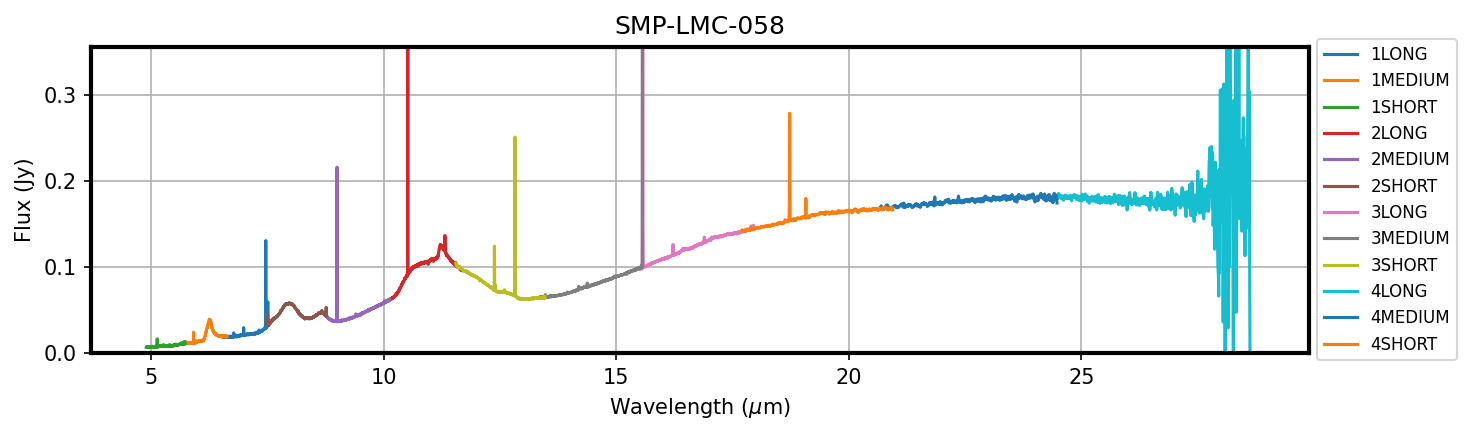

In [39]:
if doviz:
    # Make normal plots
    %matplotlib inline
    # Interactive plots
    #%matplotlib notebook

    rc('axes', linewidth=2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=150)

    if (len(x1dfiles) > 0):
        hdu = fits.open(x1dfiles[0])
        objname = hdu[0].header['TARGPROP']
        hdu.close()
    else:
        objname = 'Unknown'

    ymin, ymax = np.nan, np.nan
    for file in x1dfiles:
        x1d = fits.open(file)
        x1ddata = x1d[1].data
        wave = x1ddata['WAVELENGTH']
        # MRS x1d files have both regular ('flux') and residual-fringe (RF) corrected ('rf_flux') spectra.
        # The RF-corrected spectra will have NaN values if RF correction was disabled or failed to converge.
        # Plot the RF corrected spectrum if available, otherwise plot the regular spectrum.
        if (np.nansum(x1ddata['RF_FLUX']) != 0):
            flux = x1ddata['RF_FLUX']
        else:
            flux = x1ddata['FLUX']
        ymin = np.nanmin([ymin, np.nanpercentile(flux, 2)])
        ymax = np.nanmax([ymax, np.nanpercentile(flux, 99.5)])

        # labels
        label = x1d[0].header['CHANNEL'] + x1d[0].header['BAND']

        plt.plot(wave, flux, label=label)

        x1d.close()

    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Flux (Jy)')
    plt.title(objname)
    plt.ylim(ymin, ymax)
    plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.tight_layout()
    plt.savefig('mrs_example_plot.png')

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 